## References
http://webstructor.net/papers/Kolonin-HP-ACA-IC-text.pdf

In [89]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

import pandas as pd
import numpy as np
import math

import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = 0

#force reimport
if 'pygents.aigents_api' in sys.modules:
    del sys.modules['pygents.aigents_api']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']

from pygents.aigents_api import tokenize_re, punct, tokenize_re
from pygents.plot import plot_dict
from pygents.util import dictcount, dict_compress_with_loss, dictdict_div_dict, dictdict_mul_dictdict

punct = punct + "”“–&•"


[nltk_data] Downloading package punkt to /Users/akolonin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
test_dataset_file_path = "./data/corpora/English/distortions/sagarikashreevastava/test.csv"

In [8]:
# Dataset: Unclassified distortions (halilbabacan)
# Pre-print: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4582307
# Paper: https://dergipark.org.tr/tr/pub/fumbd/issue/88821/1469178
# Data: https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions
# https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/tree/main/raw
# https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/blob/main/raw/Cognitive_distortions.csv
    
binary_dataset_file_path = "./data/corpora/English/distortions/halilbabacan/raw_Cognitive_distortions.csv" 


In [9]:
# Dataset: Multiple Distorions (sagarikashreevastava)
# Paper: https://aclanthology.org/2021.clpsych-1.17/
# Data: https://www.kaggle.com/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset

# !pip install kagglehub
import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
print("Path to dataset files:", multiclass_dataset_path)
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"


Path to dataset files: /Users/akolonin/.cache/kagglehub/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset/versions/1


## Basic data check

### Binary Data Set (halilbabacan)

In [10]:
df = pd.read_csv(binary_dataset_file_path)
df.insert(1, "N/A text", value = np.nan)
df.insert(3, "N/A label", value = np.nan)
df


Text  N/A text       Label  \
0         I'm such a failure I never do anything right.       NaN  Distortion   
1          Nobody likes me because I'm not interesting.       NaN  Distortion   
2      I can't try new things because I'll just mess...       NaN  Distortion   
3      My boss didn't say 'good morning' she must be...       NaN  Distortion   
4      My friend didn't invite me to the party I mus...       NaN  Distortion   
...                                                 ...       ...         ...   
3522  Since then whenever my mother is out alone I b...       NaN  Distortion   
3523  My family hate him but they didn’t met him at ...       NaN  Distortion   
3524  However I am not happy at the least only half ...       NaN  Distortion   
3525  Now I am at university my peers around me all ...       NaN  Distortion   
3526  He claims he’s severely depressed and has outb...       NaN  Distortion   

      N/A label  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
3522        NaN  
3523        NaN  
3524        NaN  
3525        NaN  
3526        NaN  

[3527 rows x 4 columns]

defaultdict(<class 'int'>, {'Distortion': 2594, 'No Distortion': 933, ' ': 0})


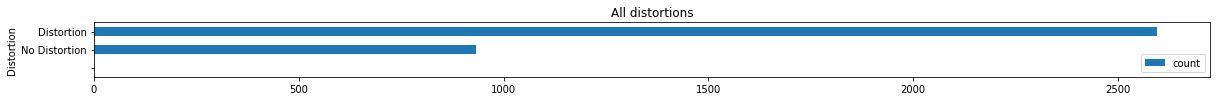

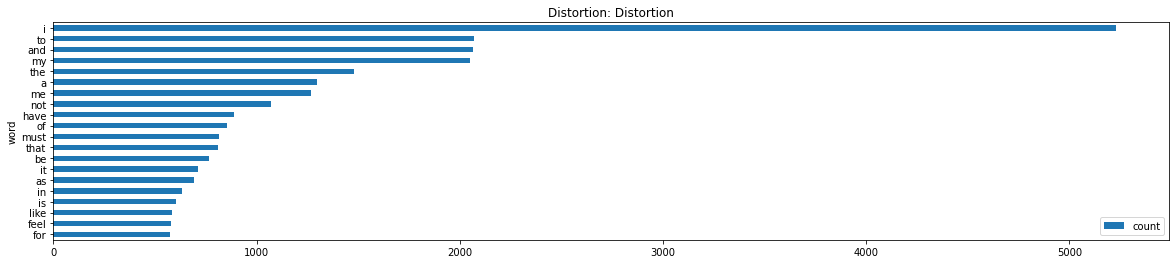

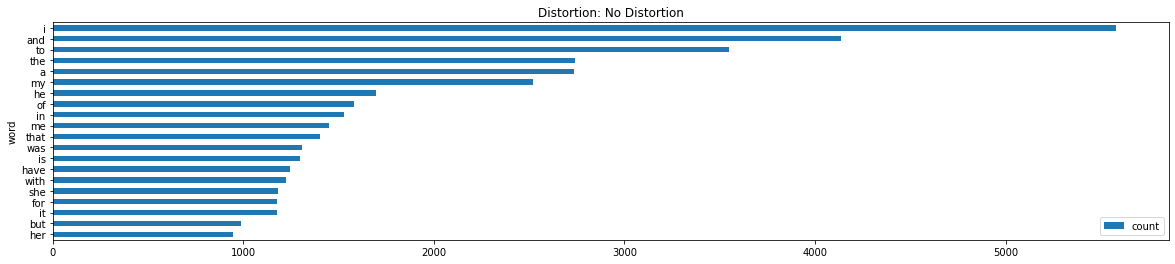

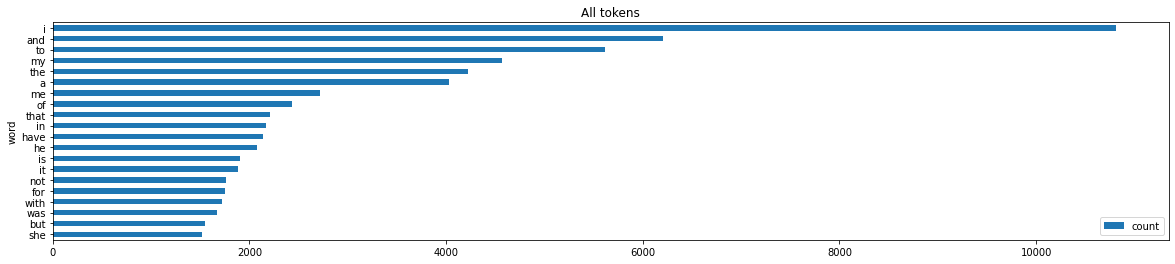

In [11]:
# Analyzing the frequency of words (tokens) for each cognitive distortion

from collections import defaultdict

all_distortions = defaultdict(int)

# Creating dictionaries for token counting
distortions_dicts = defaultdict(lambda: defaultdict(int))  # A separate dictionary is created for each distortion (distortion-token-token_frequency)
all_tokens_dict = defaultdict(int)  # A general dictionary of all tokens

# Manually define stop words (can be imported from the NLTK library)
# stop_words = {".", ","}

# Loop through the rows of the DataFrame
for _, row in df.iterrows():
    # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
    text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
    primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
    secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists

    dictcount(all_distortions,primary_distortion)
    if secondary_distortion:
        dictcount(all_distortions,secondary_distortion)
 
    # Text tokenization
    tokens = [t for t in tokenize_re(text) if not (t in punct or t.isnumeric())]

    # Remove stop words
    # filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_tokens = tokens

    dictcount(all_tokens_dict, filtered_tokens)  # Increment the counter in the general dictionary
    dictcount(distortions_dicts[primary_distortion], filtered_tokens)  # Increment the counter for the corresponding primary distortion
    if secondary_distortion:
        dictcount(distortions_dicts[secondary_distortion], filtered_tokens) # Increment the counter for the corresponding secondary distortion (if present)

#print("General dictionary of tokens:")
#print(dict(all_tokens_dict))

#print("\nDictionaries of tokens by distortions:")
#for distortion, tokens_dict in distortions_dicts.items():
#    print(f"Distortion '{distortion}':")
#    print(dict(tokens_dict))

# Displaying the results of word (token) frequency for each cognitive distortion

# Display graphs for all distortions
all_distortions[' '] = 0 # stub/hack
print(all_distortions)
plot_dict(
            all_distortions,
            labels="Distortion",
            values="count",
            title=f"All distortions",
            head=20             # All
    )

# Display graphs for each distortion
for distortion, tokens_dict in distortions_dicts.items():
    plot_dict(
        tokens_dict,
        labels="word",
        values="count",
        title=f"Distortion: {distortion}",
        head=20             # Top 20 words
    )


# Display a general graph for all tokens
plot_dict(
    all_tokens_dict,
    labels="word",
    values="count",
    title="All tokens",
    head=20                # Top 20 words
)


### Multi-class Data Set (sagarikashreevastava)

In [12]:
df = pd.read_csv(multiclass_dataset_file_path) 
df = df.drop('Id_Number', axis=1) # delete columnb with id 
df


Patient Question  \
0     Hello, I have a beautiful,smart,outgoing and a...   
1     Since I was about 16 years old I’ve had these ...   
2      So I’ve been dating on and off this guy for a...   
3     My parents got divorced in 2004. My mother has...   
4     I don’t really know how to explain the situati...   
...                                                 ...   
2525  I’m a 21 year old female. I spent most of my l...   
2526  I am 21 female and have not had any friends fo...   
2527  From the U.S.: My brother is 19 years old and ...   
2528  From the U.S.: I am a 21 year old woman who ha...   
2529  I recently moved out on my ex-roommate because...   

                                         Distorted part Dominant Distortion  \
0     The voice are always fimilar (someone she know...     Personalization   
1     I feel trapped inside my disgusting self and l...            Labeling   
2                                                   NaN       No Distortion   
3                                                   NaN       No Distortion   
4     I refused to go because I didn’t know if it wa...     Fortune-telling   
...                                                 ...                 ...   
2525                                                NaN       No Distortion   
2526  Now I am at university my peers around me all ...  Overgeneralization   
2527  He claims he’s severely depressed and has outb...       Mental filter   
2528                                                NaN       No Distortion   
2529                                                NaN       No Distortion   

     Secondary Distortion (Optional)  
0                                NaN  
1                Emotional Reasoning  
2                                NaN  
3                                NaN  
4                Emotional Reasoning  
...                              ...  
2525                             NaN  
2526                             NaN  
2527                    Mind Reading  
2528                             NaN  
2529                             NaN  

[2530 rows x 4 columns]

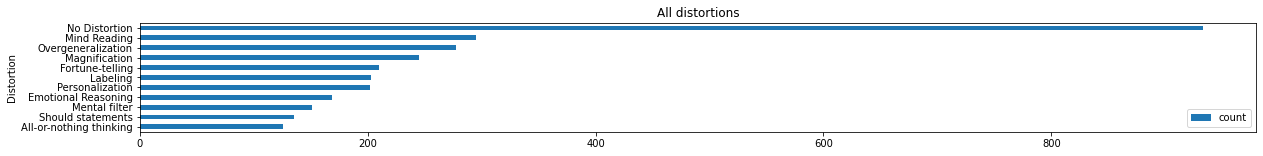

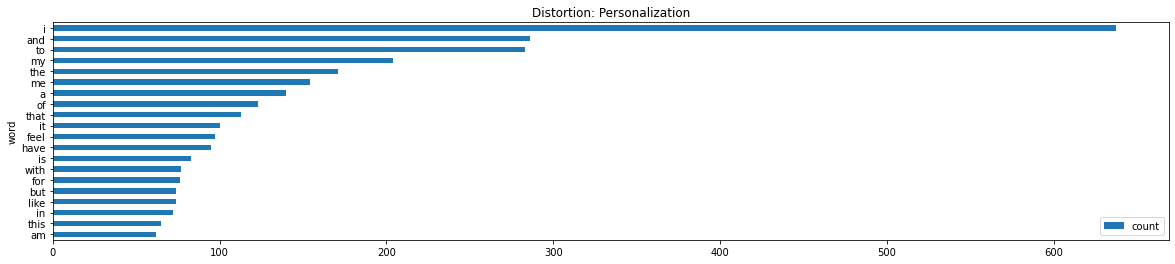

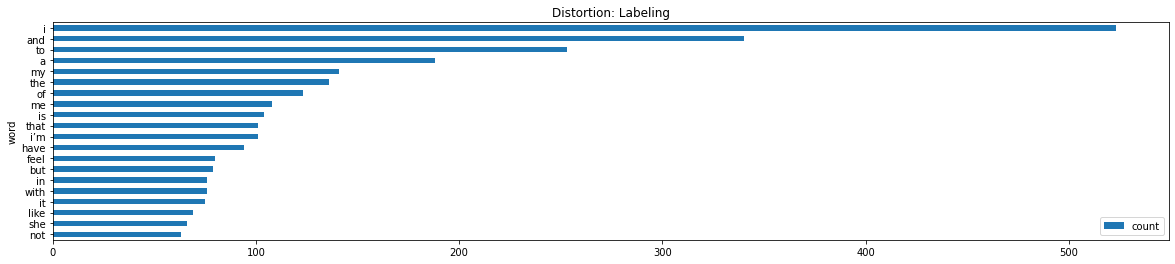

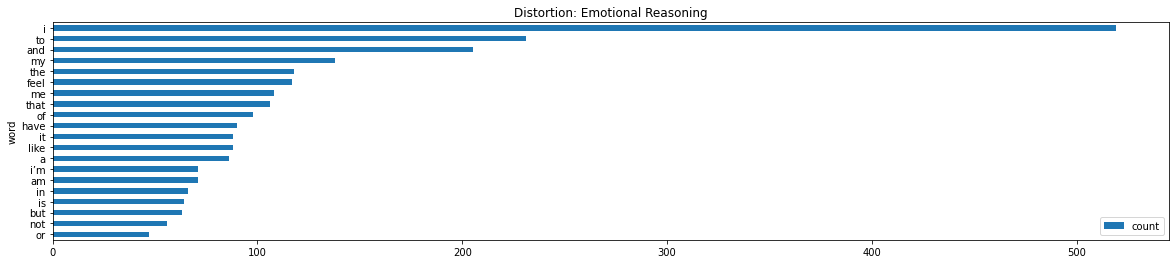

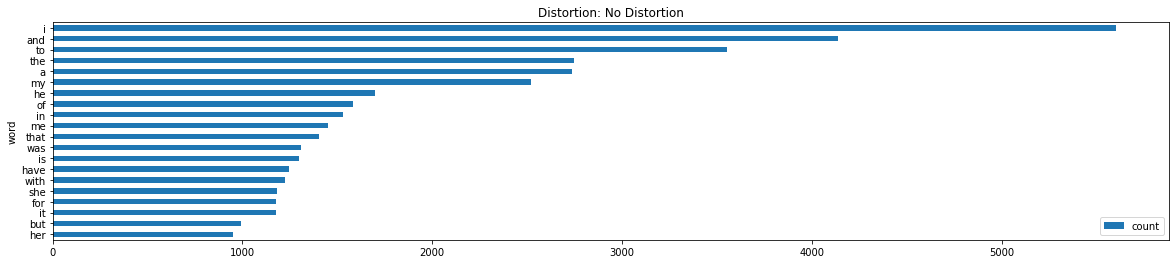

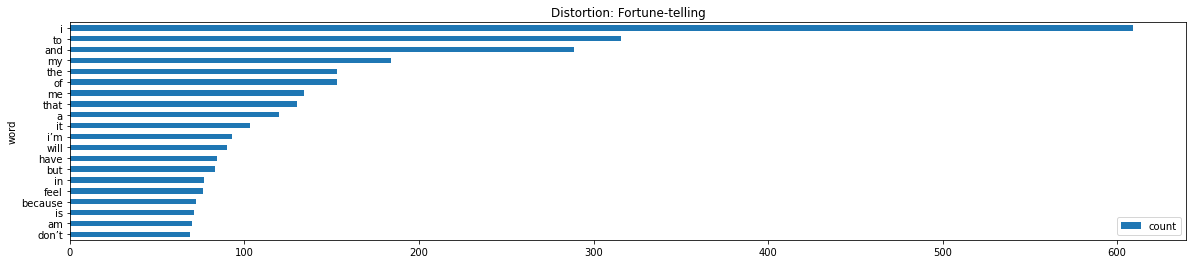

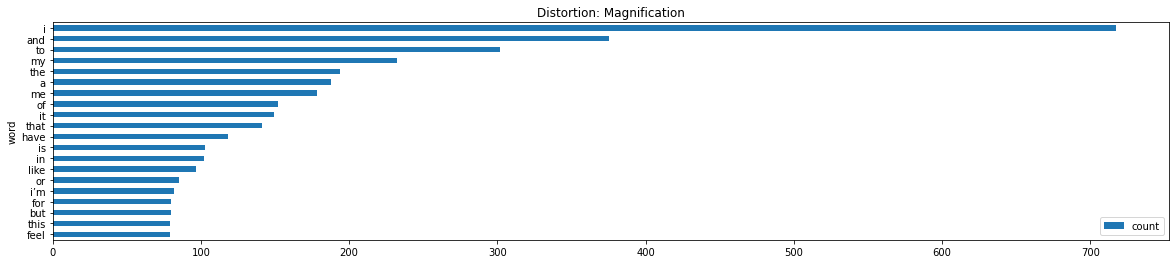

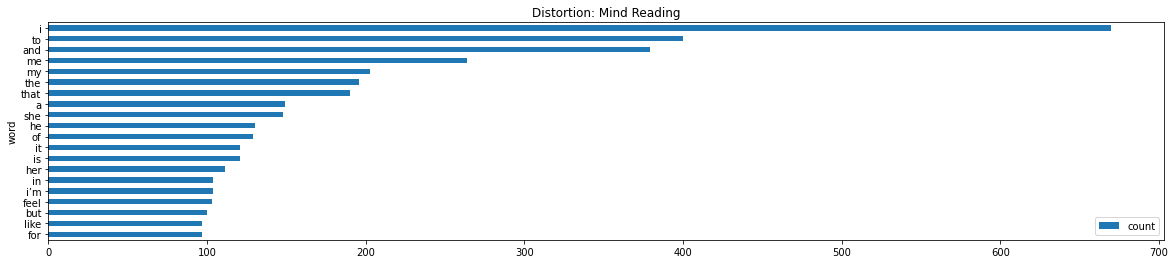

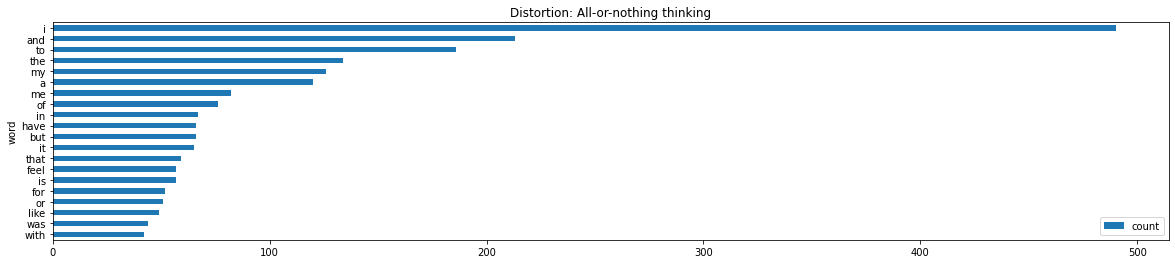

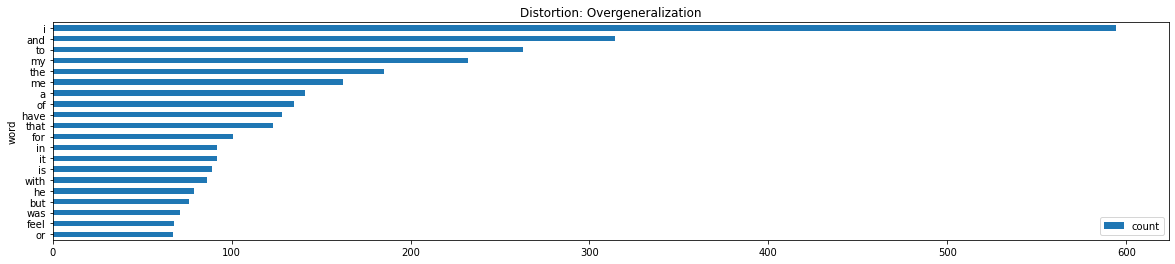

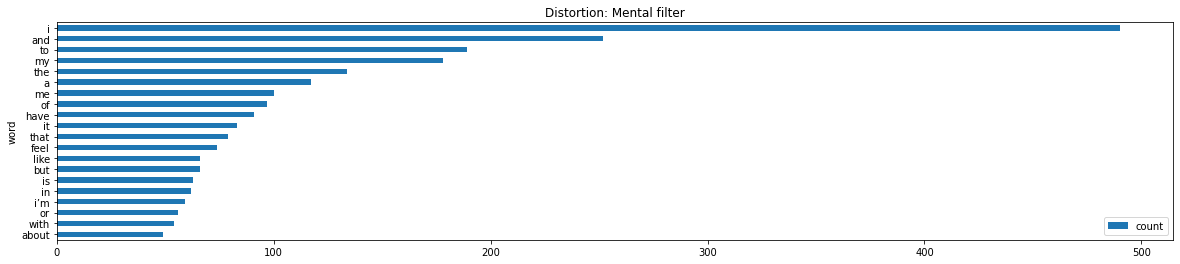

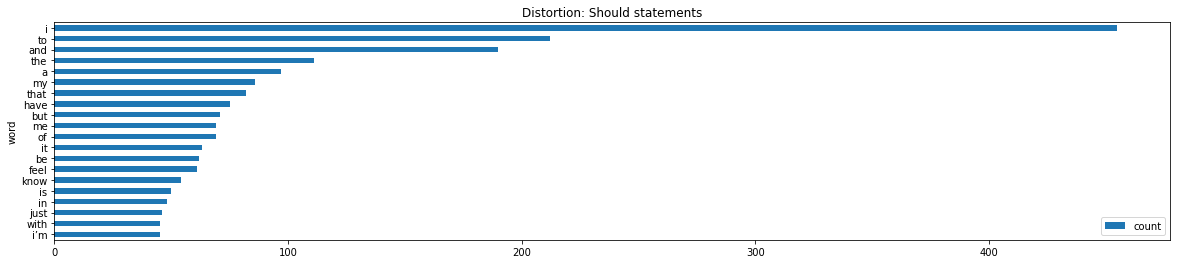

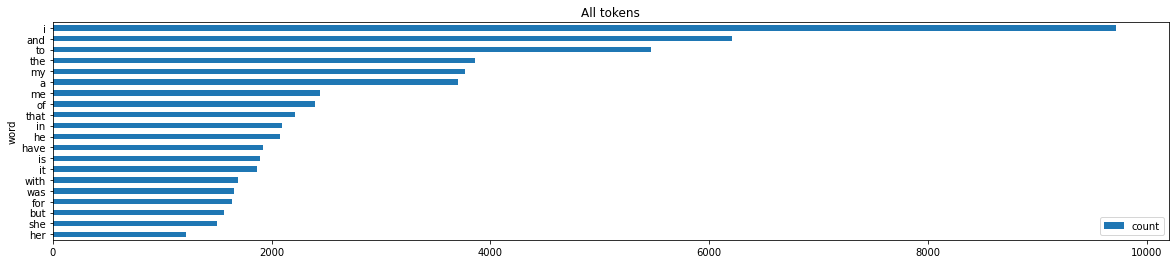

In [13]:
# Analyzing the frequency of words (tokens) for each cognitive distortion

from collections import defaultdict

all_distortions = defaultdict(int)

# Creating dictionaries for token counting
distortions_dicts = defaultdict(lambda: defaultdict(int))  # A separate dictionary is created for each distortion (distortion-token-token_frequency)
all_tokens_dict = defaultdict(int)  # A general dictionary of all tokens

# Manually define stop words (can be imported from the NLTK library)
# stop_words = {".", ","}

# Loop through the rows of the DataFrame
for _, row in df.iterrows():
    # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
    text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
    primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
    secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists

    dictcount(all_distortions,primary_distortion)
    if secondary_distortion:
        dictcount(all_distortions,secondary_distortion)
 
    # Text tokenization
    tokens = [t for t in tokenize_re(text) if not (t in punct or t.isnumeric())]

    # Remove stop words
    # filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_tokens = tokens

    dictcount(all_tokens_dict, filtered_tokens)  # Increment the counter in the general dictionary
    dictcount(distortions_dicts[primary_distortion], filtered_tokens)  # Increment the counter for the corresponding primary distortion
    if secondary_distortion:
        dictcount(distortions_dicts[secondary_distortion], filtered_tokens) # Increment the counter for the corresponding secondary distortion (if present)

#print("General dictionary of tokens:")
#print(dict(all_tokens_dict))

#print("\nDictionaries of tokens by distortions:")
#for distortion, tokens_dict in distortions_dicts.items():
#    print(f"Distortion '{distortion}':")
#    print(dict(tokens_dict))

# Displaying the results of word (token) frequency for each cognitive distortion

# Display graphs for all distortions
plot_dict(
            all_distortions,
            labels="Distortion",
            values="count",
            title=f"All distortions",
            head=20             # All
    )

# Display graphs for each distortion
for distortion, tokens_dict in distortions_dicts.items():
    plot_dict(
        tokens_dict,
        labels="word",
        values="count",
        title=f"Distortion: {distortion}",
        head=20             # Top 20 words
    )


# Display a general graph for all tokens
plot_dict(
    all_tokens_dict,
    labels="word",
    values="count",
    title="All tokens",
    head=20                # Top 20 words
)


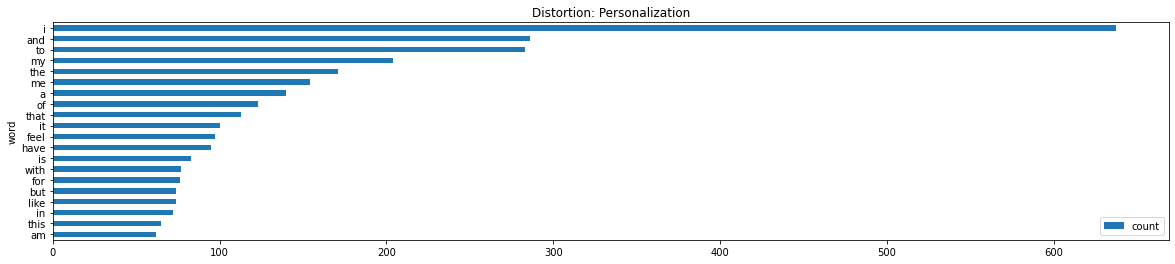

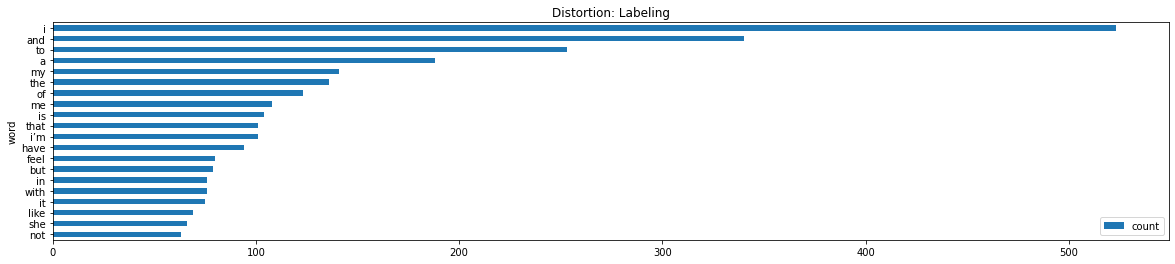

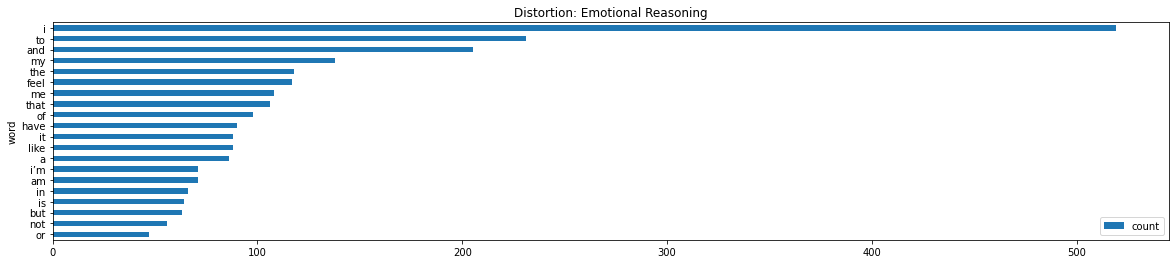

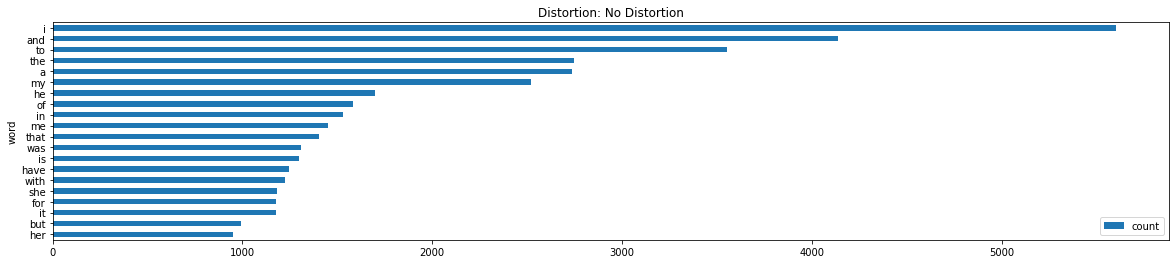

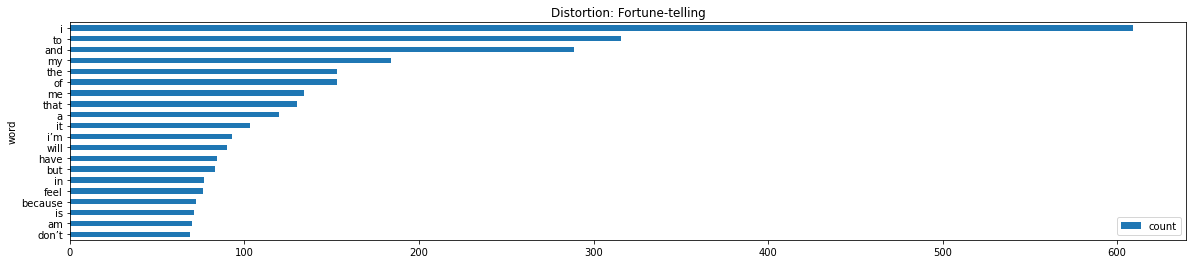

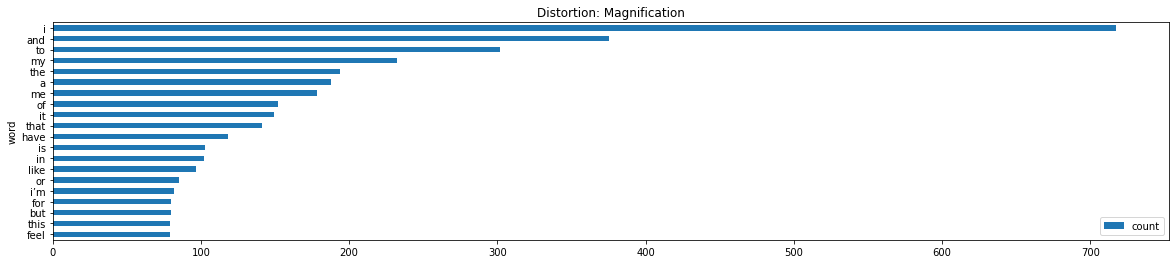

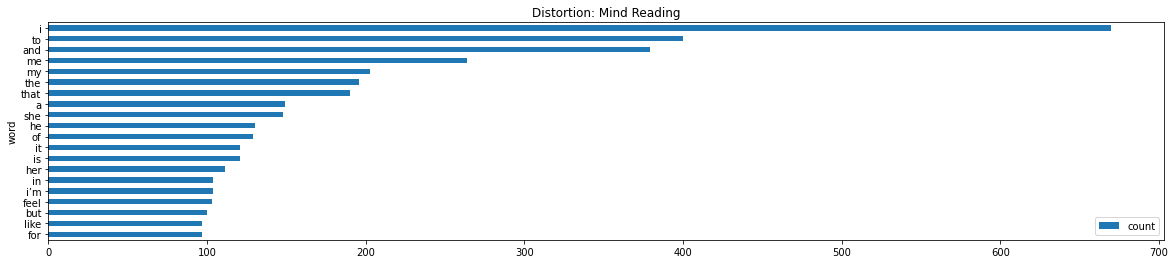

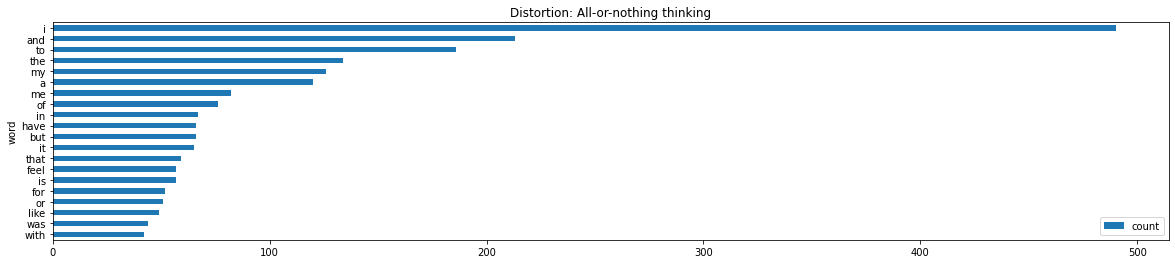

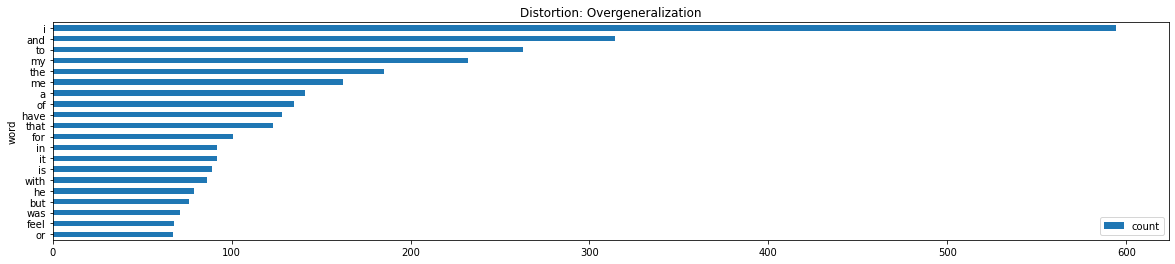

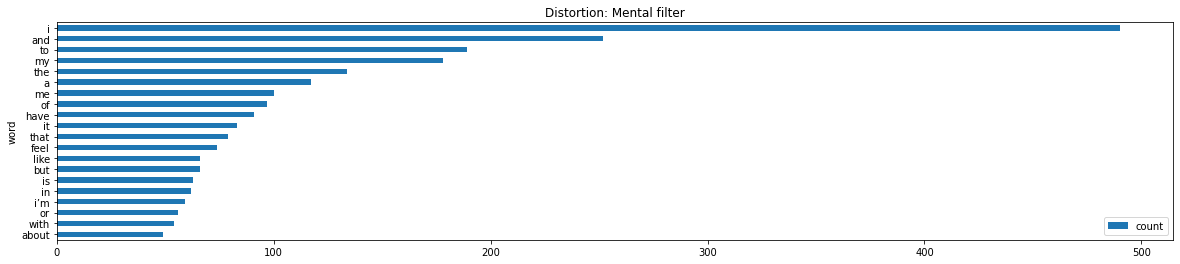

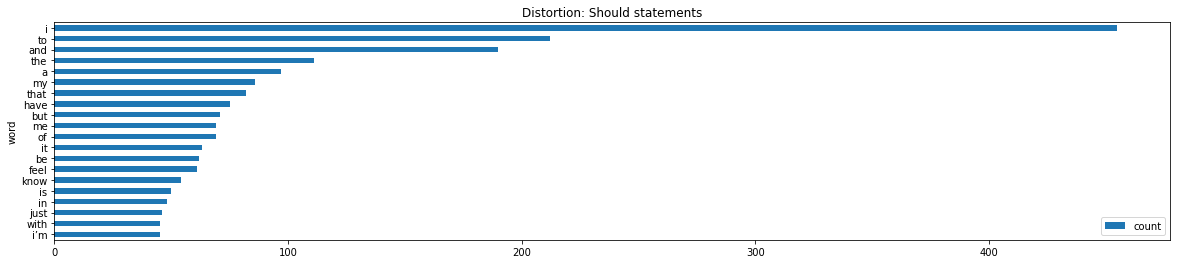

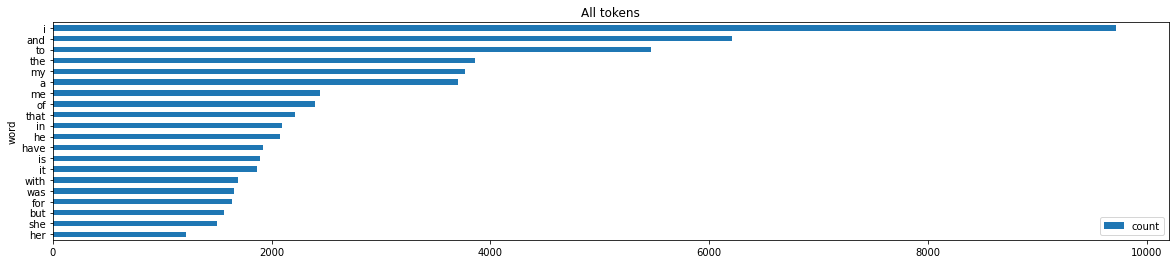

In [14]:
# Displaying the results of word (token) frequency for each cognitive distortion

# Display graphs for each distortion
for distortion, tokens_dict in distortions_dicts.items():
    plot_dict(
        tokens_dict,
        labels="word",
        values="count",
        title=f"Distortion: {distortion}",
        head=20             # Top 20 words
    )


# Display a general graph for all tokens
plot_dict(
    all_tokens_dict,
    labels="word",
    values="count",
    title="All tokens",
    head=20                # Top 20 words
)

## Define working functions to be moved to the code module

In [15]:
# Analyze the frequency of n-grams for each cognitive distortion

from pygents.aigents_api import build_ngrams

def count_ngrams_basic(df, n_max: int):

    distortions = defaultdict(int)

    # Creating dictionaries for counting n-grams
    n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-n-gram-n_gram_frequency)
    all_n_grams = defaultdict(int)  # A general dictionary for all n-grams
    
    uniq_n_gram_dicts = defaultdict(lambda: defaultdict(int)) # Counts of uniq N-grams by Distortion
    uniq_all_n_grams = defaultdict(int)  # A general dictionary for all n-grams uniq by text
    n_gram_distortions = defaultdict(lambda: defaultdict(int)) # Counts of distortiions by N-gram

    # Loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The primary cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if present

        dictcount(distortions,primary_distortion)
        if secondary_distortion:
            dictcount(distortions,secondary_distortion)
        
        # Text tokenization
        tokens = [t for t in tokenize_re(text) if not (t in punct or t.isnumeric())]

        # Generation and counting of n-grams (from 1 to 4)
        for n in range(1, n_max + 1):
            n_grams = build_ngrams(tokens, n)
            dictcount(all_n_grams, n_grams)
            dictcount(n_gram_dicts[primary_distortion], n_grams)  # Increment the counter for the corresponding primary distortion
            if secondary_distortion:
                dictcount(n_gram_dicts[secondary_distortion], n_grams) # Increment the counter for the corresponding secondary distortion (if present)

            uniq_n_grams = set(n_grams)
            for uniq_n_gram in uniq_n_grams:
                dictcount(uniq_n_gram_dicts[primary_distortion], uniq_n_gram)
                dictcount(uniq_all_n_grams, uniq_n_gram)
                dictcount(n_gram_distortions[uniq_n_gram],primary_distortion)
                if secondary_distortion:
                    dictcount(uniq_n_gram_dicts[secondary_distortion], uniq_n_gram)
                    dictcount(n_gram_distortions[uniq_n_gram],secondary_distortion)
                
    # Normalizing distortion-specific counts by total counts
    norm_n_gram_dicts = {}
    for n_gram_dict in n_gram_dicts:
        norm_n_gram_dict = {}
        norm_n_gram_dicts[n_gram_dict] = norm_n_gram_dict
        dic = n_gram_dicts[n_gram_dict]
        for n_gram in dic:
            #print(dic[n_gram])
            #print(all_n_grams[n_gram])
            #break
            if len(n_gram) <= n_max:
                norm_n_gram_dict[n_gram] = float( dic[n_gram] ) / all_n_grams[n_gram]

    # Normalize uniq counts 
    norm_uniq_n_gram_dicts = {}
    for uniq_n_gram_dict in uniq_n_gram_dicts: # iterate over all distortions
        norm_uniq_n_gram_dict = {}
        norm_uniq_n_gram_dicts[uniq_n_gram_dict] = norm_uniq_n_gram_dict
        dic = uniq_n_gram_dicts[uniq_n_gram_dict] # pick uniq count of ngrams per distortion
        nonuniq_dic = n_gram_dicts[uniq_n_gram_dict] # pick non-uniq count of ngrams per distortion - BUG!?
        # Normalize uniq Document counts of N-grams by distortion by Documents count by Distortion
        for n_gram in dic:
            if len(n_gram) <= n_max:
                #norm_uniq_n_gram_dict[n_gram] = float( dic[n_gram] ) * nonuniq_dic[n_gram] / distortions[uniq_n_gram_dict] / len(n_gram_distortions[n_gram]) / all_n_grams[n_gram]
                # divide (uniq count if ngrams by distorion) by (count of texts with given distorion) and (count of ngrams with given distortion)
                norm_uniq_n_gram_dict[n_gram] = float( dic[n_gram] ) / distortions[uniq_n_gram_dict] / len(n_gram_distortions[n_gram])
 
    n_gram_distortions_counts = {}
    for n_gram, dist_dict in n_gram_distortions.items():
        n_gram_distortions_counts[n_gram] = len(dist_dict)

    return distortions, n_gram_dicts, all_n_grams, norm_n_gram_dicts, uniq_n_gram_dicts, uniq_all_n_grams, n_gram_distortions, \
    norm_uniq_n_gram_dicts, n_gram_distortions_counts


def count_ngrams_plus(df, n_max: int):
    N = len(df)
    distortions, n_gram_dicts, all_n_grams, norm_n_gram_dicts, uniq_n_gram_dicts, uniq_all_n_grams, n_gram_distortions, \
    norm_uniq_n_gram_dicts, n_gram_distortions_counts = count_ngrams_basic(df, n_max)

    norm = dictdict_div_dict(n_gram_dicts,all_n_grams)
    norm_uniq = dictdict_div_dict(uniq_n_gram_dicts,uniq_all_n_grams)
    norm_norm_uniq = dictdict_mul_dictdict(norm,norm_uniq)
    norm_norm_uniq_norm = dictdict_div_dict(norm_norm_uniq,n_gram_distortions_counts)
    
    # norm_norm_uniq_norm_norm = norm_norm_uniq_norm[dist][n_gram] * n_gram_distortions[n_gram][dist] / distortions[dist]
    norm_norm_uniq_norm_norm = {} # looks like desired magic
    for dist in distortions:
        if not dist in norm_norm_uniq_norm: #hack
            continue
        dic = norm_norm_uniq_norm[dist]
        norm_norm_uniq_norm_norm[dist] = {}
        for n_gram in dic:
            norm_norm_uniq_norm_norm[dist][n_gram] = dic[n_gram] * n_gram_distortions[n_gram][dist] / distortions[dist]

    nl_mi = {}
    for dist in uniq_n_gram_dicts:
        dic = uniq_n_gram_dicts[dist]
        nl_mi[dist] = {}
        for n_gram in dic:
            nl_mi[dist][n_gram] = dic[n_gram] * dic[n_gram] / (distortions[dist] * uniq_all_n_grams[n_gram])
    
    fcr = {}
    cfr = {}
    mr = {}
    for dist in uniq_n_gram_dicts:
        dic = uniq_n_gram_dicts[dist]
        fcr[dist] = {}
        cfr[dist] = {}
        mr[dist] = {}
        for n_gram in dic:
            features_by_cat = sum(dic.values()) # features by category
            cats_by_feature = sum(n_gram_distortions[n_gram].values()) # categories by feature
            fcr[dist][n_gram] = dic[n_gram] / cats_by_feature # feature to category relevance - denominated by n of categories by feature
            cfr[dist][n_gram] = dic[n_gram] / features_by_cat # category to feature relevance - denominated by n of features by category
            mr[dist][n_gram] = dic[n_gram] * dic[n_gram] / (features_by_cat * cats_by_feature)
    
    return distortions, n_gram_dicts, all_n_grams, norm_n_gram_dicts, uniq_n_gram_dicts, uniq_all_n_grams, n_gram_distortions, \
    norm_uniq_n_gram_dicts, n_gram_distortions_counts, norm, norm_uniq, norm_norm_uniq, norm_norm_uniq_norm, norm_norm_uniq_norm_norm, \
    fcr, cfr, mr, nl_mi, N


## Definitions
|Python|Formula|Formula meaning|
|---|---|---|
|all_n_grams | $G_g$ | total count of N-gram $g$ in the entire corpus|
|distortions | $D_d$ | count of texts with distortion $d$ per corpus|
||$G_d$|count of N-grams associated with distortion $d$|
|uniq_all_n_grams | $G^u_g$ | total uniq count of N-gram $g$ in the entire corpus (counting every N-gram appearing in particular text only once)|
|n_gram_distortions_counts | $D_g$ | count of distortions by N-gram $g$, based on $DG_{dg}$ |
|n_gram_dicts | $GD_{gd}$ | count of N-gram $g$ associations with distortion $d$ - **frequency** - *DONE*|
|uniq_n_gram_dicts | $GD^u_{gd}$ | count of unique N-gram $g$ associations with distortion $d$ (counting every N-gram appearing in particular text only once) - **uniq frequency** - *TODO?*|
|n_gram_distortions | $DG_{dg}$ | count of distortion $d$ associations with N-gram $g$ (counting every N-gram appearing in particular text only once), $DG_{dg} == GD^u_{gd}$ |
|norm_n_gram_dicts == norm = dictdict_div_dict(n_gram_dicts,all_n_grams)| $\bar{GD}_{gd} = GD_{gd} / G_g$ | **frequency self-normalized** -  counts of N-grams normalized by corpus counts - *DONE*|
|norm_uniq = dictdict_div_dict(uniq_n_gram_dicts,uniq_all_n_grams)| $\bar{GD}^u_{gd} = GD^u_{gd} / G^u_g$ | **unique frequency self-normalized** - counts of uniq N-grams normalized by uniq corpus counts - *TODO?*|
|norm_uniq_n_gram_dicts| $GD^u_{gd} /(D_d * D_g)$ | **unique frequency normalized by distortions** - unique count of N-gram $g$ associations with distiortion $d$ within the corpus, denominated by count of appearances of the distortion in corpus and count of distortions associated with N-gram - *TODO!*|
|norm_norm_uniq = dictdict_mul_dictdict(norm,norm_uniq)|$\bar{GD}_{gd} * \bar{GD}^u_{gd}$|**frequency sefl-normalized * unique frequency sefl-normalized** - *TODO?*|
|norm_norm_uniq_norm = dictdict_div_dict(norm_norm_uniq,n_gram_distortions_counts)|$\bar{GD}_{gd} * \bar{GD}^u_{gd} / D_g$|**frequency sefl-normalized * unique frequency sefl-normalized / distortions by N-gram** - *TODO?*|
|norm_norm_uniq_norm_norm = norm_norm_uniq_norm * n_gram_distortions / distortions|$\bar{GD}_{gd} * \bar{GD}^u_{gd} * DG_{dg} / (D_g * D_d)$|**magic recipe** - *TODO?*|
|fcr|$GD^u_{gd} / \sum_d{GD^u_{gd}}$|**feature category relevance** according to http://webstructor.net/papers/Kolonin-HP-ACA-IC-text.pdf - *TODO?*|
|cfr|$GD^u_{gd} / \sum_g{GD^u_{gd}}$|**category feature relevance** according to http://webstructor.net/papers/Kolonin-HP-ACA-IC-text.pdf - *TODO?*|
|mr|${GD^u_{gd}}^2 /(\sum_d{GD^u_{gd}} *  \sum_g{GD^u_{gd}})$|**mutual relevance** according to http://webstructor.net/papers/Kolonin-HP-ACA-IC-text.pdf - *TODO?*|
|nl_mi|$ {GD^u_{gd}}^2 / (D_d * G^u_g) )$|**non-logartihmic mutual information** - squared joint distribution of X and Y denominated by product of the marginal distribution of X and Y, according to https://en.wikipedia.org/wiki/Mutual_information - *TODO?*|
|mi|$MI(GD)_{gd}$ = $P(g,d)*log(P(g,d)/(P(g)*P(d)))$ = $(GD^u_{gd}/N)*log((GD^u_{gd}/N)/((D_d/N)*(G^u_g/N)))$ = $(GD^u_{gd}/N)*log(N *GD^u_{gd}/(D_d*G^u_g))$|**mutual information** according to https://en.wikipedia.org/wiki/Mutual_information (if the log base 2 is used, the unit of mutual information is the shannon), *found to be negative!?* - *SKIP?*|
|TF-IDF| $TF-IDF = GD_{gd} / G_d$ | **TF-IDF** -  counts of N-grams normalized by the total number of N-grams associations with distortion $d$ - *DONE*|


## Test on synthetic data

In [16]:
df = pd.read_csv(test_dataset_file_path)
df = df.drop('Id_Number', axis=1) # delete column with id 
    
distortions, frequency, all_n_grams, frequency_self_normalized, unique_frequency, uniq_all_n_grams, n_gram_distortions, \
norm_uniq_n_gram_dicts, n_gram_distortions_counts, norm, unique_frequency_self_normalized, norm_norm_uniq, norm_norm_uniq_norm, \
norm_norm_uniq_norm_norm, fcr, cfr, mr, nl_mi, N = count_ngrams_plus(df,2)

for d1, d2 in zip(frequency_self_normalized, norm):
    assert( d1 == d2)
    for ng in frequency_self_normalized[d1]:
        assert( frequency_self_normalized[d1][ng] == norm[d2][ng] )

for d in unique_frequency:
    for ng in unique_frequency[d]:
        assert(unique_frequency[d][ng] == n_gram_distortions[ng][d] )


In [17]:
selection_metrics = [
    (frequency,'F'),
    (unique_frequency,'UF'),
    (frequency_self_normalized,'FN'),
    (unique_frequency_self_normalized,'UFN'),
    (norm_uniq_n_gram_dicts,'UFN/D/D'),
    (norm_norm_uniq,'FN*UFN'),
    (norm_norm_uniq_norm,'FN*UFN/D'),
    (norm_norm_uniq_norm_norm,'FN*UFN*UF/D/D'),
    (cfr,'CFR'),
    (fcr,'FCR'),
    (mr,'MR'),
    (nl_mi,'NLMI')
]

In [18]:
sum(unique_frequency['Fortune-telling'].values())

23

In [19]:
sum(n_gram_distortions[('will','fail')].values())

5

In [20]:
unique_frequency['Fortune-telling'][('will', 'fail')]

3

In [21]:
unique_frequency['Fortune-telling'][('will', 'fail')] \
* unique_frequency['Fortune-telling'][('will', 'fail')] \
/ sum(unique_frequency['Fortune-telling'].values()) \
/ sum(n_gram_distortions[('will','fail')].values())

0.0782608695652174

In [22]:
mr['Fortune-telling'][('will', 'fail')]

0.0782608695652174

In [23]:
fcr['Fortune-telling'][('will', 'fail')]

0.6

In [24]:
cfr['Fortune-telling'][('will', 'fail')]

0.13043478260869565

In [25]:
nl_mi['Fortune-telling'][('will', 'fail')]

1.0

In [26]:
nl_mi['No Distortion'][('will', )]

0.16

In [27]:
def plot_metric(dictdict,name,head=20):
    for distortion, metric in dictdict.items():
        if distortion == 'No Distortion':
            continue
        plot_dict(metric, labels="N-gram",values="metric", title=f"{name} for Distortion: {distortion}", head=head, fontsize = 20 )


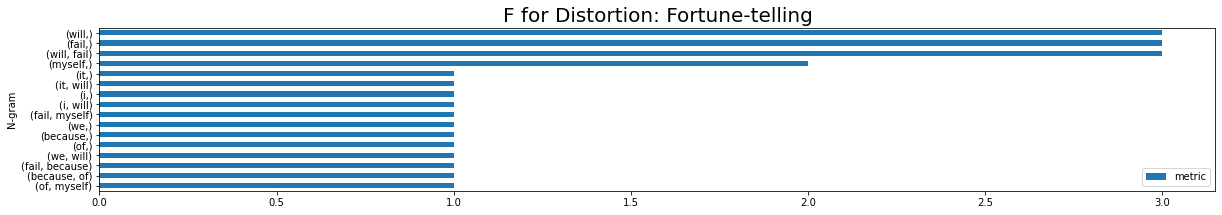

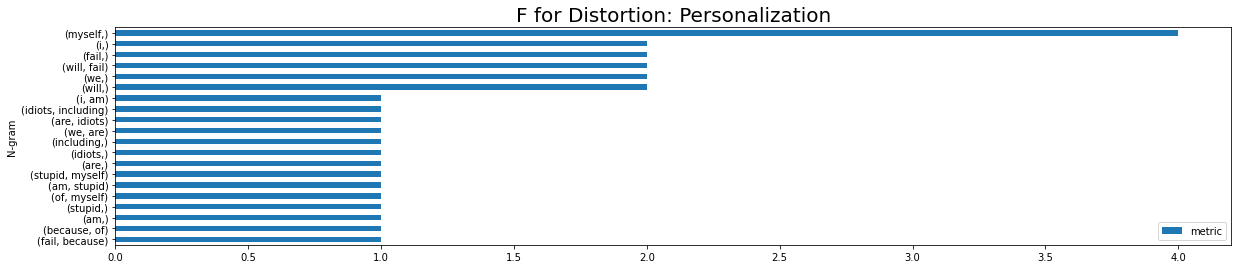

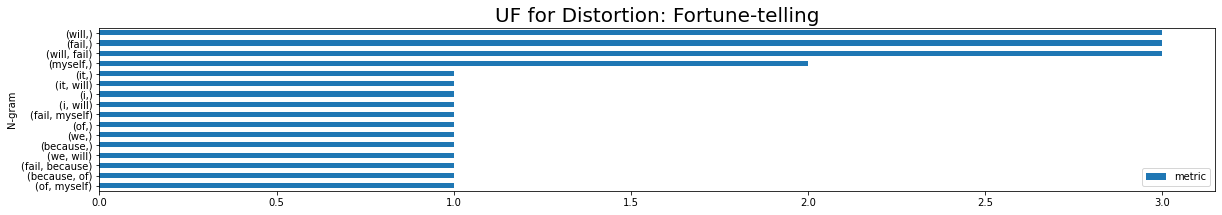

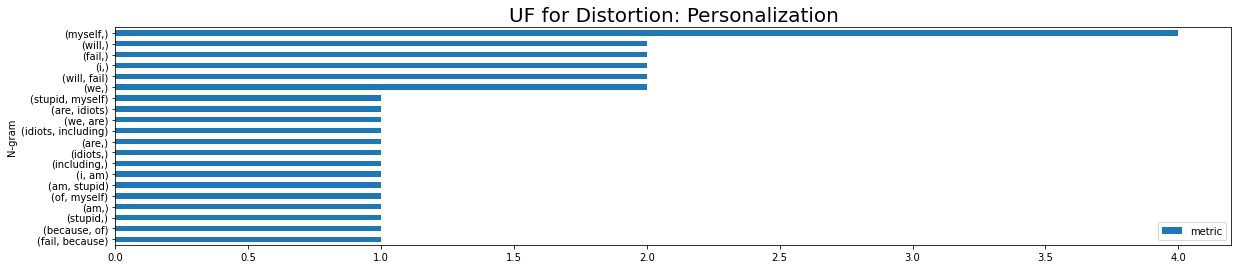

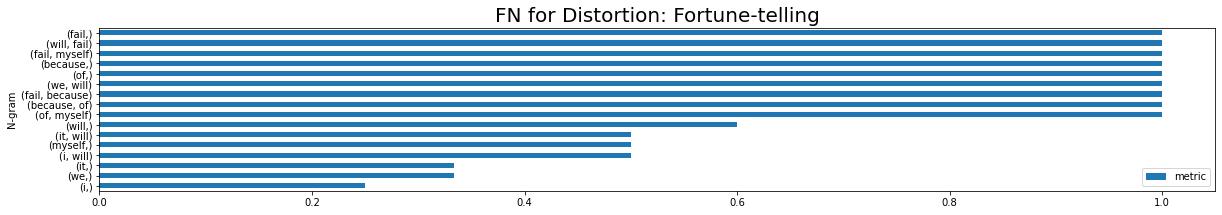

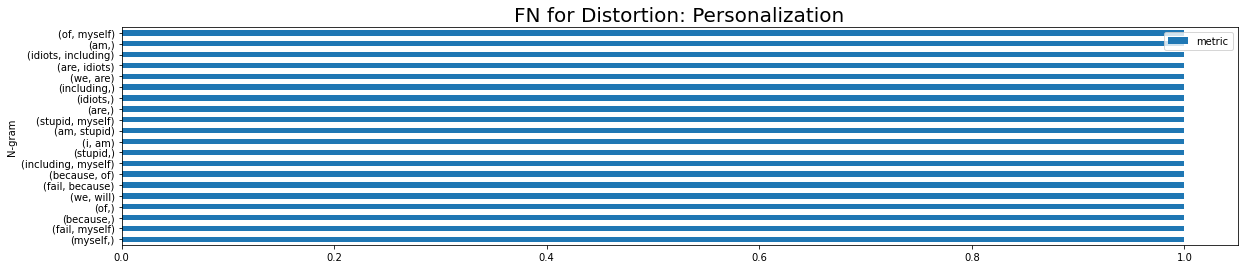

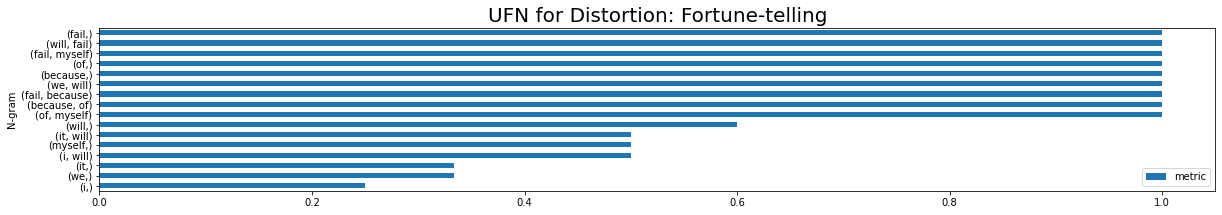

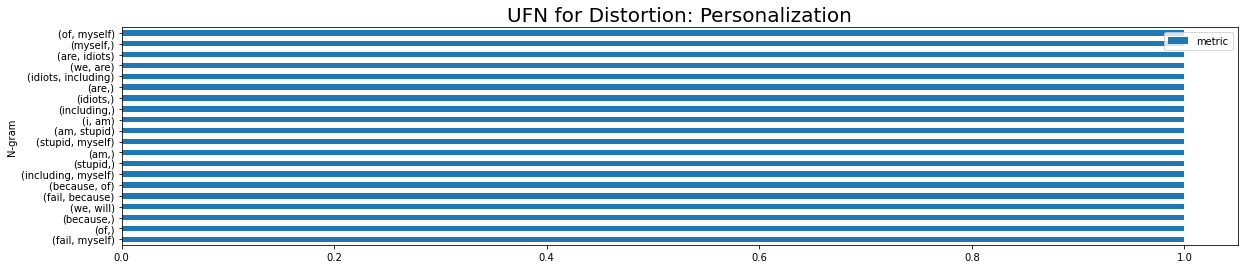

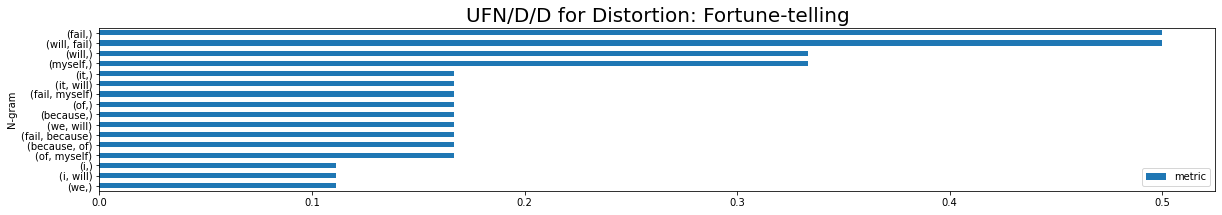

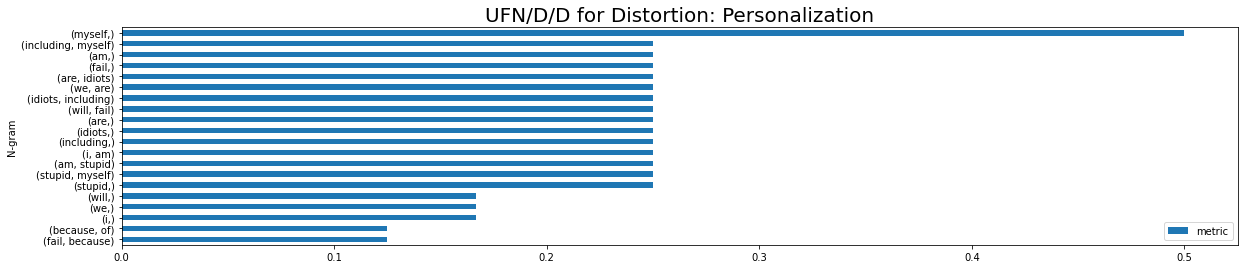

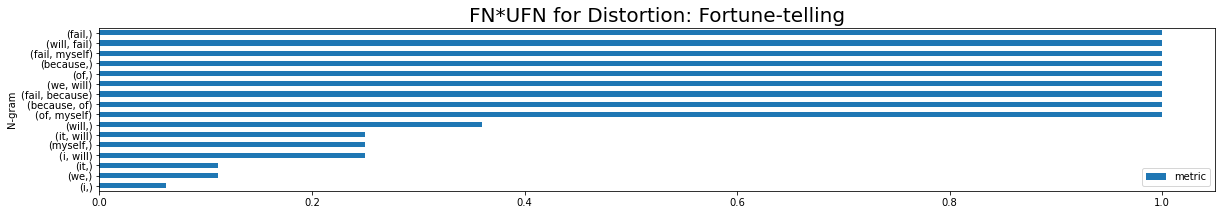

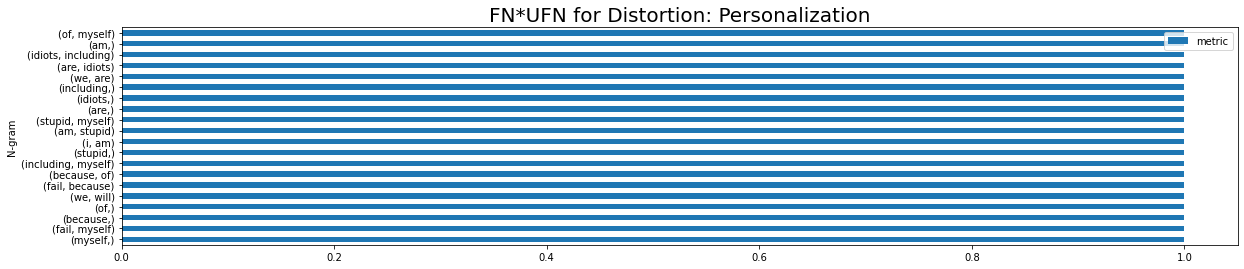

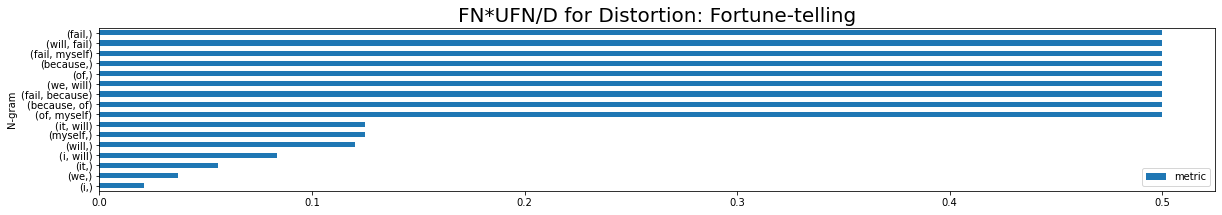

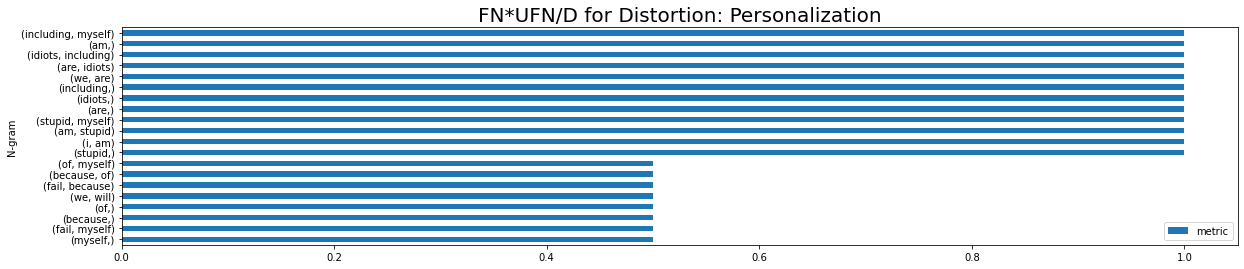

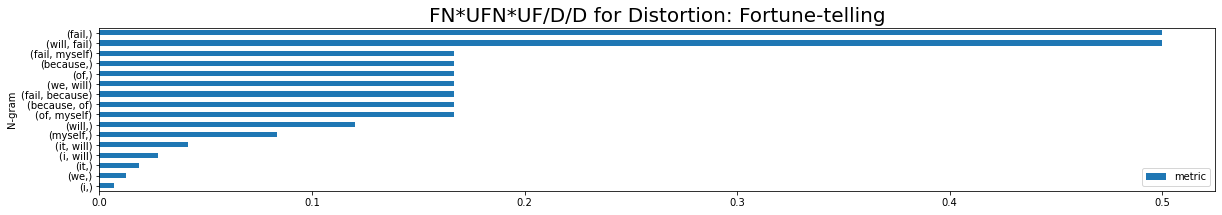

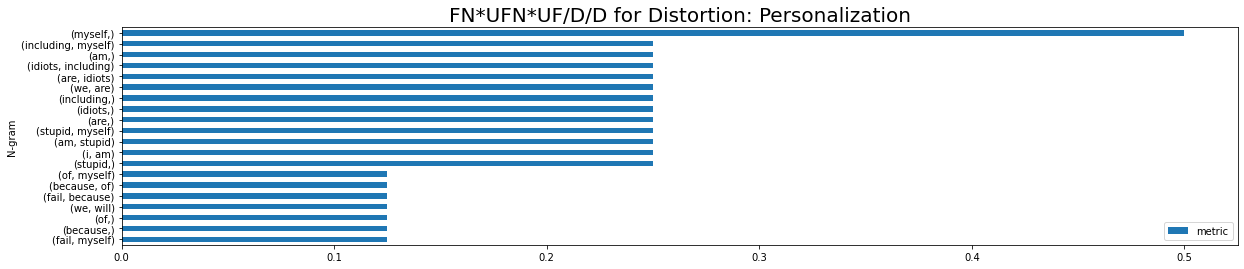

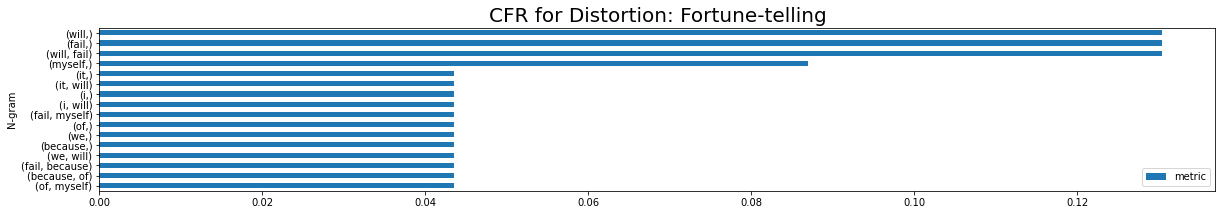

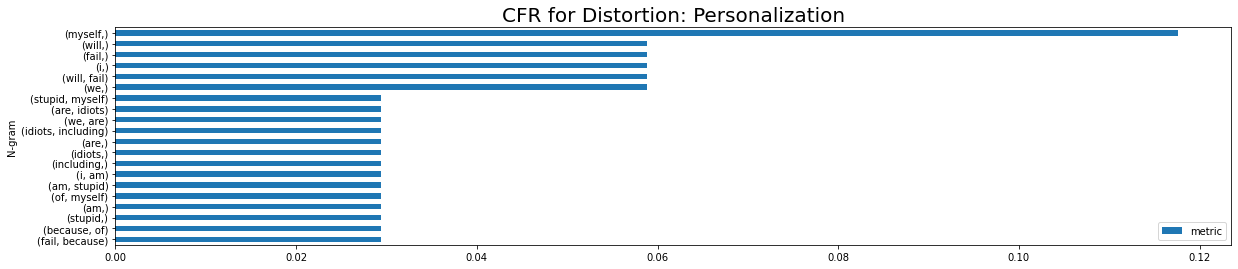

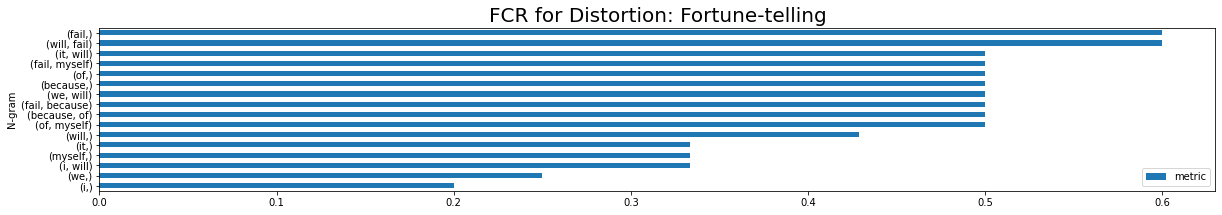

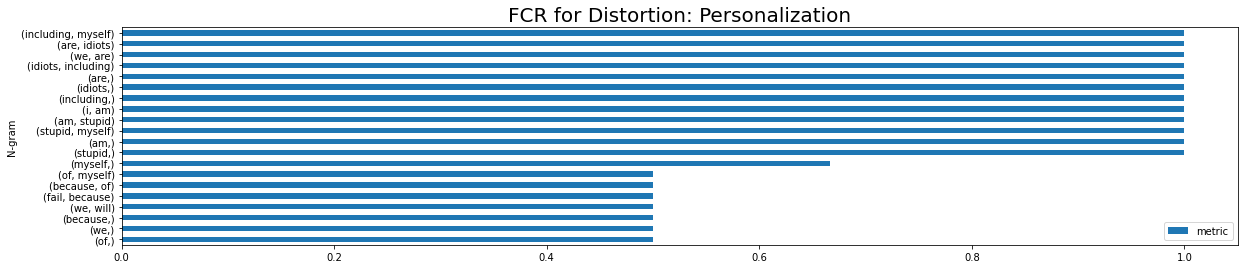

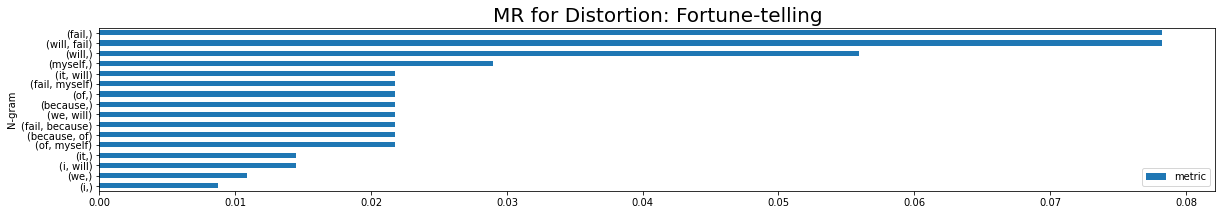

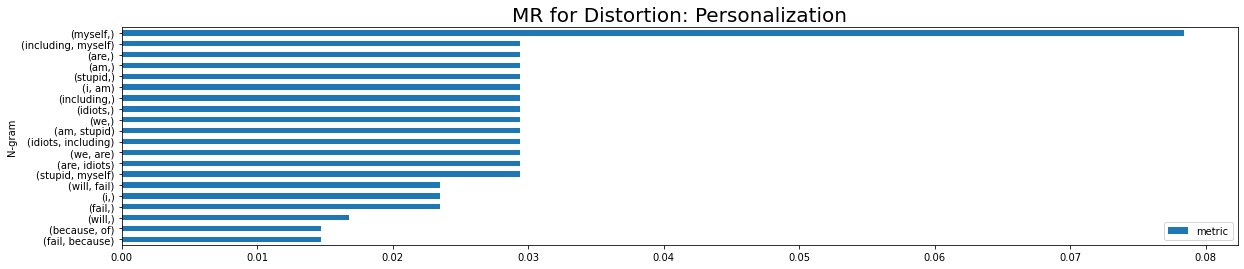

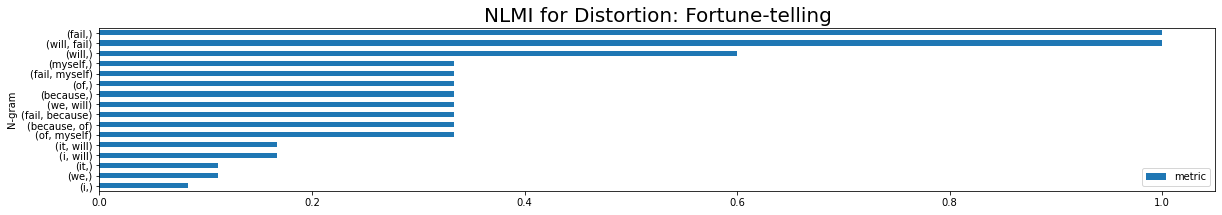

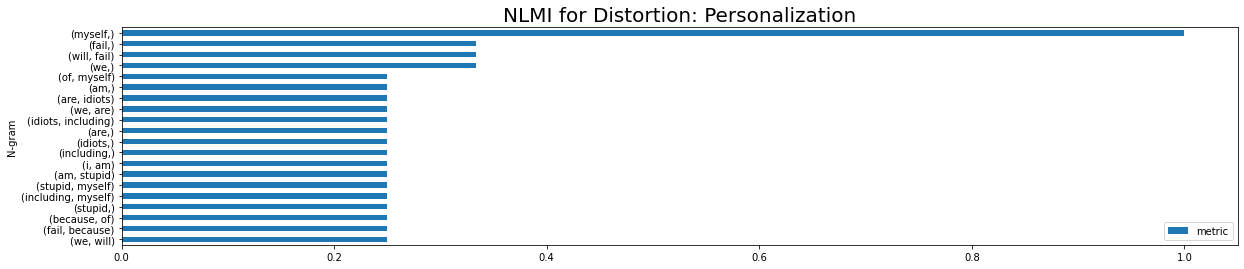

In [28]:
for selection_metric in selection_metrics:
    plot_metric(selection_metric[0],selection_metric[1])

## Test on Binary Data

In [29]:
df = pd.read_csv(binary_dataset_file_path)
df.insert(1, "N/A text", value = np.nan)
df.insert(3, "N/A label", value = np.nan)

distortions, frequency, all_n_grams, frequency_self_normalized, unique_frequency, uniq_all_n_grams, n_gram_distortions, \
norm_uniq_n_gram_dicts, n_gram_distortions_counts, norm, unique_frequency_self_normalized, norm_norm_uniq, norm_norm_uniq_norm, \
norm_norm_uniq_norm_norm, fcr, cfr, mr, nl_mi, N = count_ngrams_plus(df,3)

for d1, d2 in zip(frequency_self_normalized, norm):
    assert( d1 == d2)
    for ng in frequency_self_normalized[d1]:
        assert( frequency_self_normalized[d1][ng] == norm[d2][ng] )

for d in unique_frequency:
    for ng in unique_frequency[d]:
        assert(unique_frequency[d][ng] == n_gram_distortions[ng][d] )


In [30]:
selection_metrics = [
    (frequency,'F'),
    (unique_frequency,'UF'),
    (frequency_self_normalized,'FN'),
    (unique_frequency_self_normalized,'UFN'),
    (norm_uniq_n_gram_dicts,'UFN/D/D'),
    (norm_norm_uniq,'FN*UFN'),
    (norm_norm_uniq_norm,'FN*UFN/D'),
    (norm_norm_uniq_norm_norm,'FN*UFN*UF/D/D'),
    (cfr,'CFR'),
    (fcr,'FCR'),
    (mr,'MR'),
    (nl_mi,'NLMI')
]

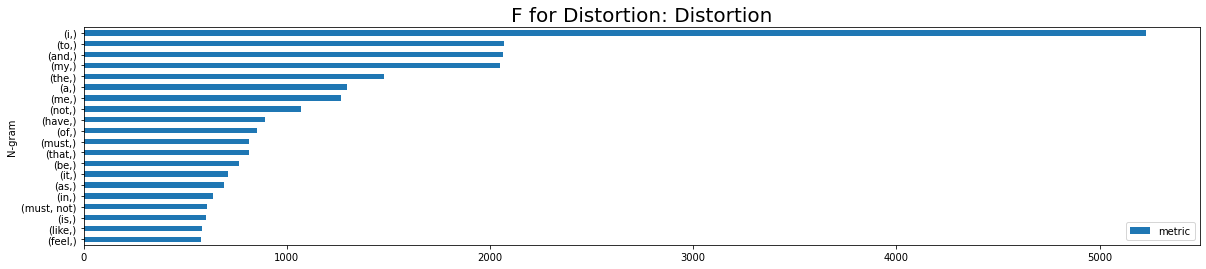

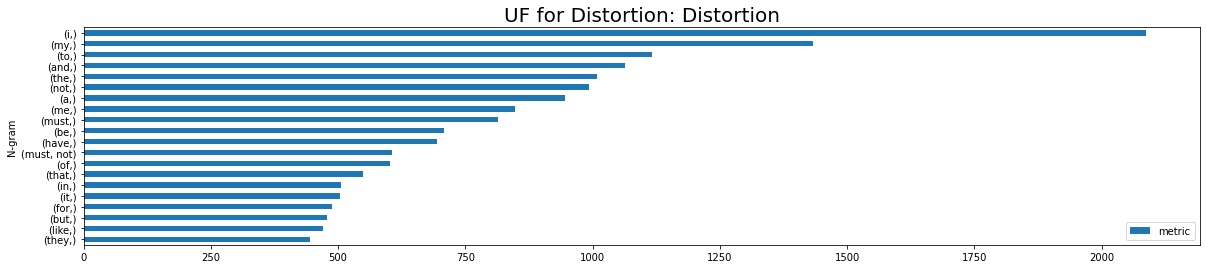

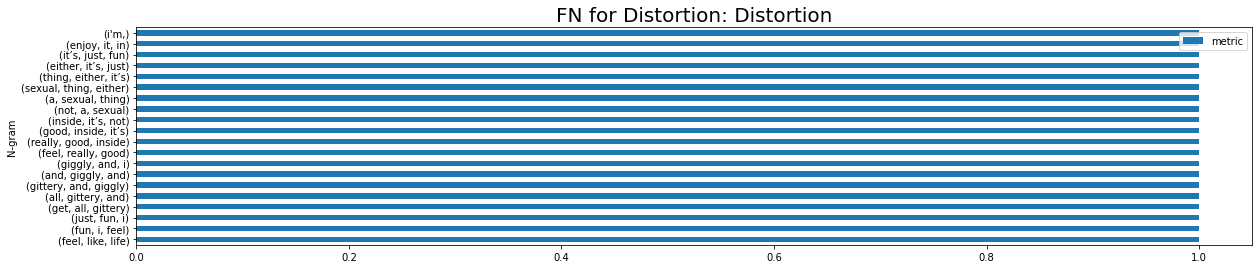

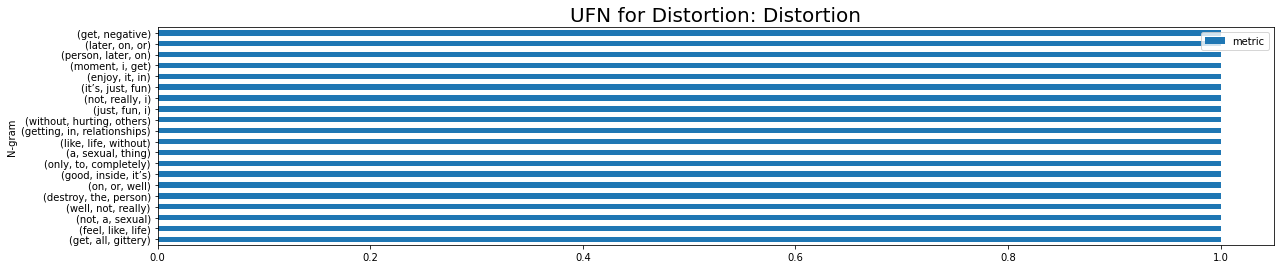

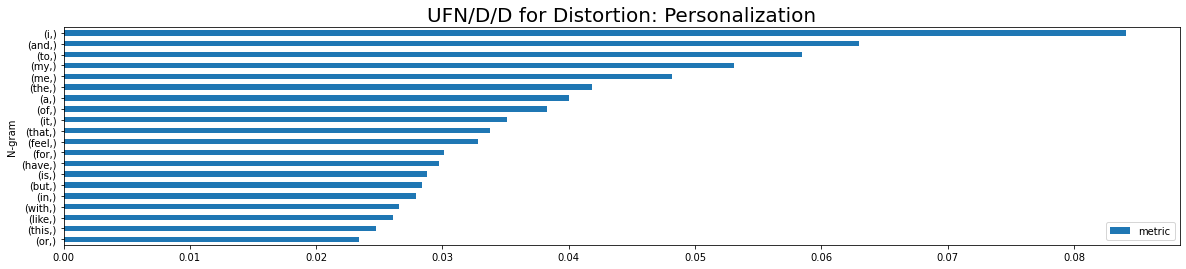

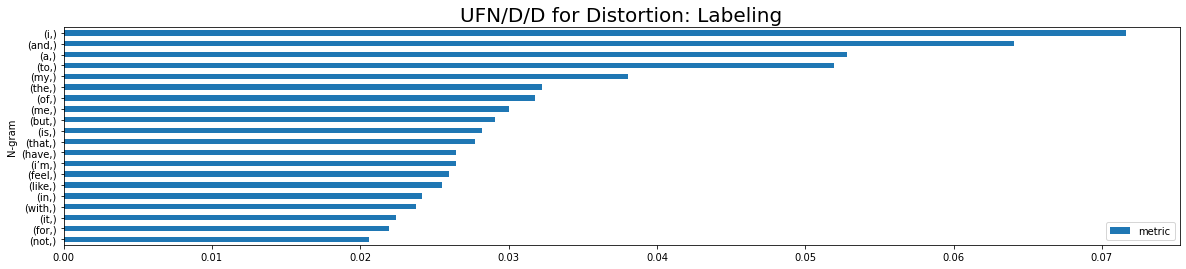

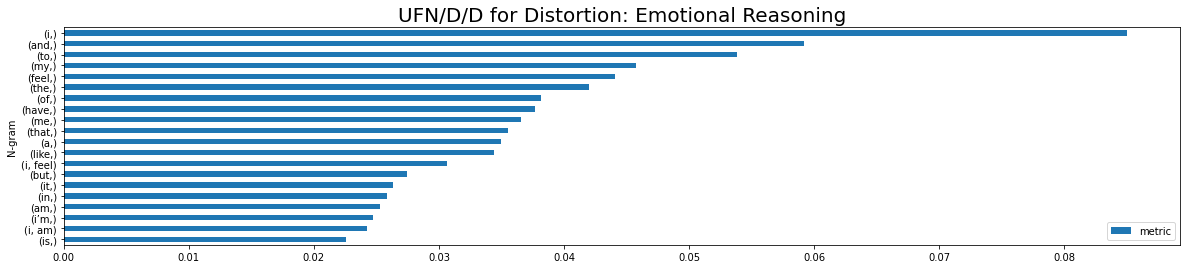

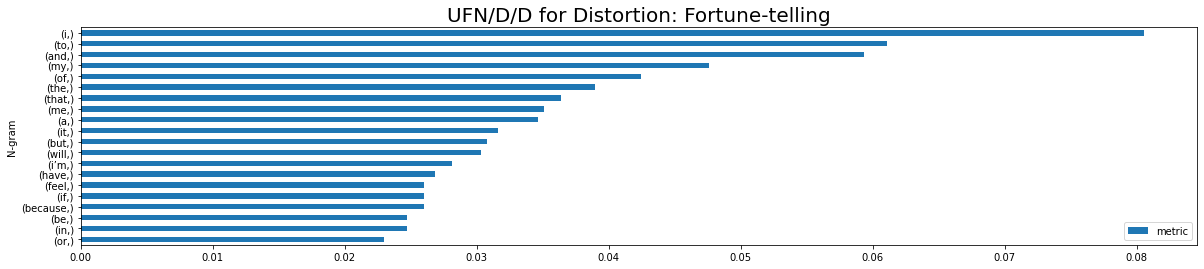

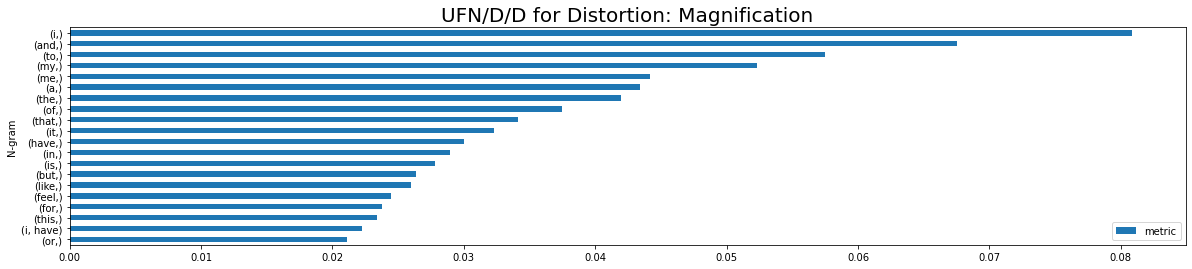

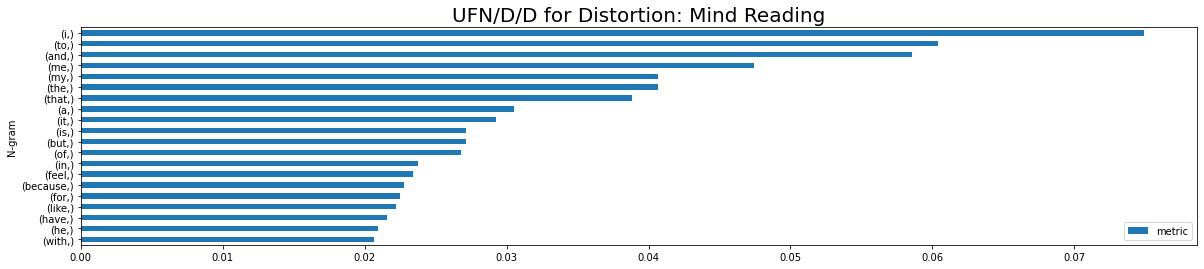

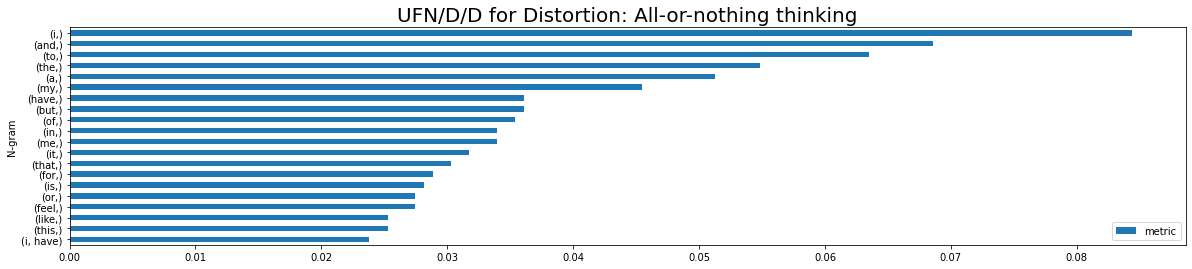

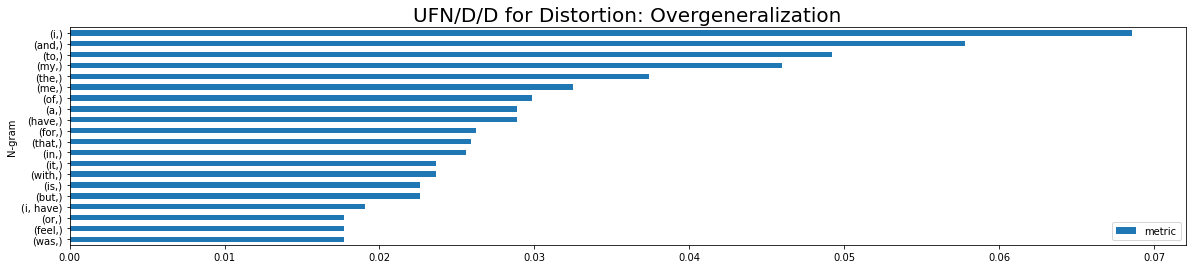

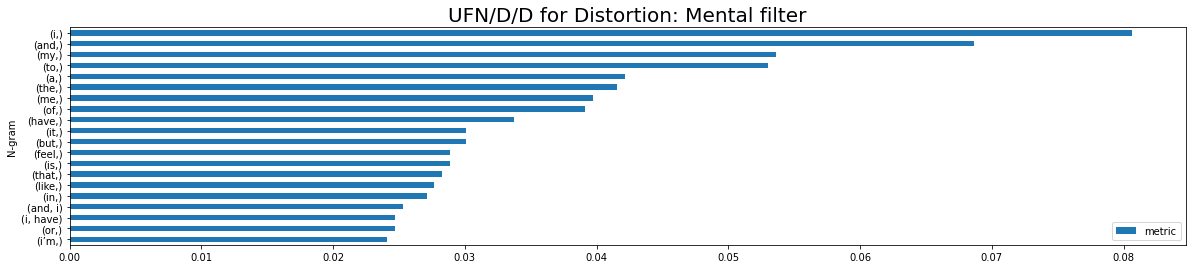

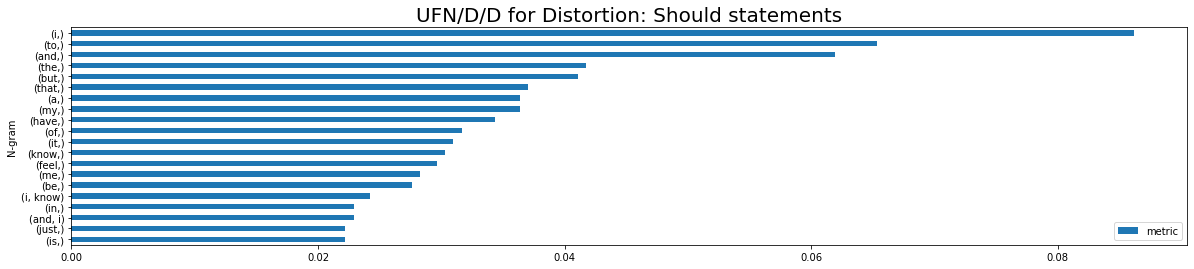

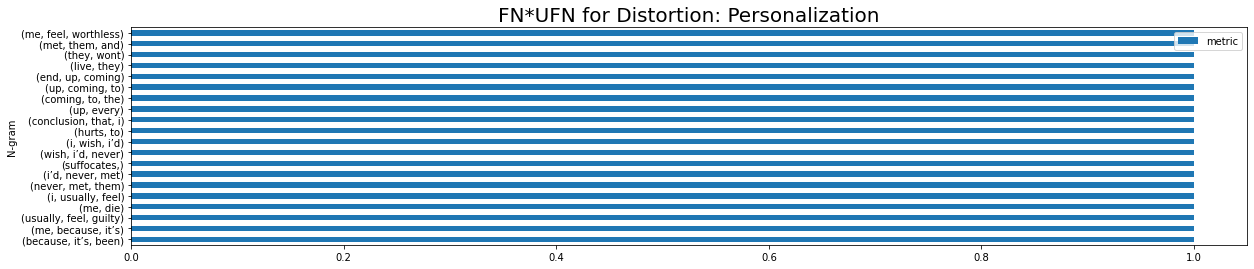

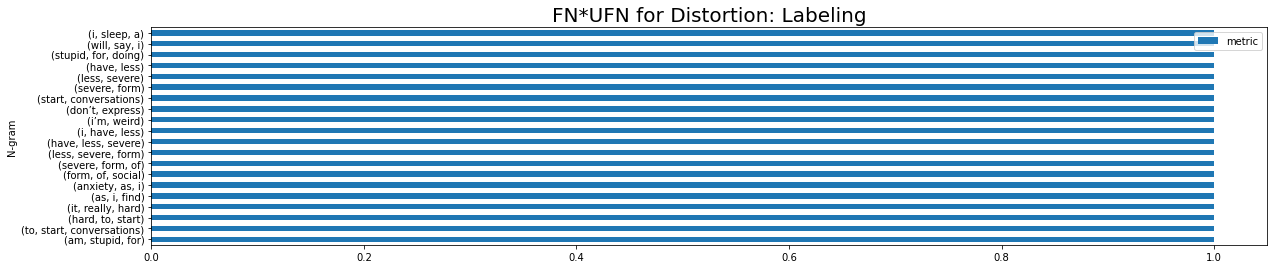

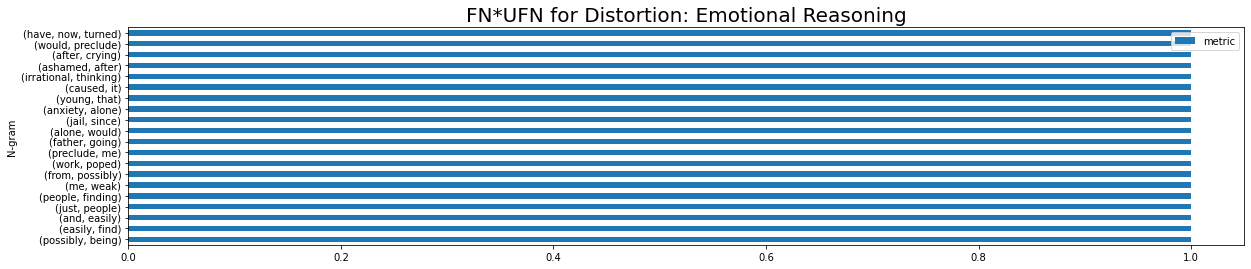

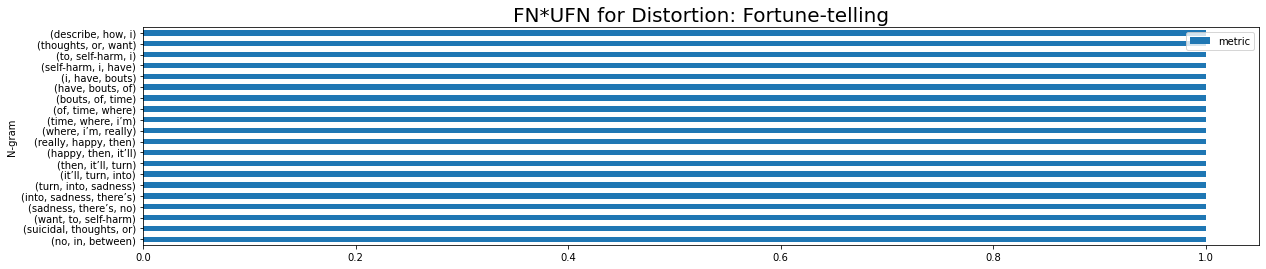

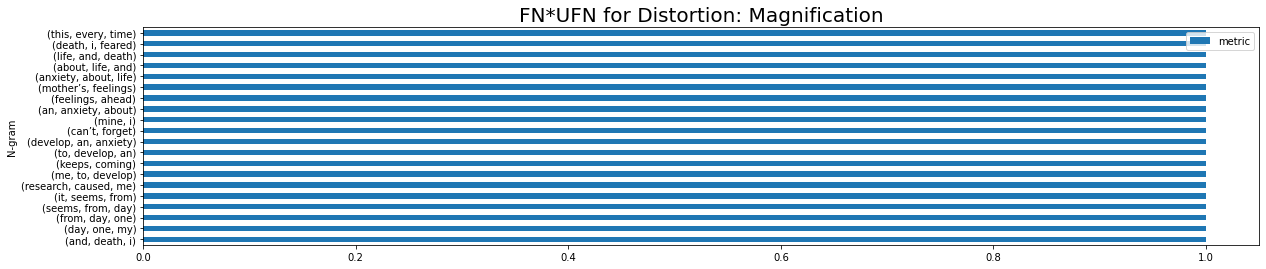

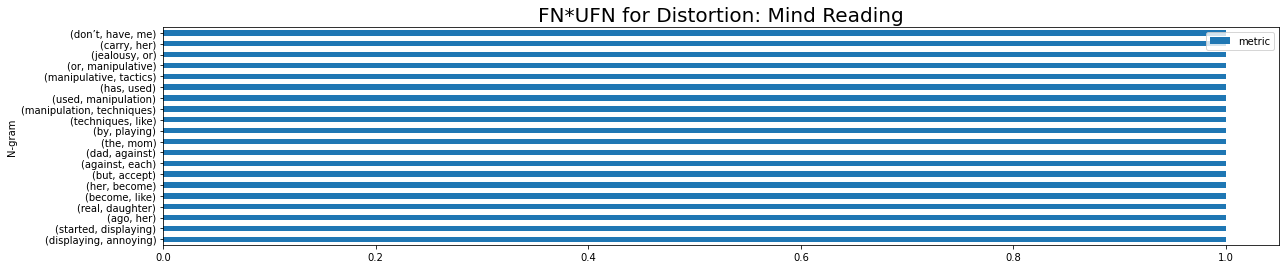

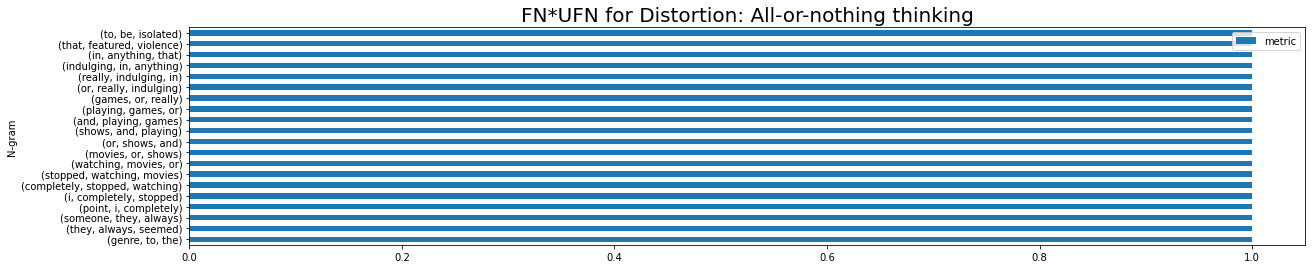

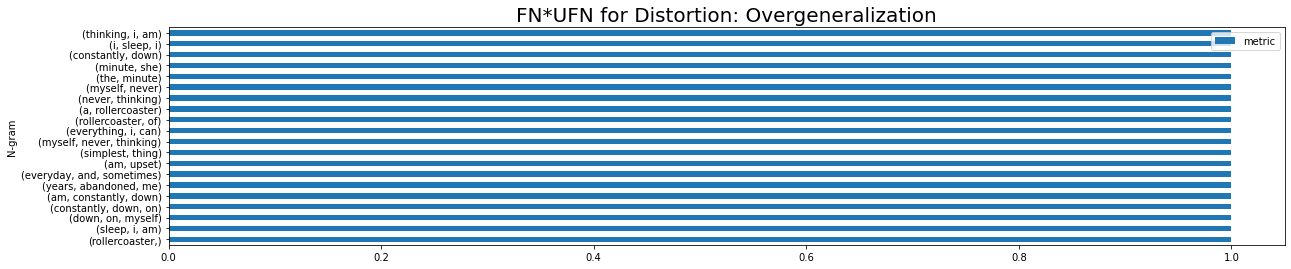

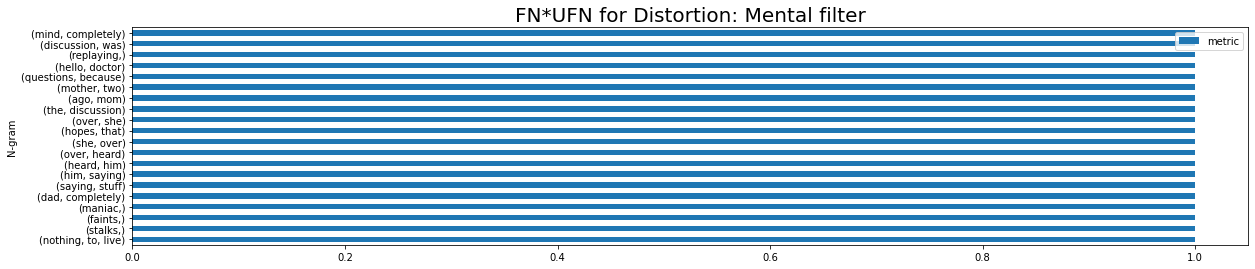

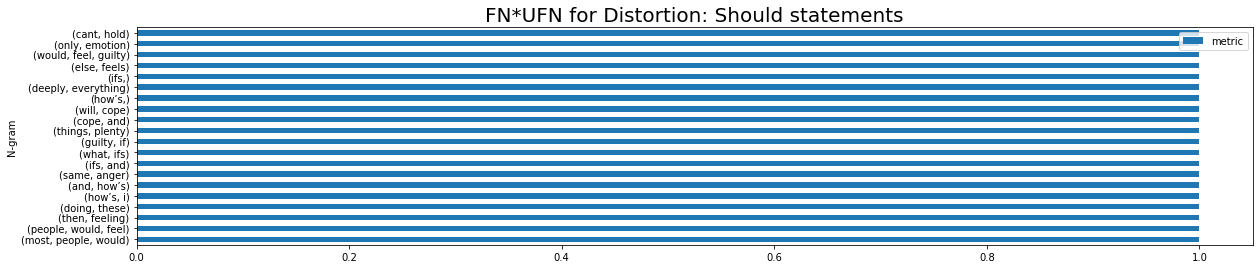

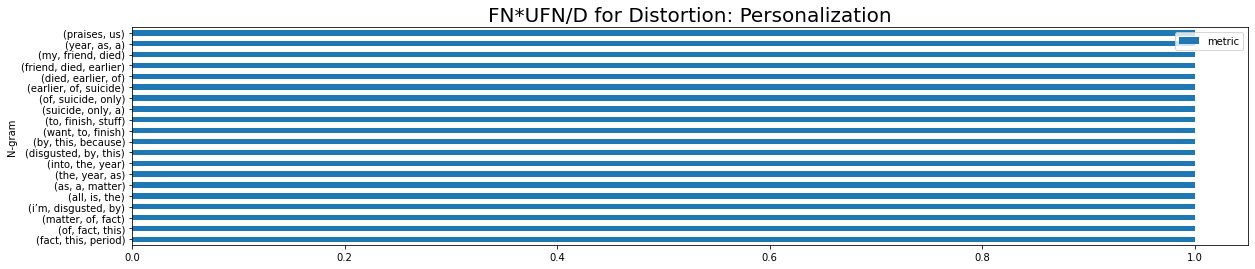

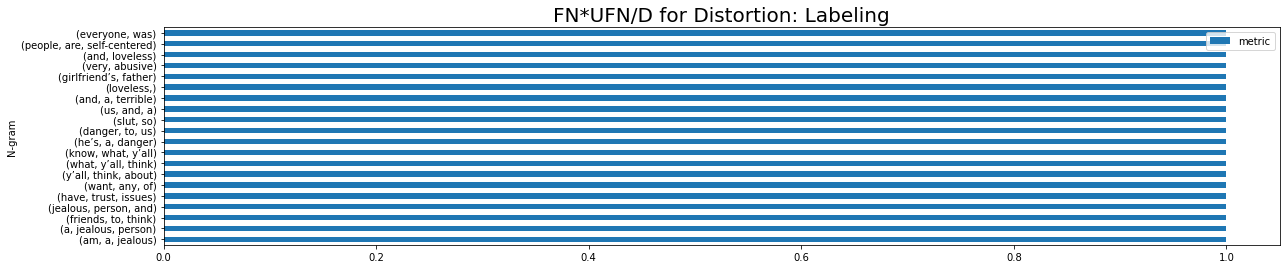

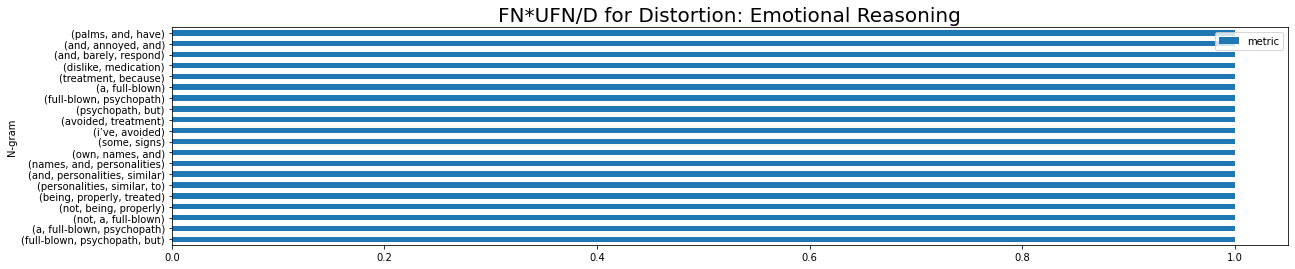

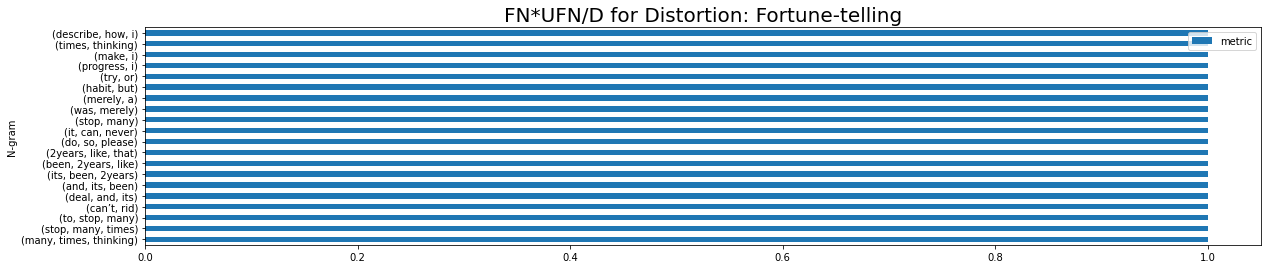

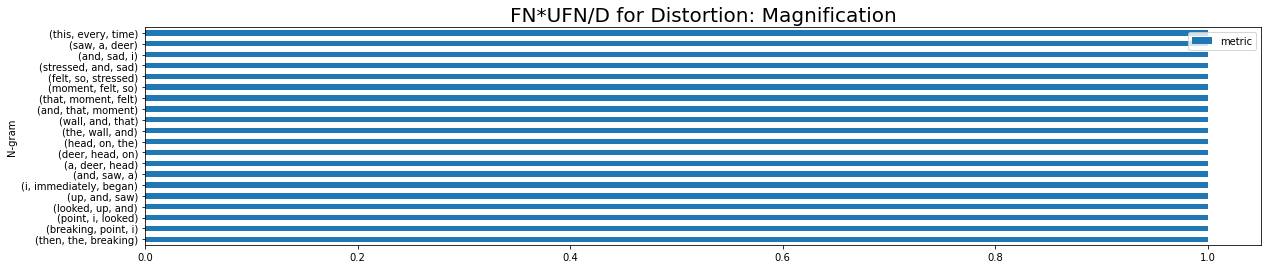

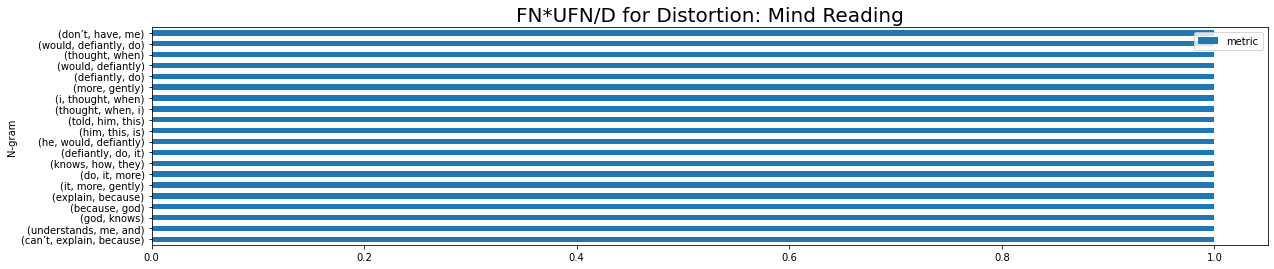

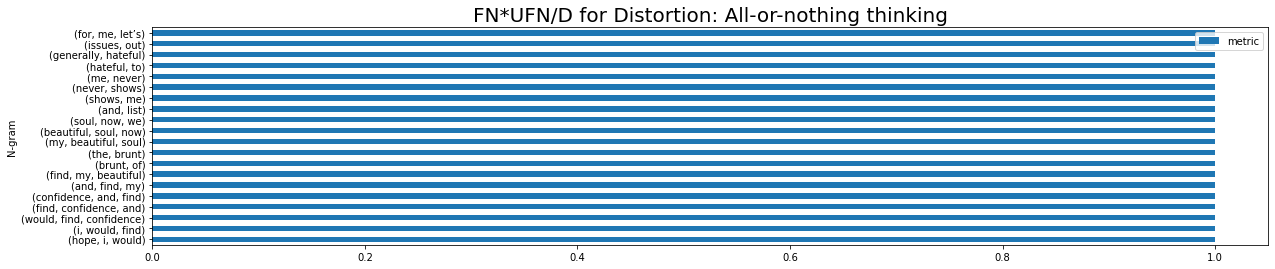

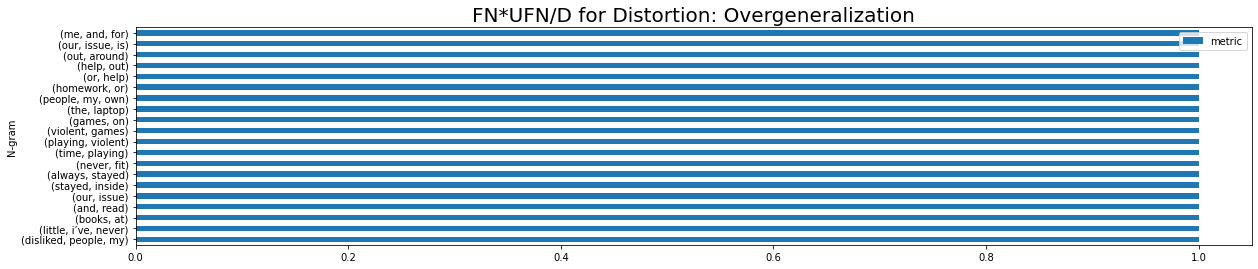

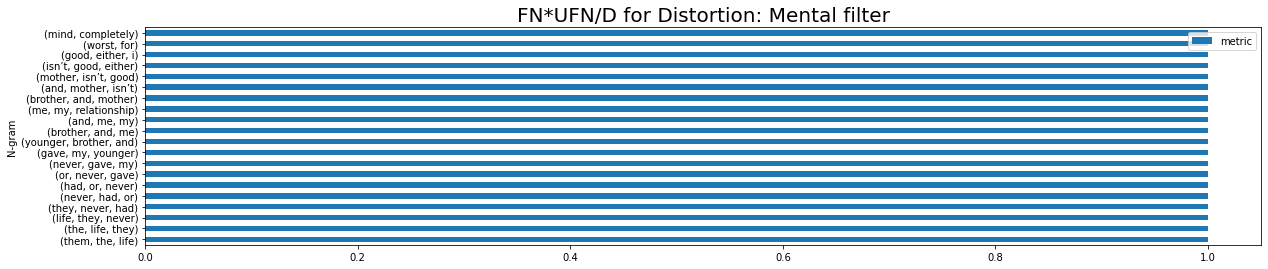

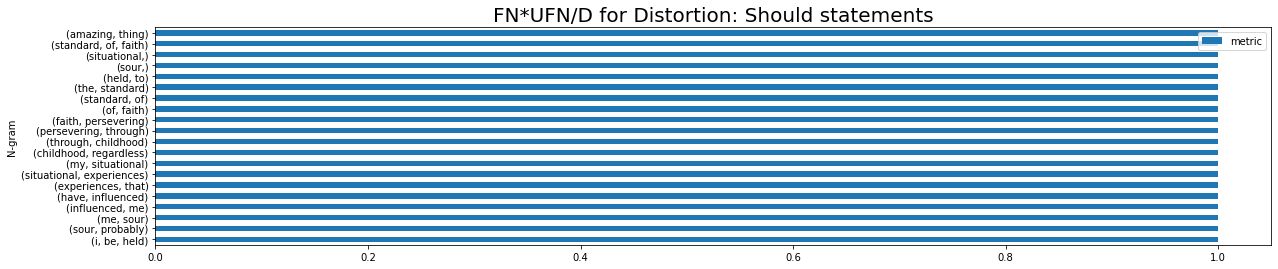

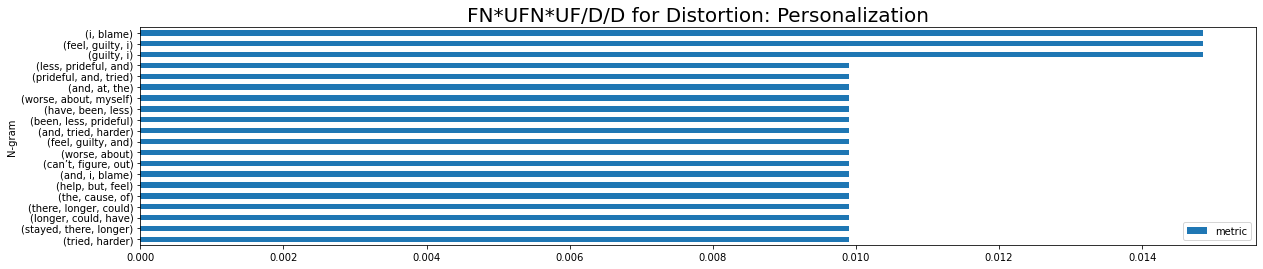

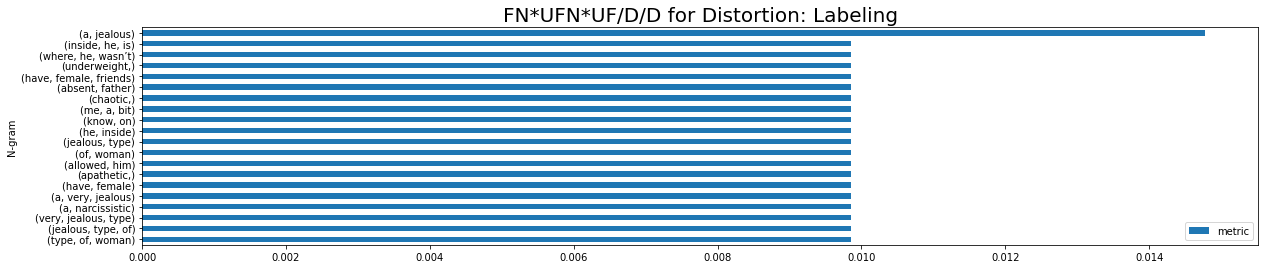

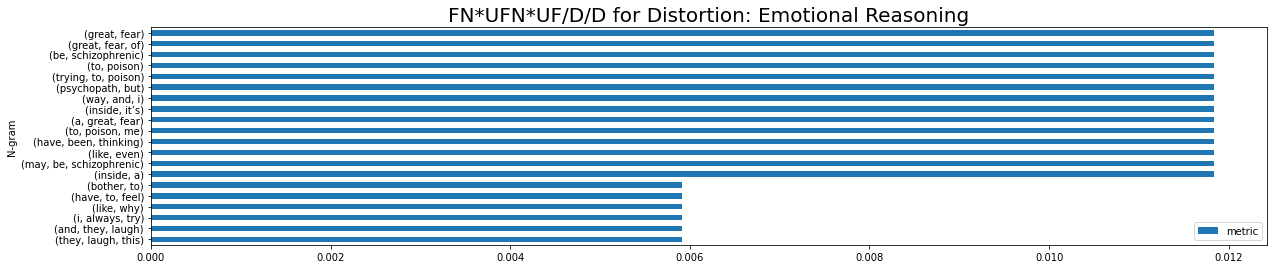

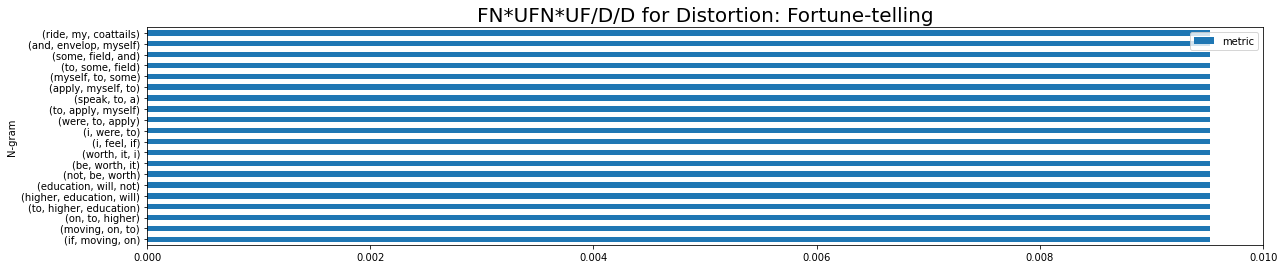

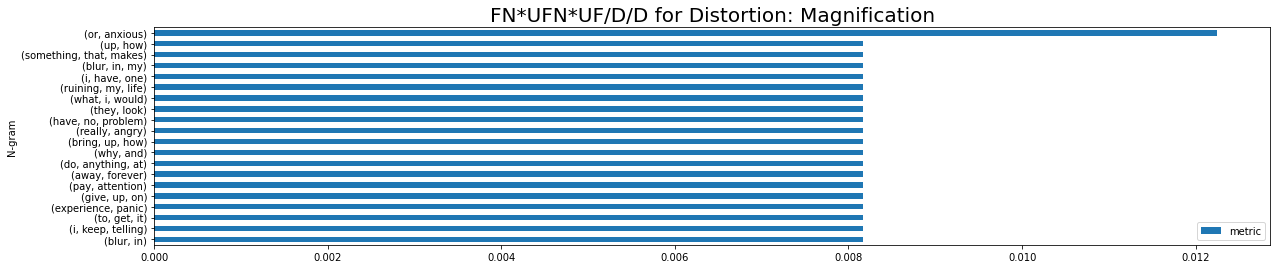

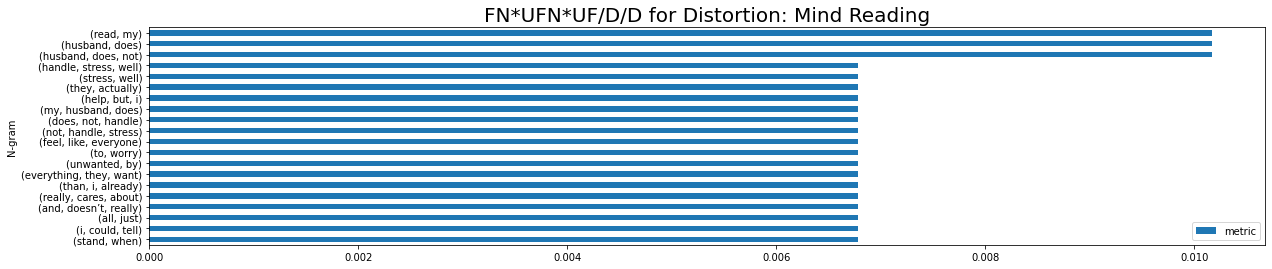

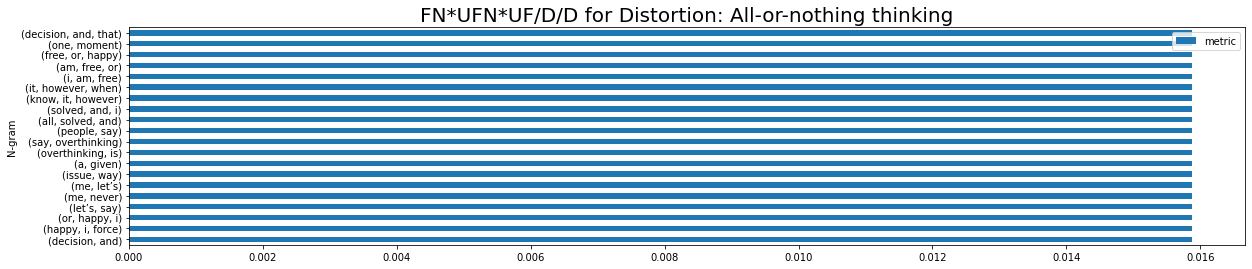

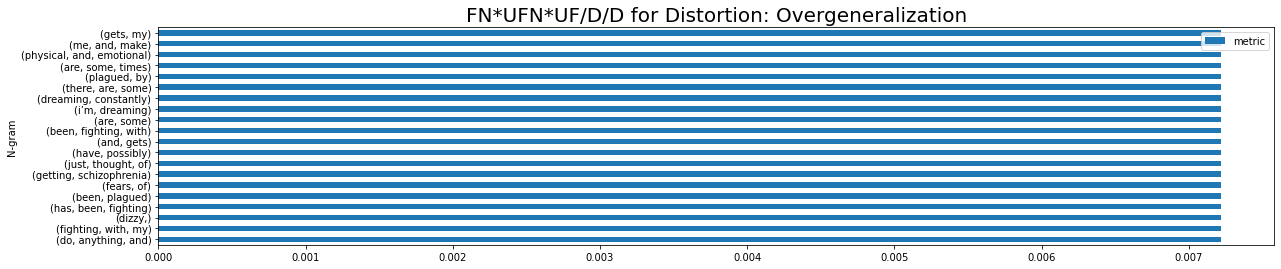

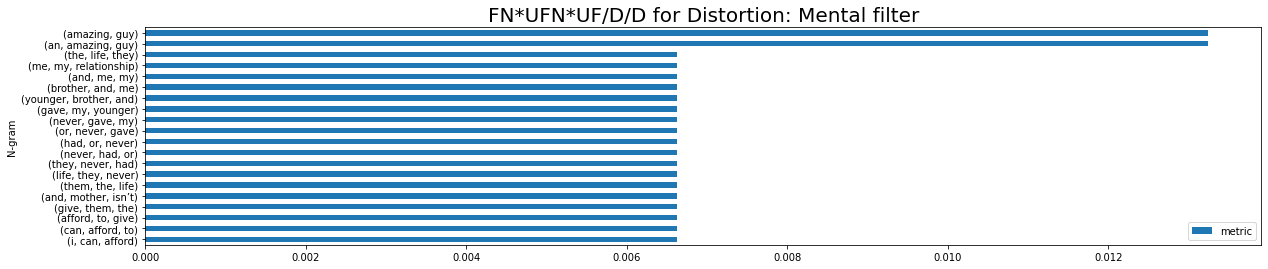

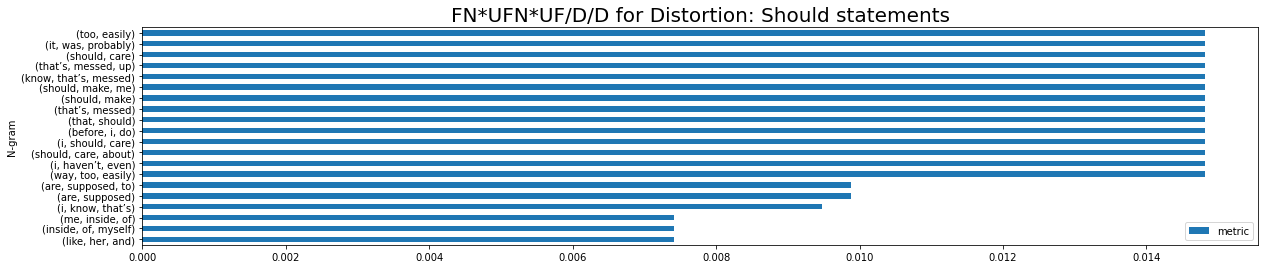

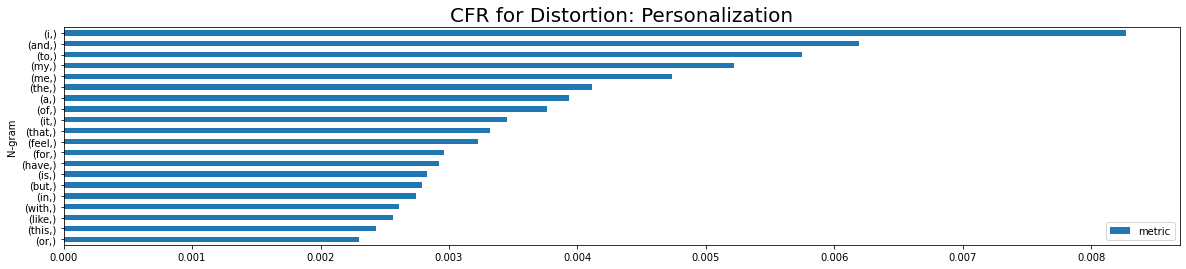

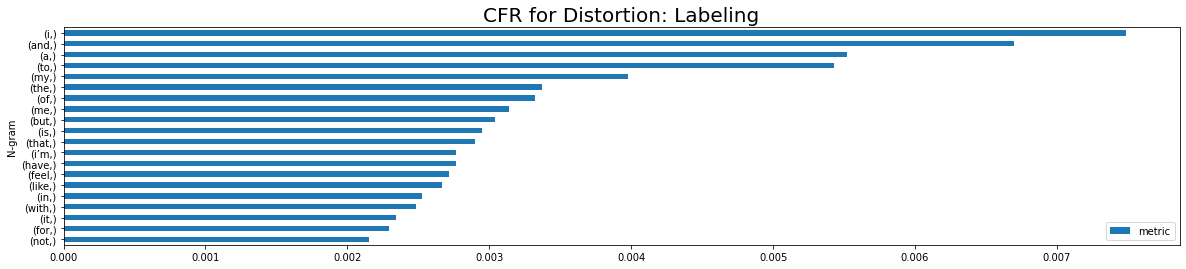

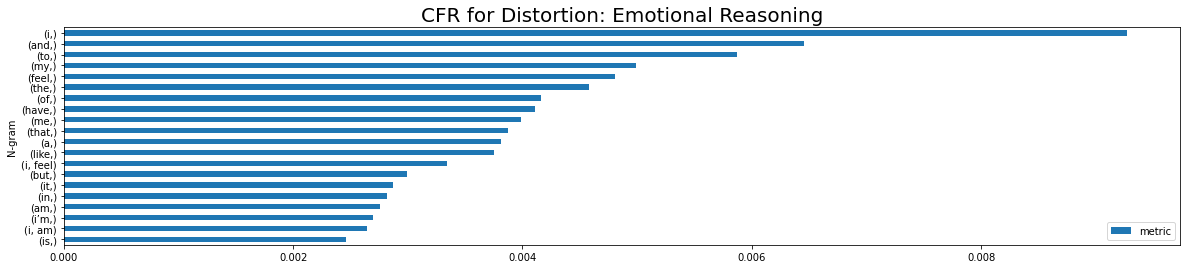

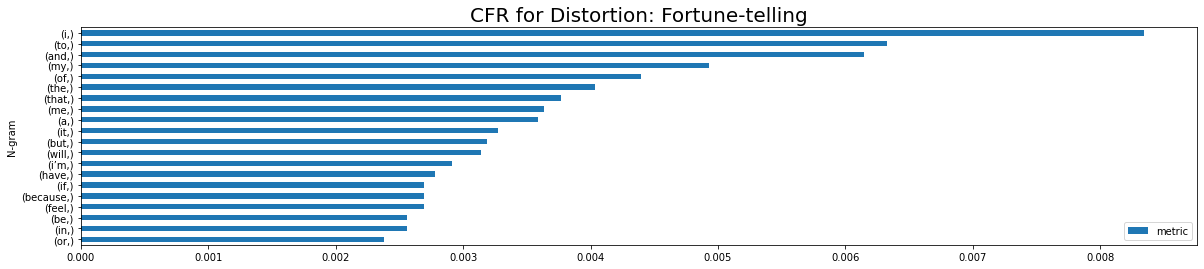

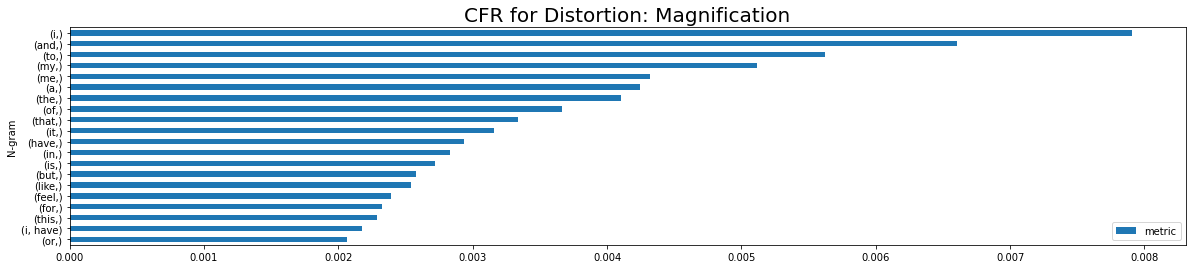

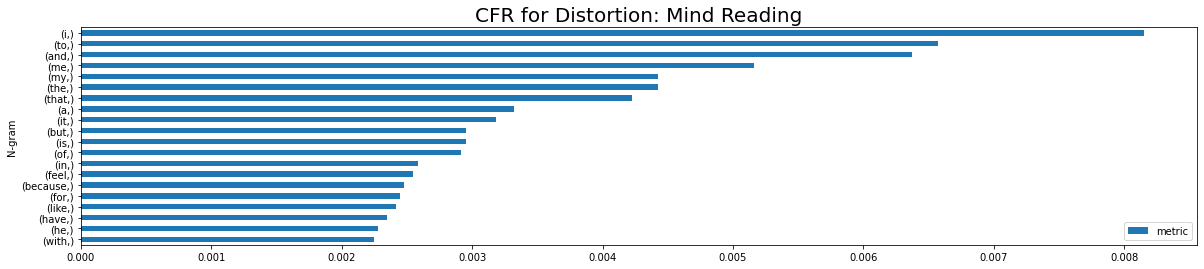

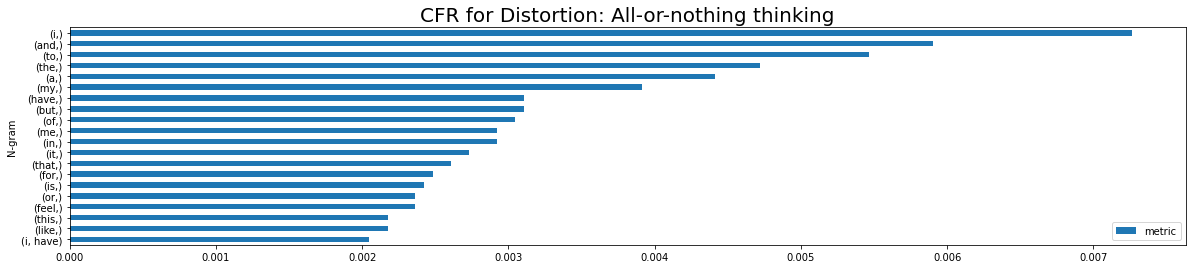

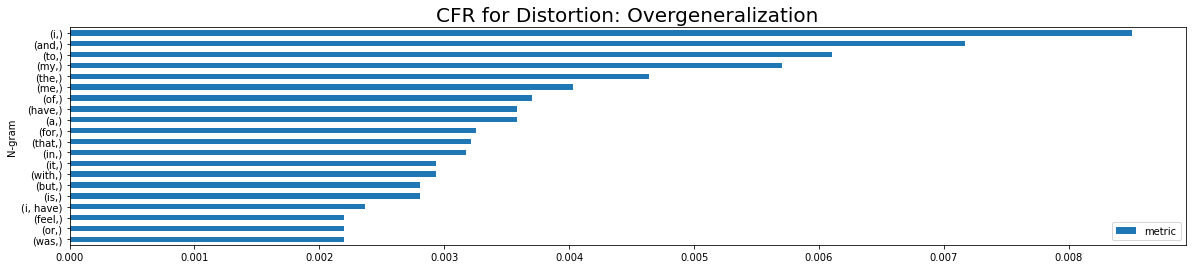

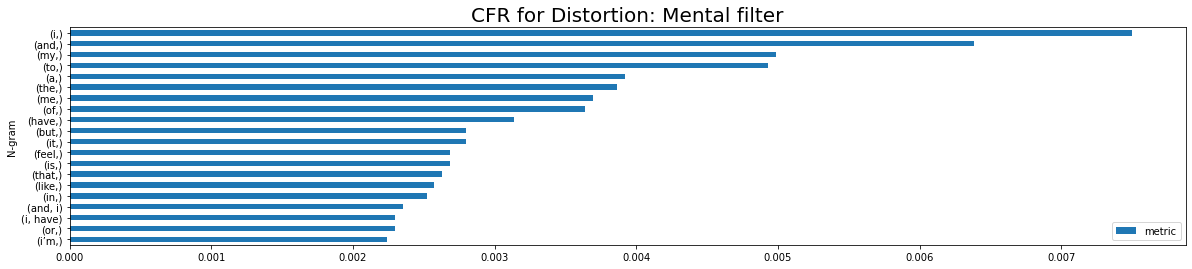

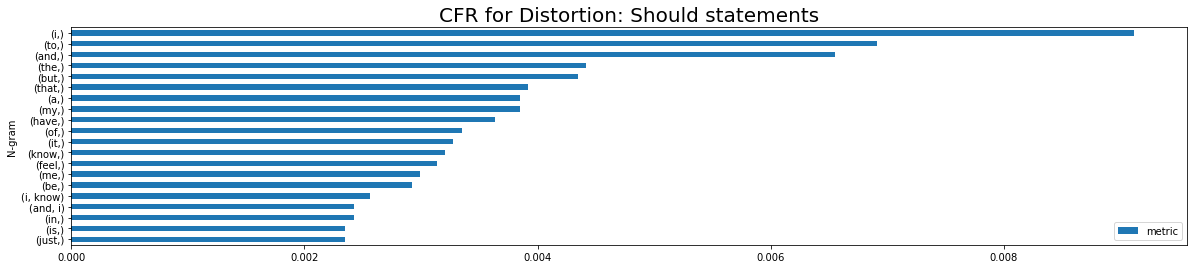

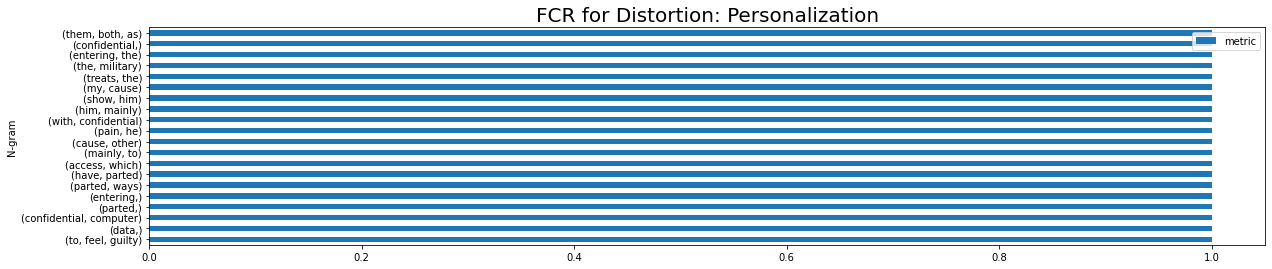

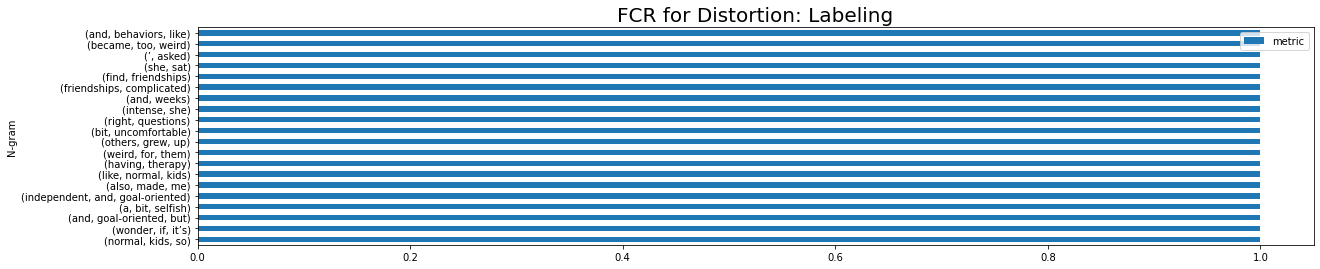

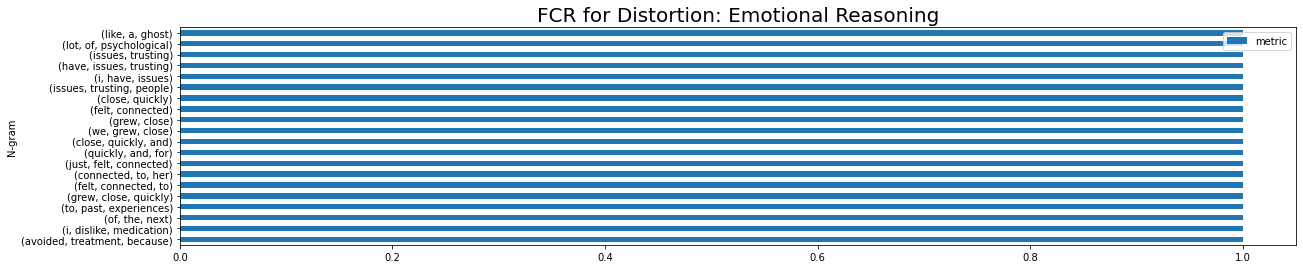

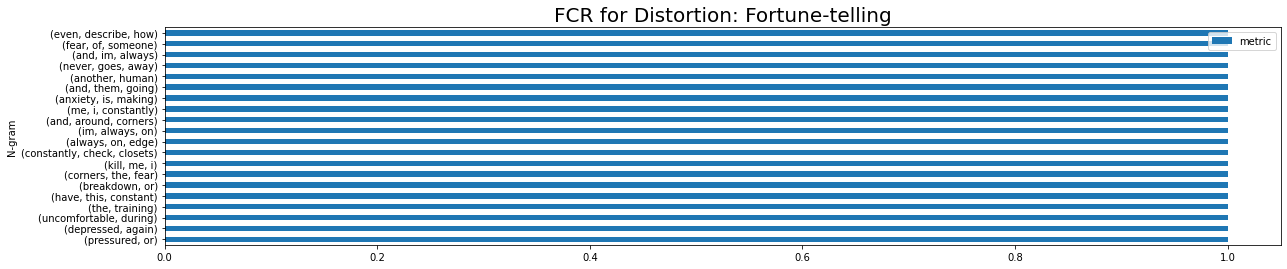

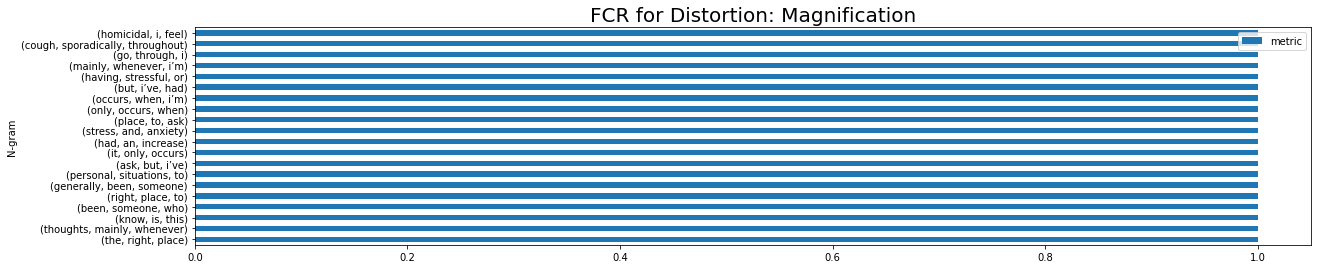

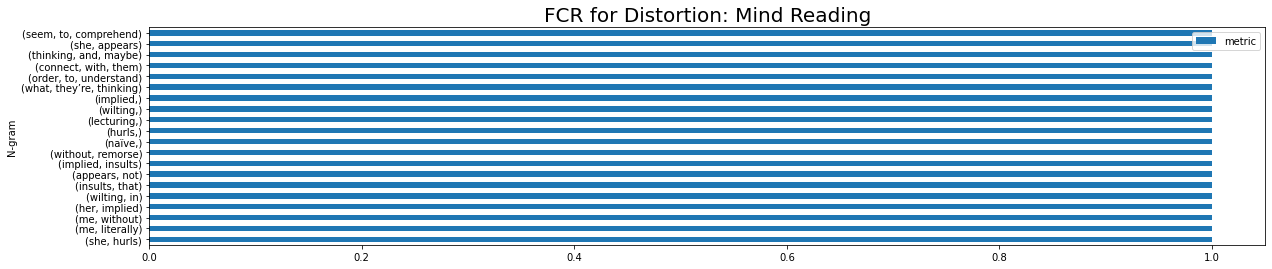

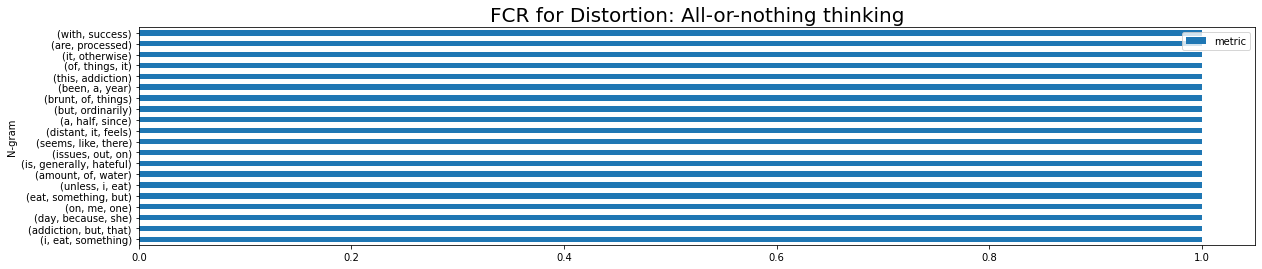

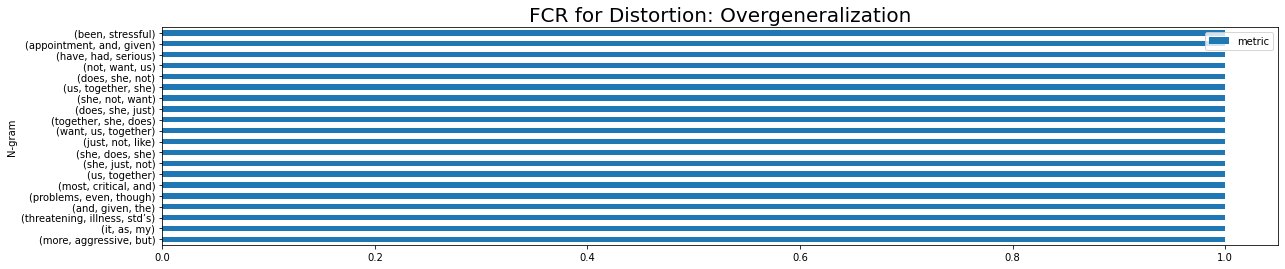

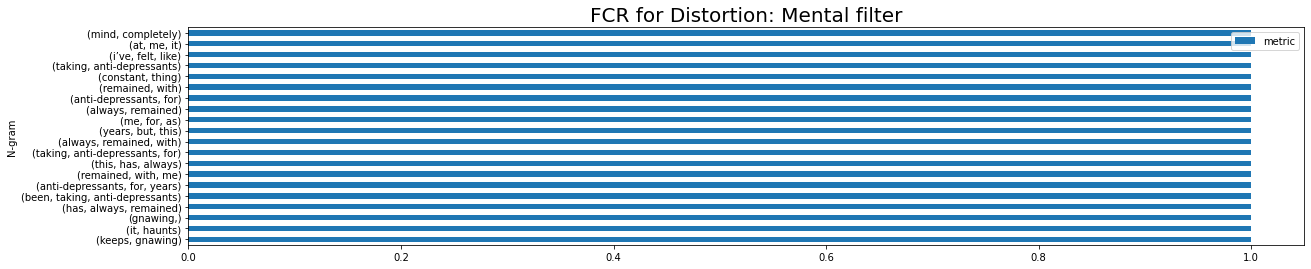

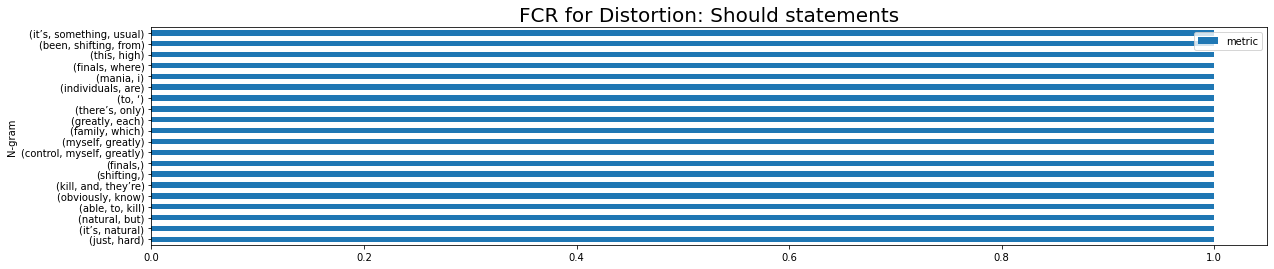

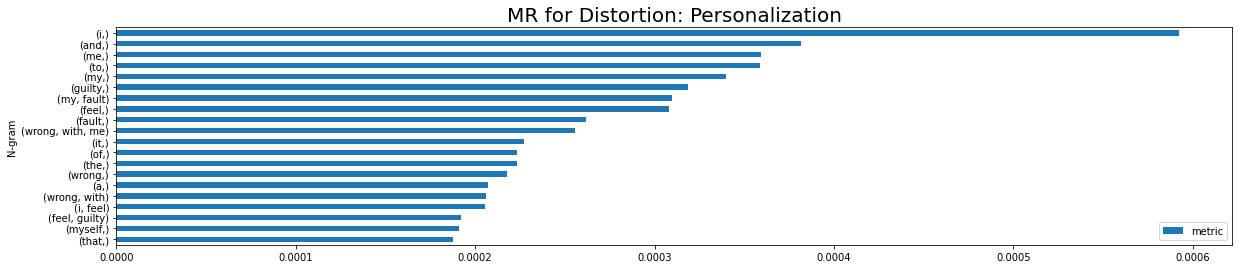

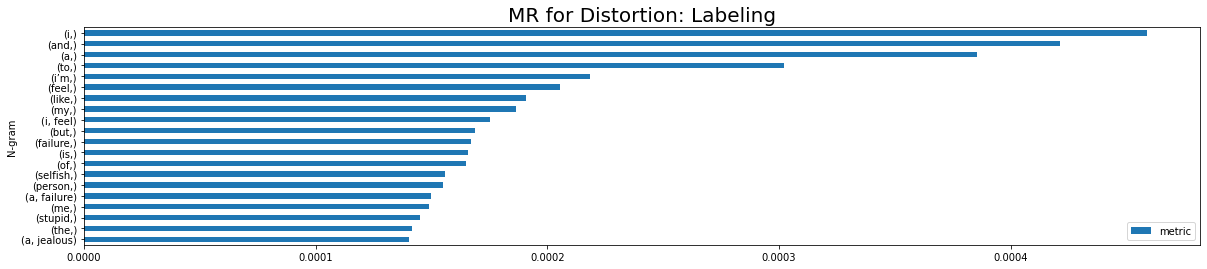

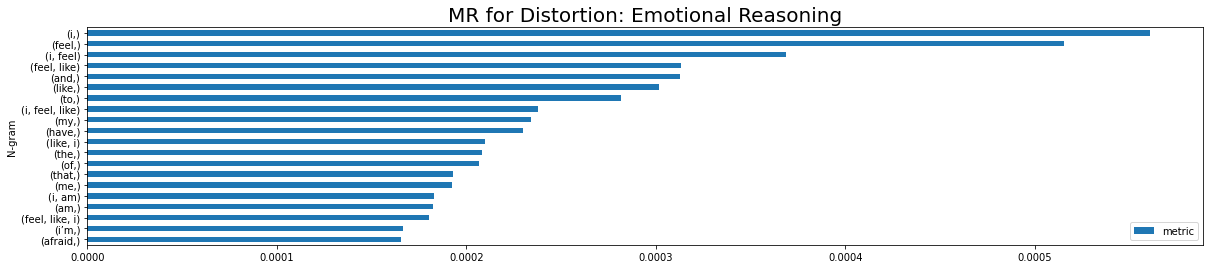

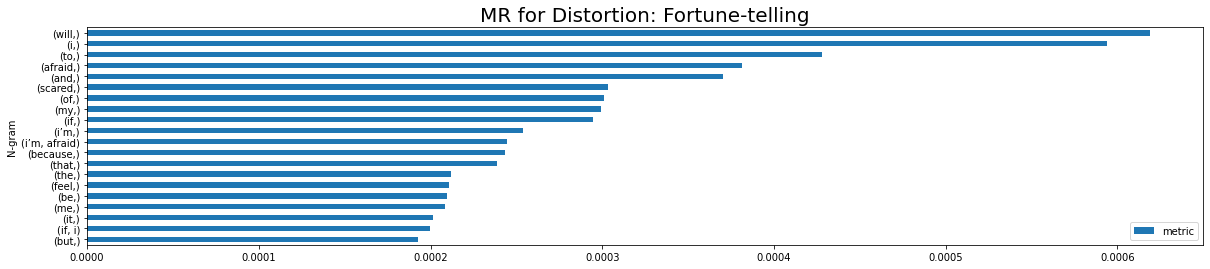

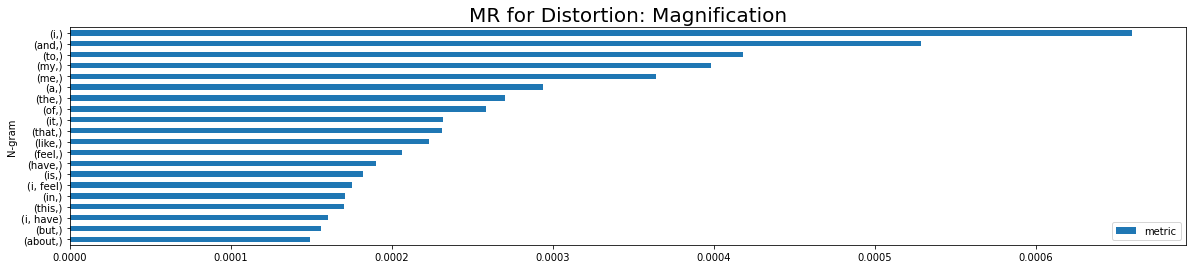

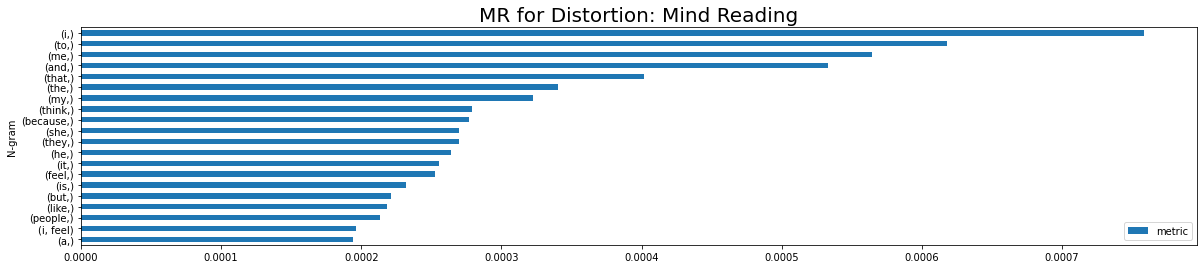

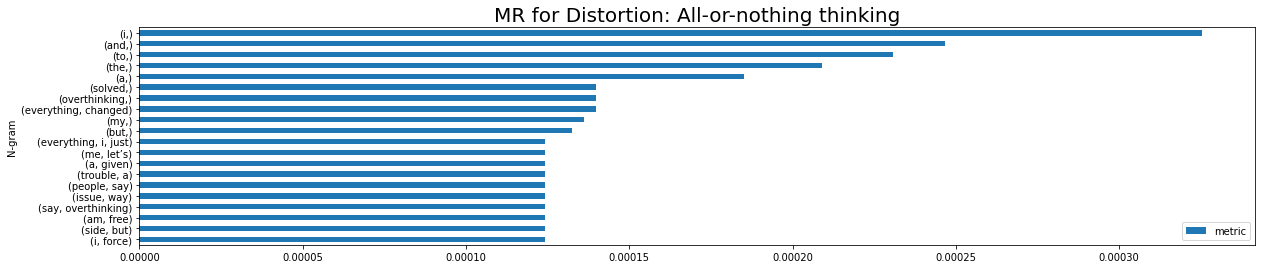

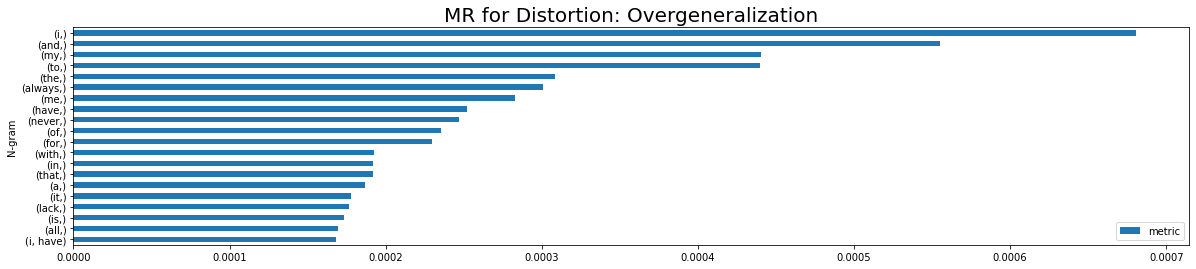

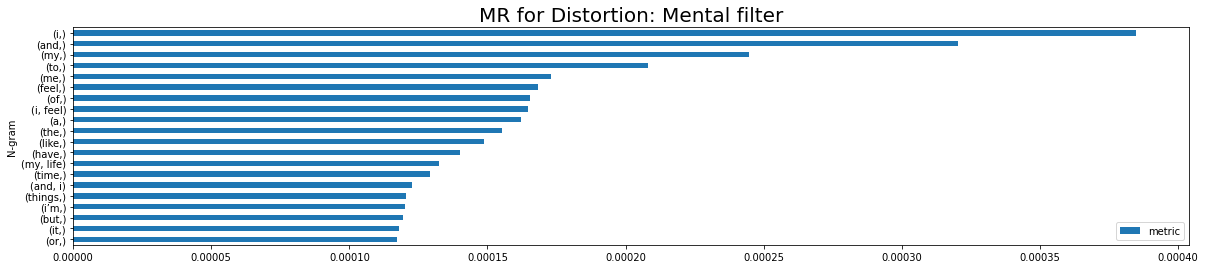

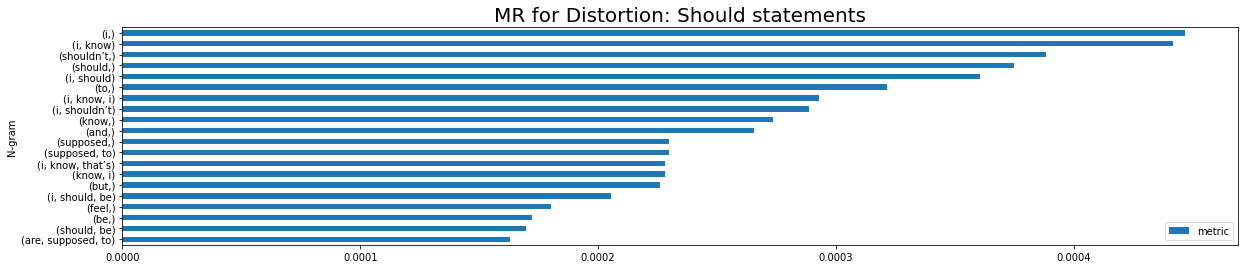

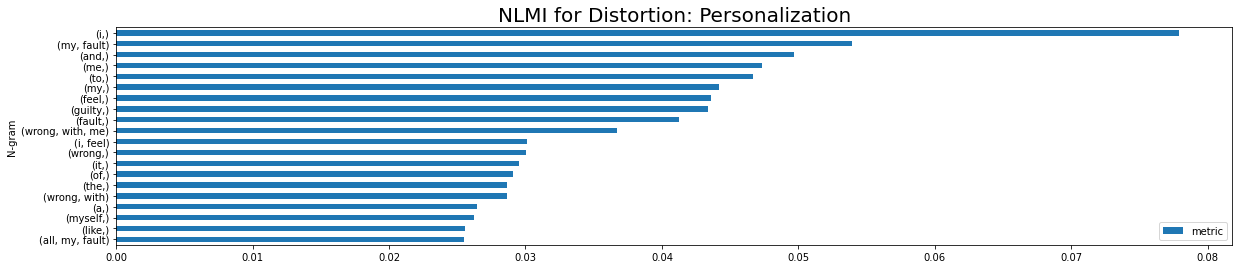

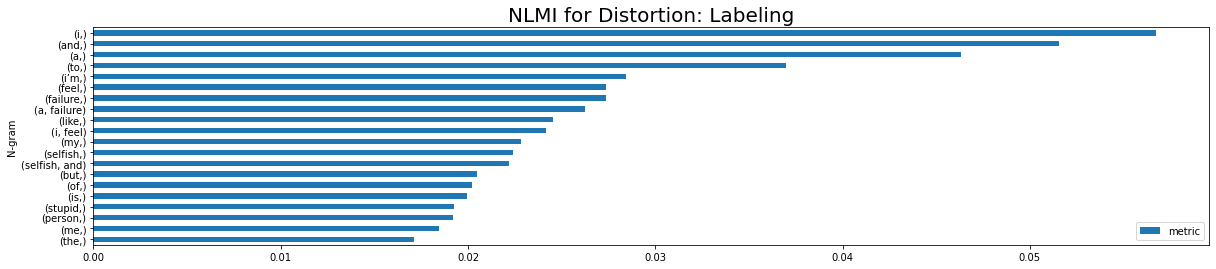

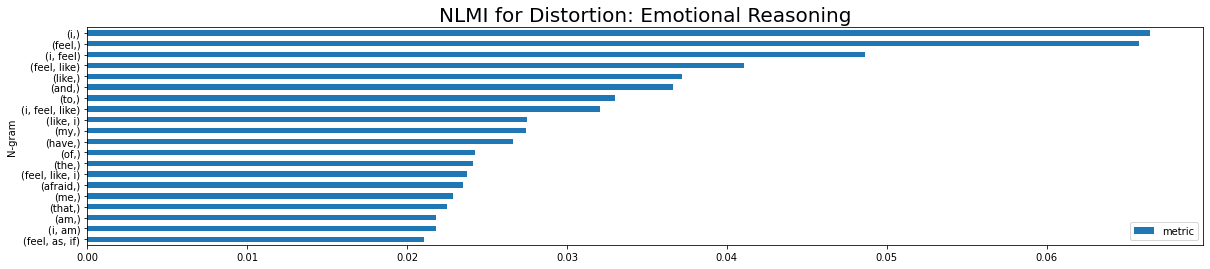

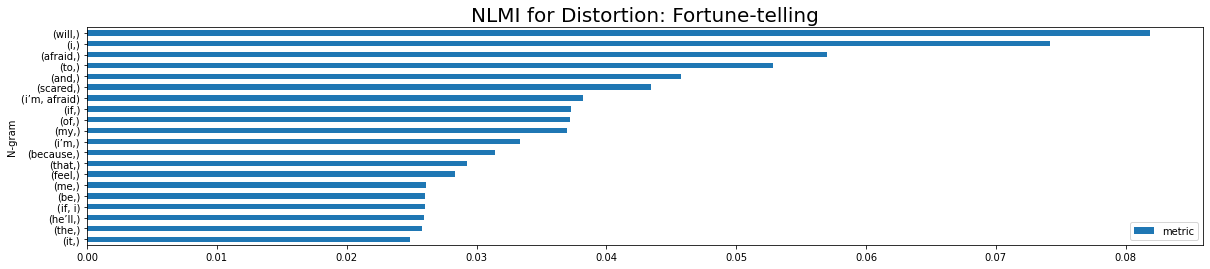

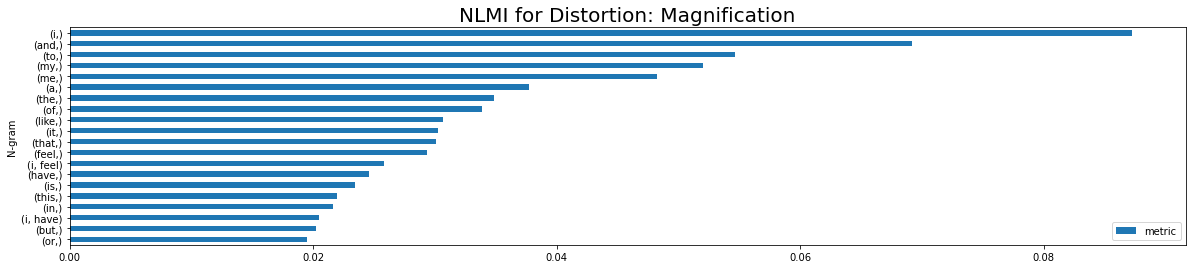

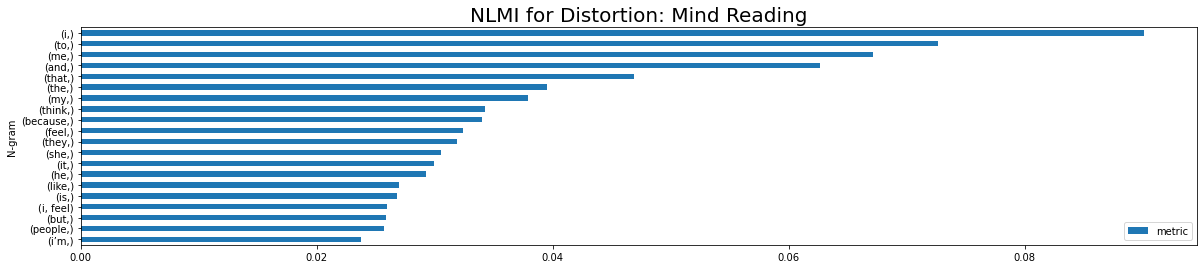

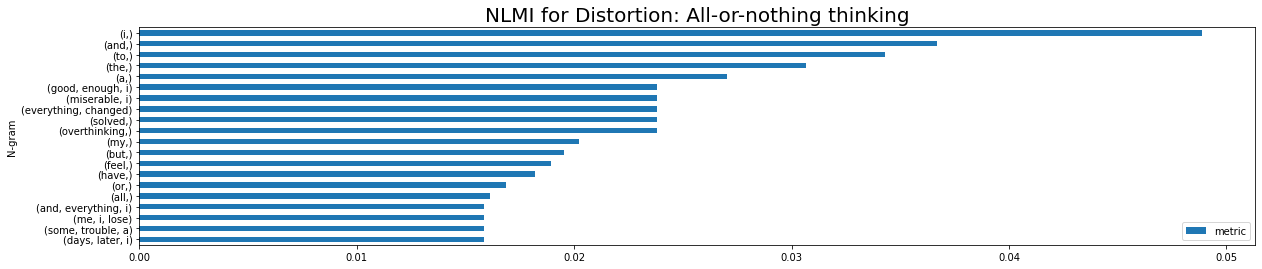

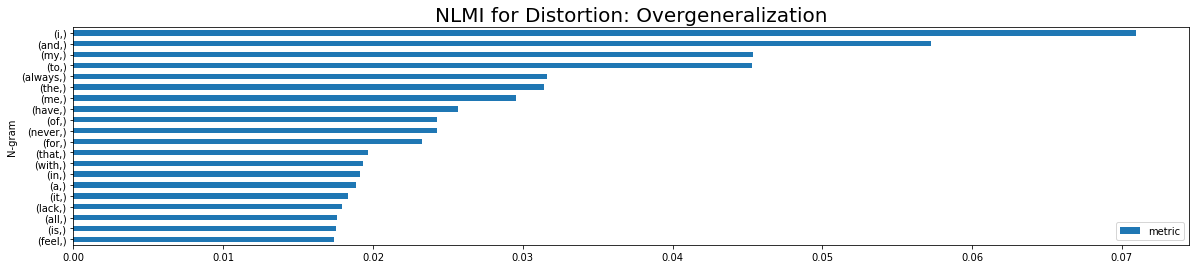

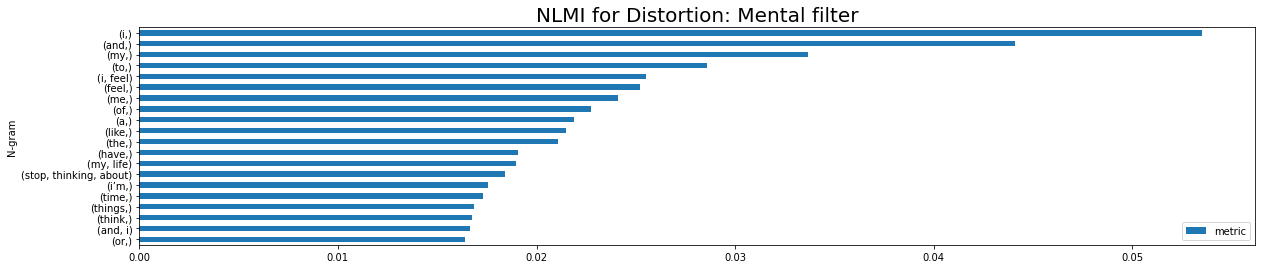

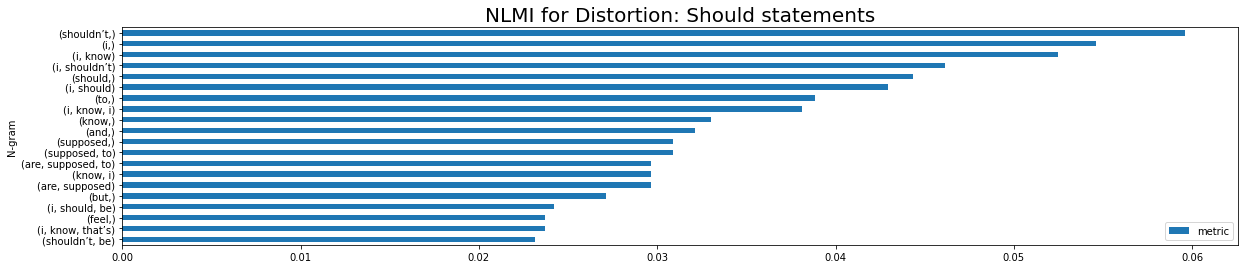

In [38]:
for selection_metric in selection_metrics:
    plot_metric(selection_metric[0],selection_metric[1],head = 20)

## Test on Multi-Class Data 

In [39]:
df = pd.read_csv(multiclass_dataset_file_path) 
df = df.drop('Id_Number', axis=1) # delete columnb with id 
df

distortions, n_gram_dicts, all_n_grams, norm_n_gram_dicts, uniq_n_gram_dicts, uniq_all_n_grams, n_gram_distortions, \
norm_uniq_n_gram_dicts, n_gram_distortions_counts, norm, norm_uniq, norm_norm_uniq, norm_norm_uniq_norm, norm_norm_uniq_norm_norm, \
fcr, cfr, mr, nl_mi, N = count_ngrams_plus(df,3)

In [40]:
df

Patient Question  \
0     Hello, I have a beautiful,smart,outgoing and a...   
1     Since I was about 16 years old I’ve had these ...   
2      So I’ve been dating on and off this guy for a...   
3     My parents got divorced in 2004. My mother has...   
4     I don’t really know how to explain the situati...   
...                                                 ...   
2525  I’m a 21 year old female. I spent most of my l...   
2526  I am 21 female and have not had any friends fo...   
2527  From the U.S.: My brother is 19 years old and ...   
2528  From the U.S.: I am a 21 year old woman who ha...   
2529  I recently moved out on my ex-roommate because...   

                                         Distorted part Dominant Distortion  \
0     The voice are always fimilar (someone she know...     Personalization   
1     I feel trapped inside my disgusting self and l...            Labeling   
2                                                   NaN       No Distortion   
3                                                   NaN       No Distortion   
4     I refused to go because I didn’t know if it wa...     Fortune-telling   
...                                                 ...                 ...   
2525                                                NaN       No Distortion   
2526  Now I am at university my peers around me all ...  Overgeneralization   
2527  He claims he’s severely depressed and has outb...       Mental filter   
2528                                                NaN       No Distortion   
2529                                                NaN       No Distortion   

     Secondary Distortion (Optional)  
0                                NaN  
1                Emotional Reasoning  
2                                NaN  
3                                NaN  
4                Emotional Reasoning  
...                              ...  
2525                             NaN  
2526                             NaN  
2527                    Mind Reading  
2528                             NaN  
2529                             NaN  

[2530 rows x 4 columns]

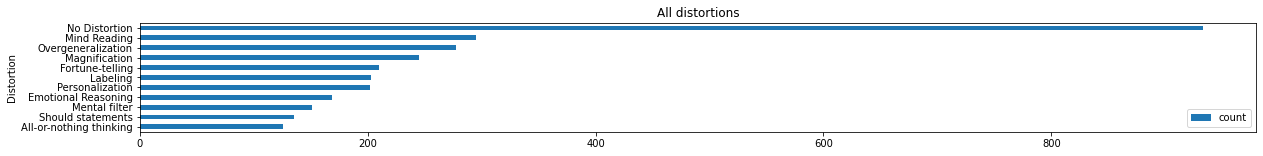

In [41]:
# Display graphs for all distortions
plot_dict(
            distortions,
            labels="Distortion",
            values="count",
            title=f"All distortions",
            head=20             # All
        )


In [44]:
selection_metrics = [
    (frequency,'F'),
    (unique_frequency,'UF'),
    (frequency_self_normalized,'FN'),
    (unique_frequency_self_normalized,'UFN'),
    (norm_uniq_n_gram_dicts,'UFN/D/D'),
    (norm_norm_uniq,'FN*UFN'),
    (norm_norm_uniq_norm,'FN*UFN/D'),
    (norm_norm_uniq_norm_norm,'FN*UFN*UF/D/D'),
    (cfr,'CFR'),
    (fcr,'FCR'),
    (mr,'MR'),
    (nl_mi,'NLMI')
]

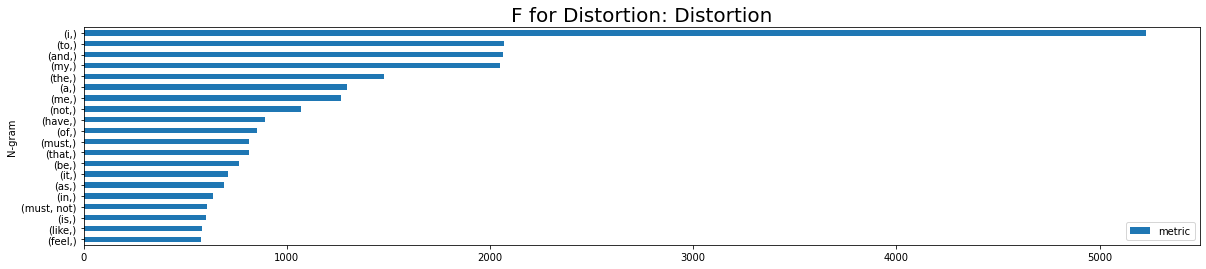

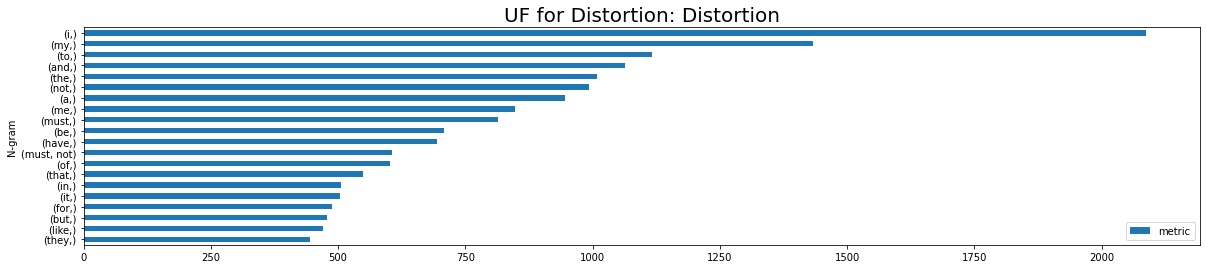

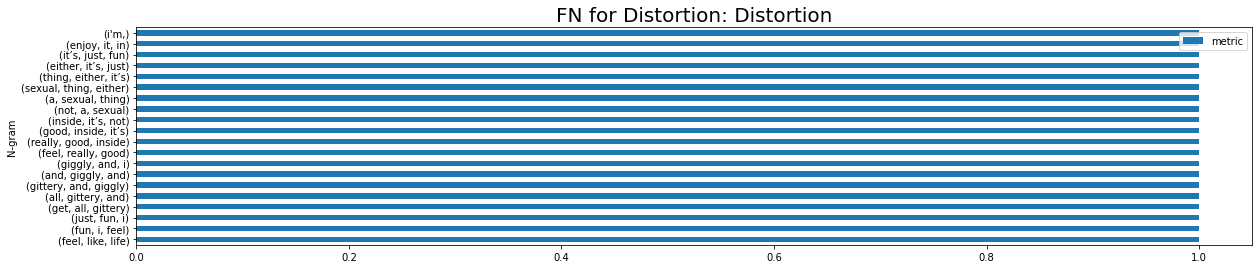

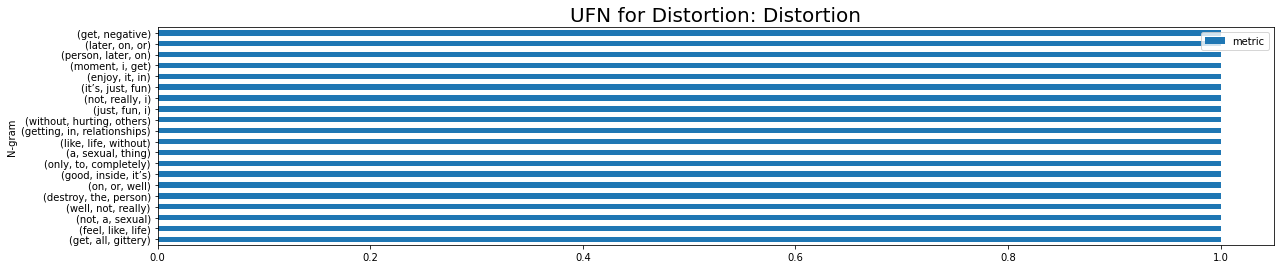

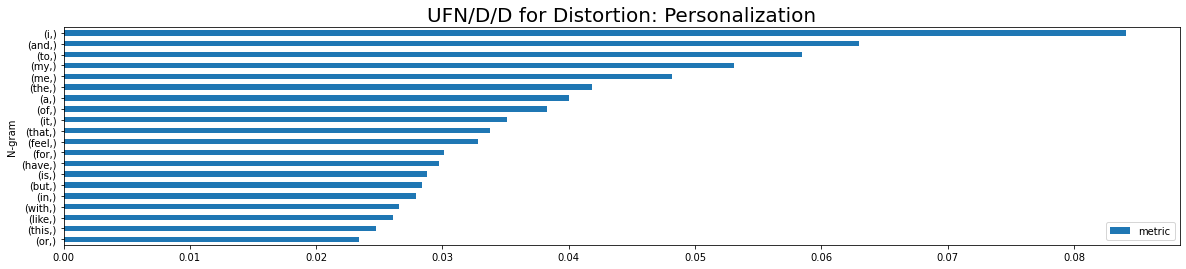

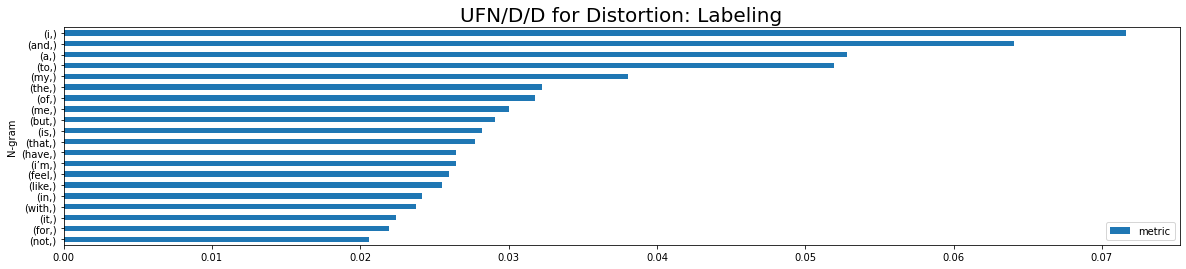

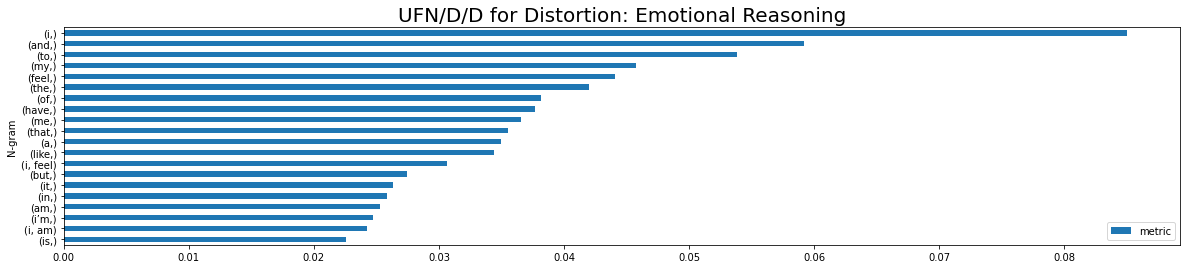

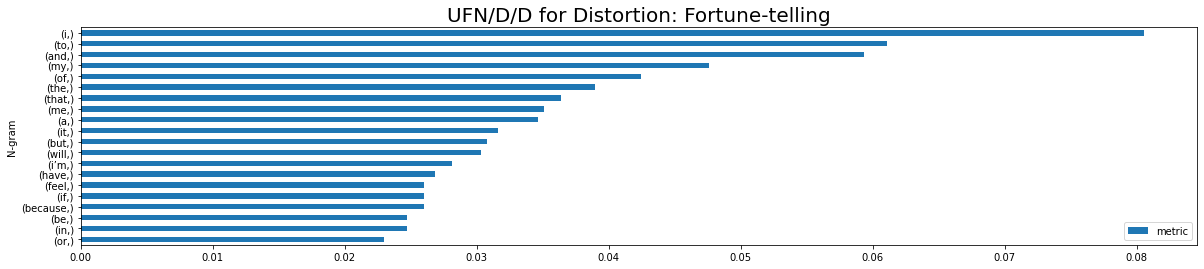

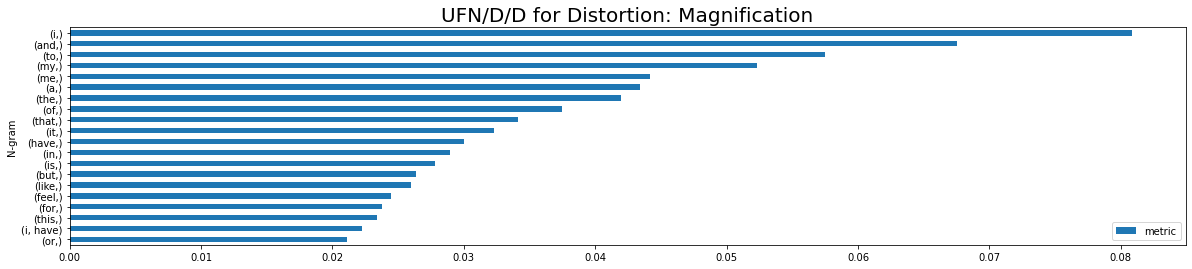

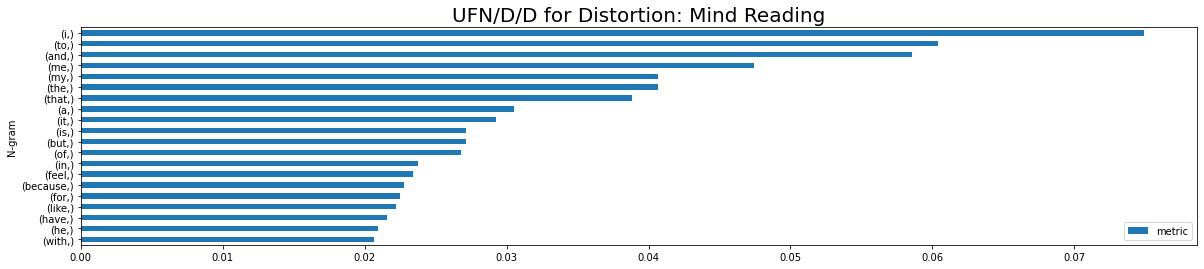

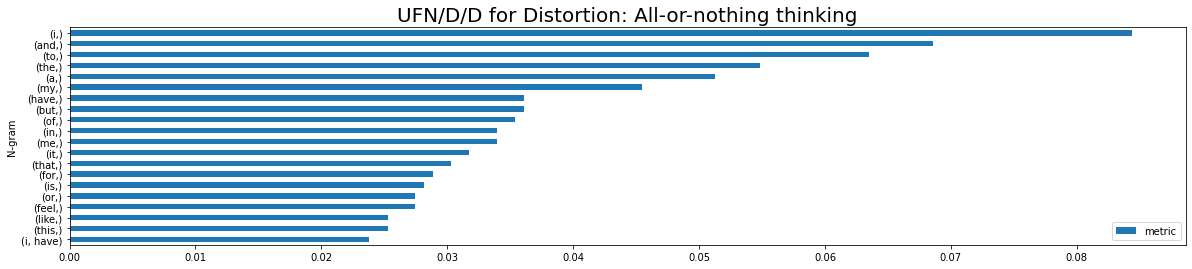

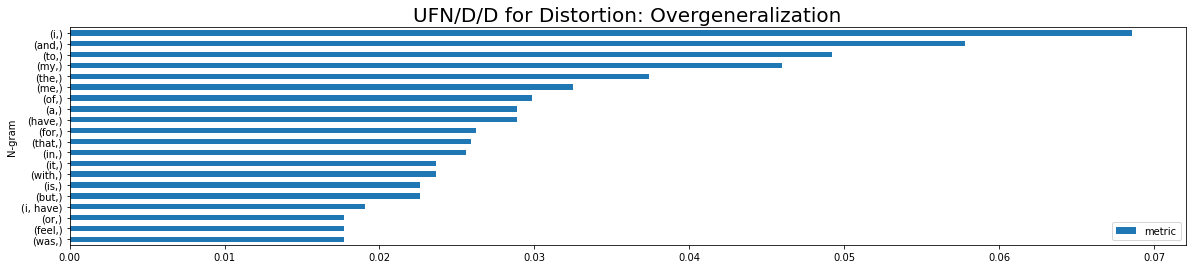

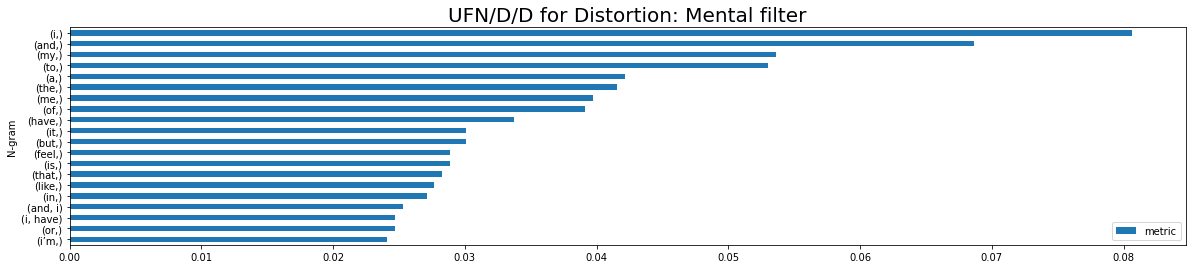

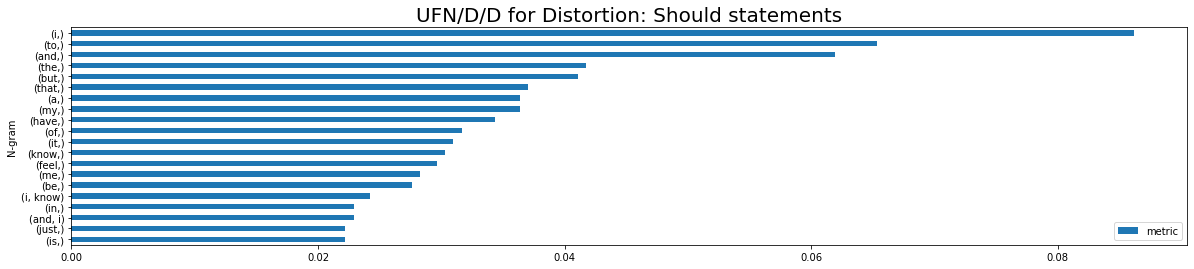

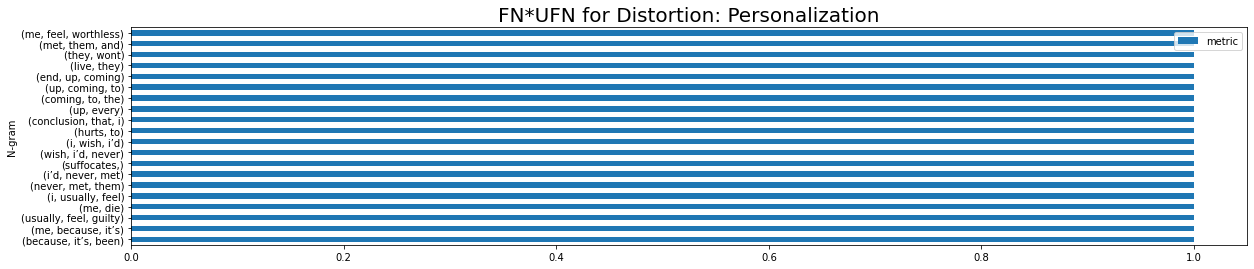

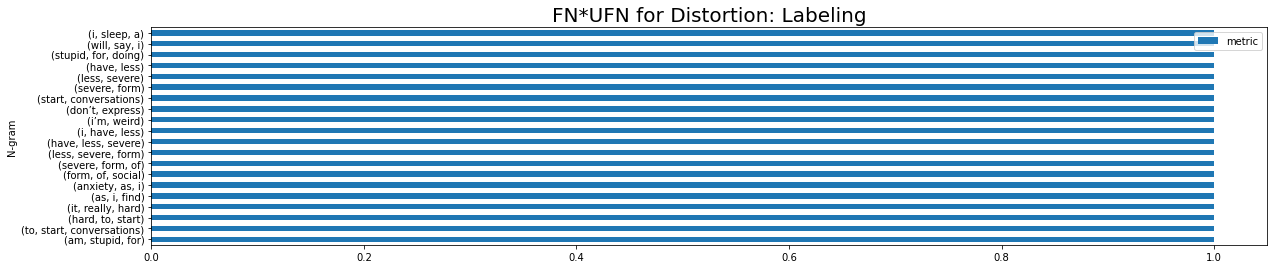

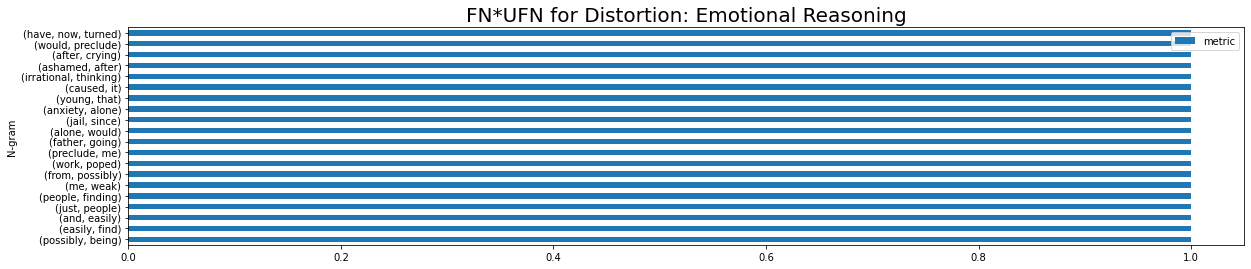

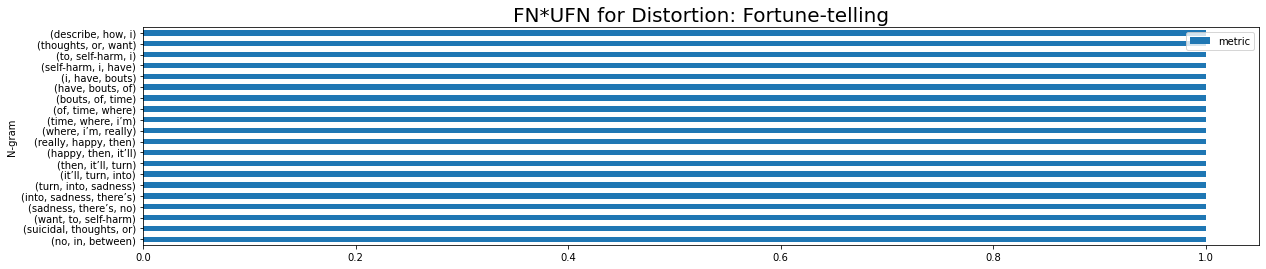

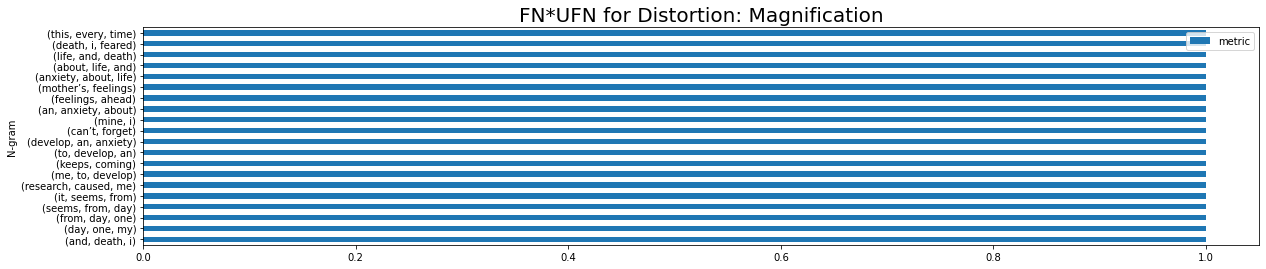

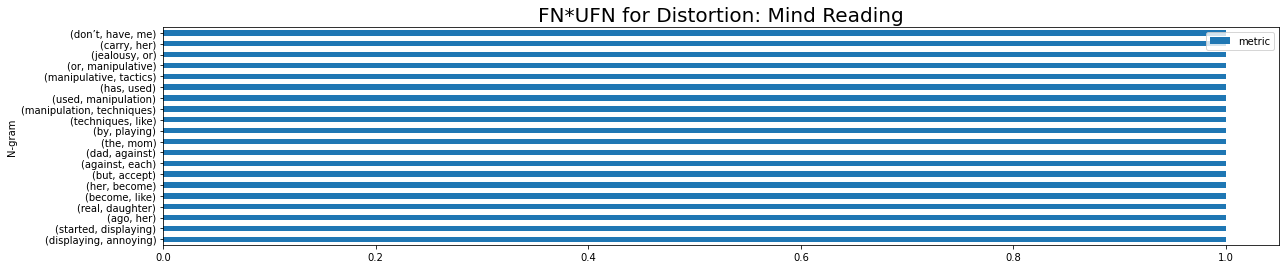

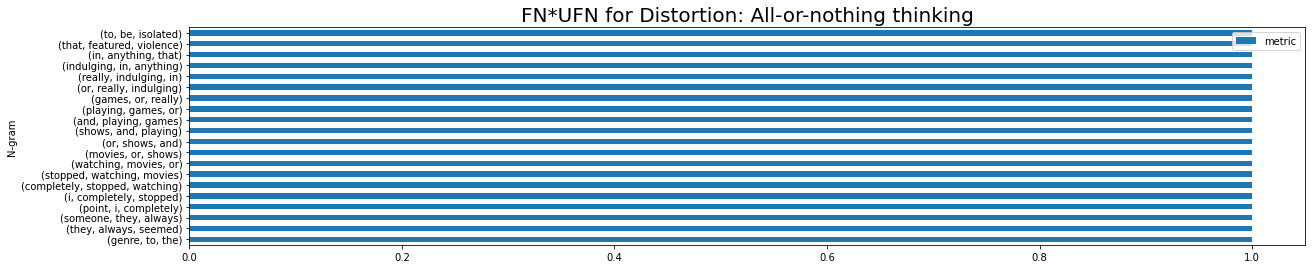

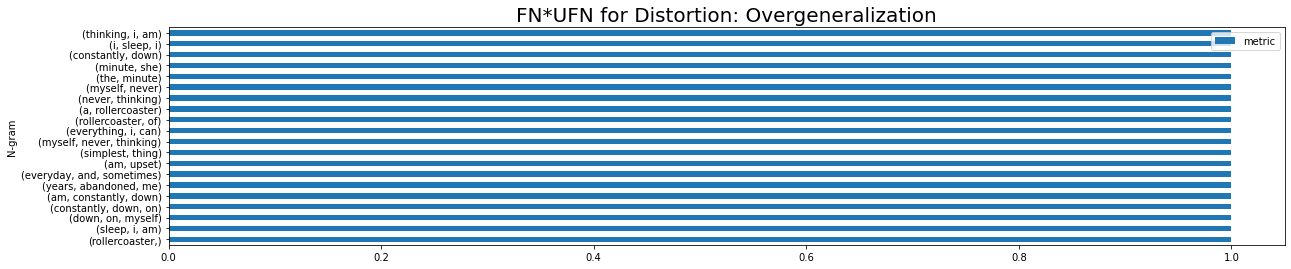

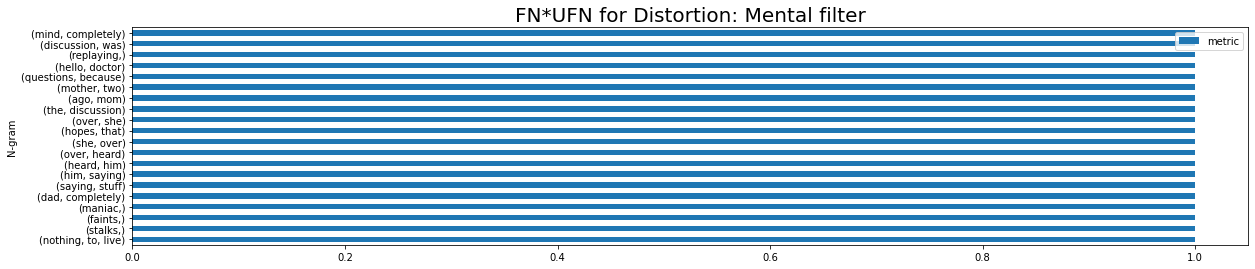

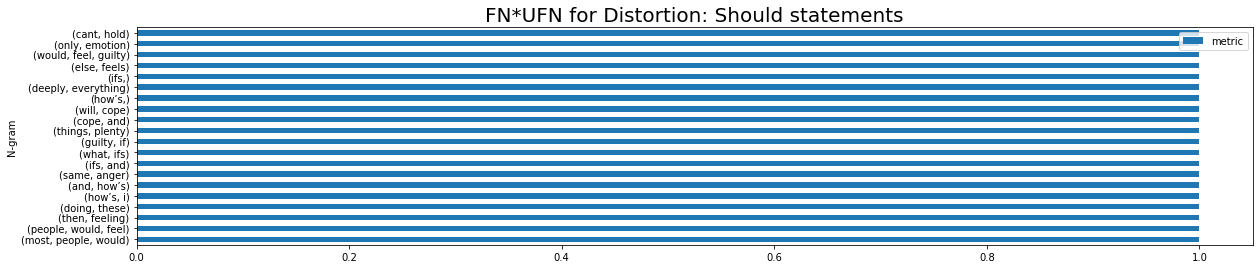

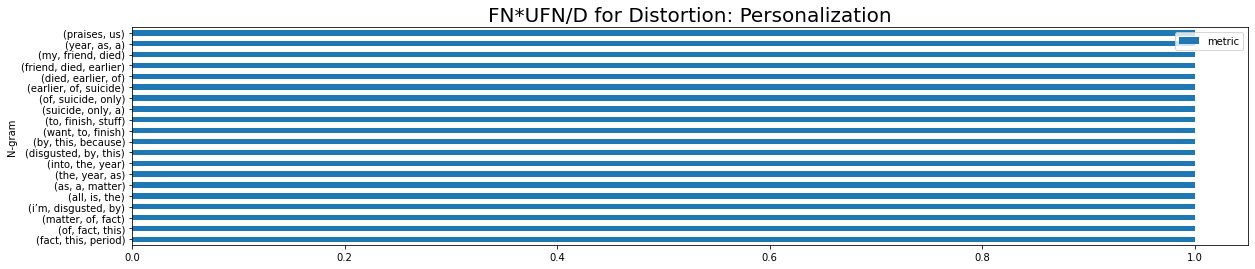

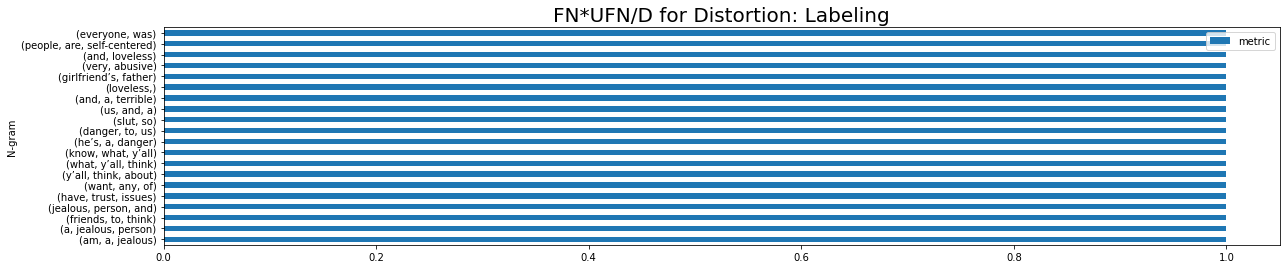

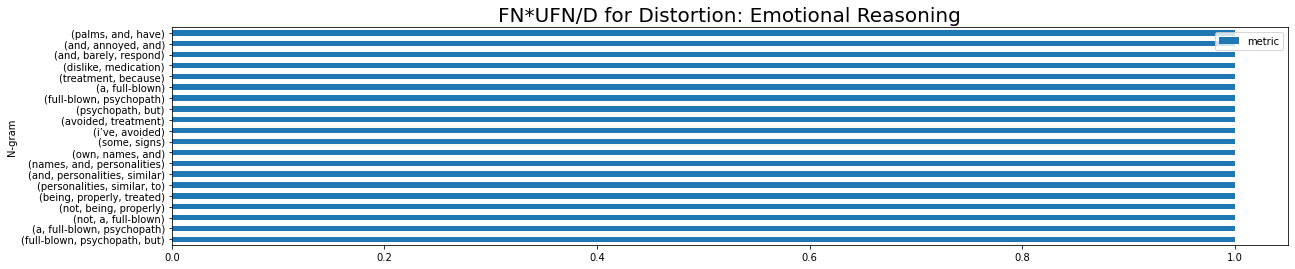

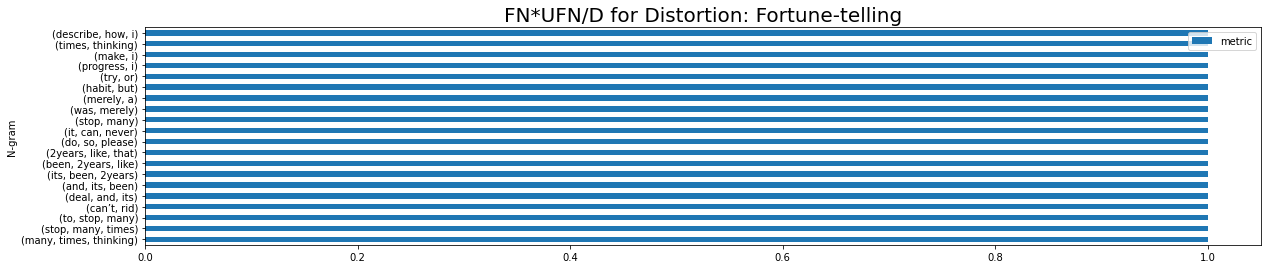

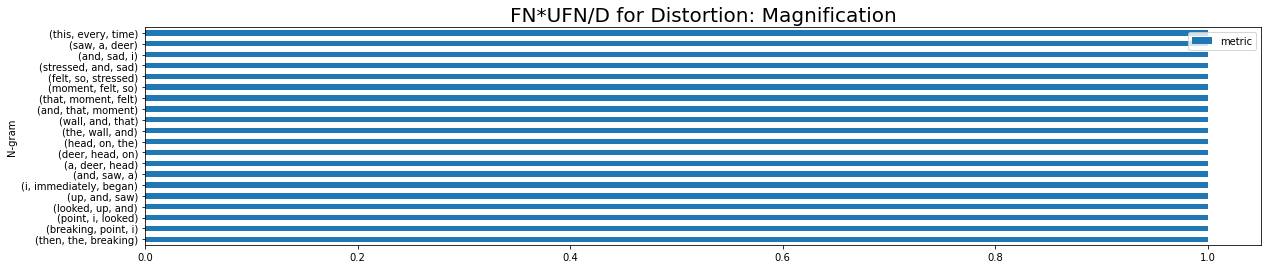

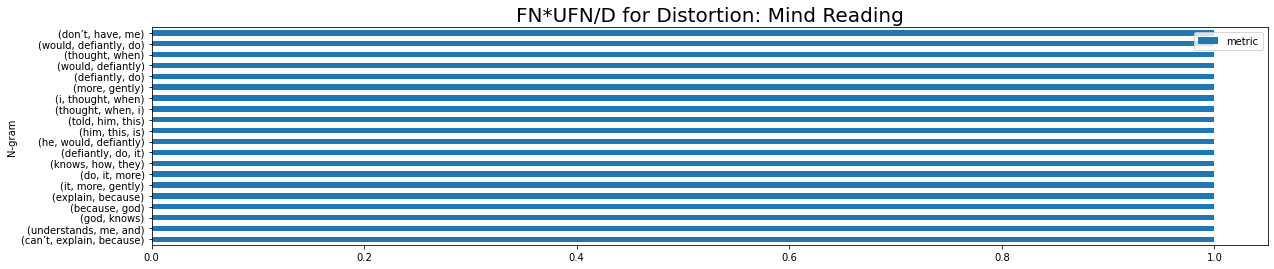

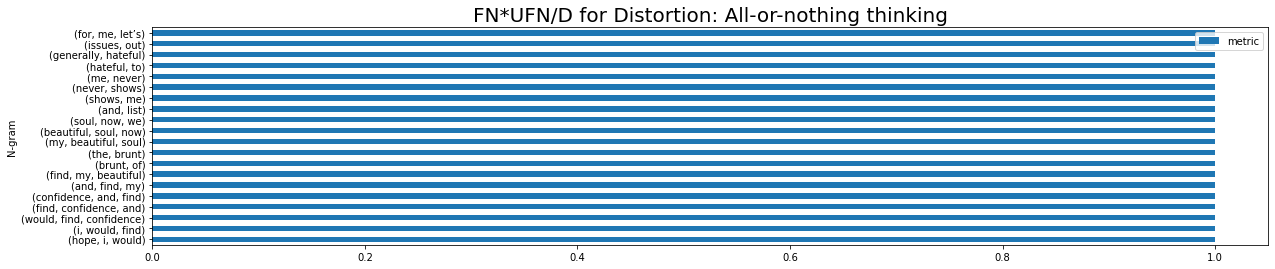

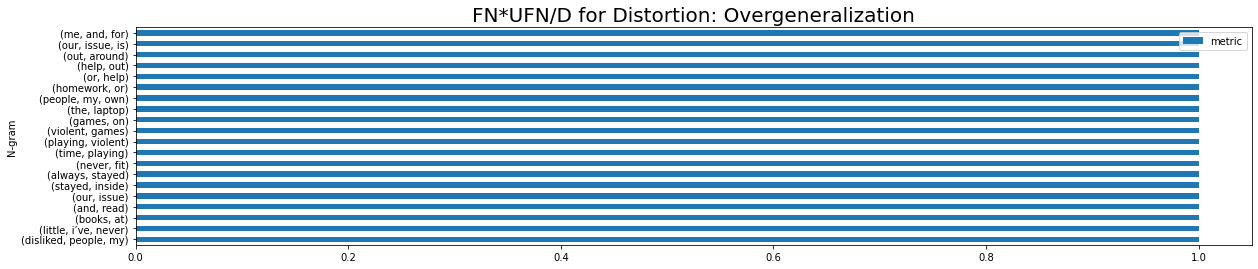

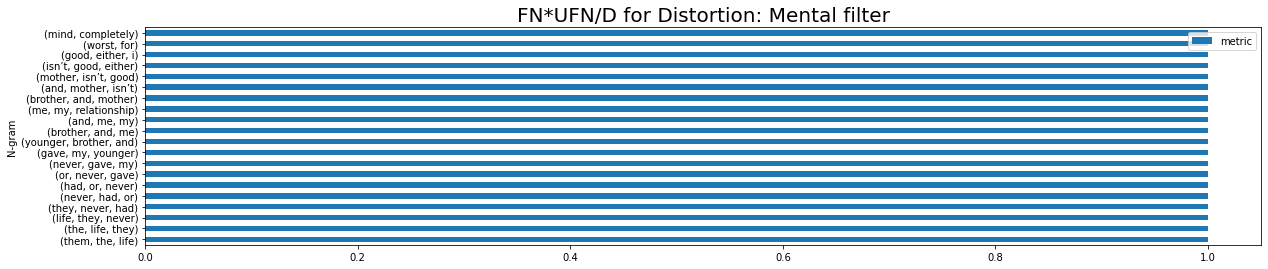

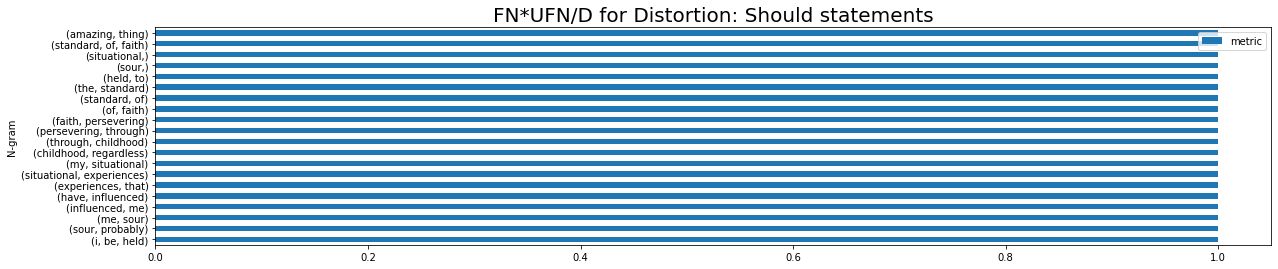

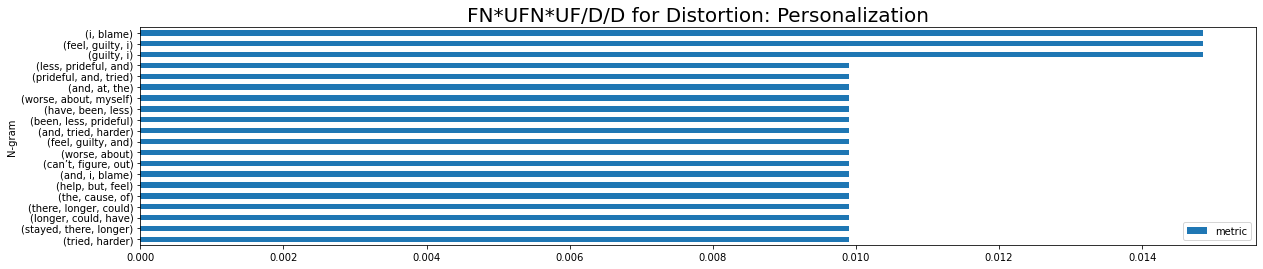

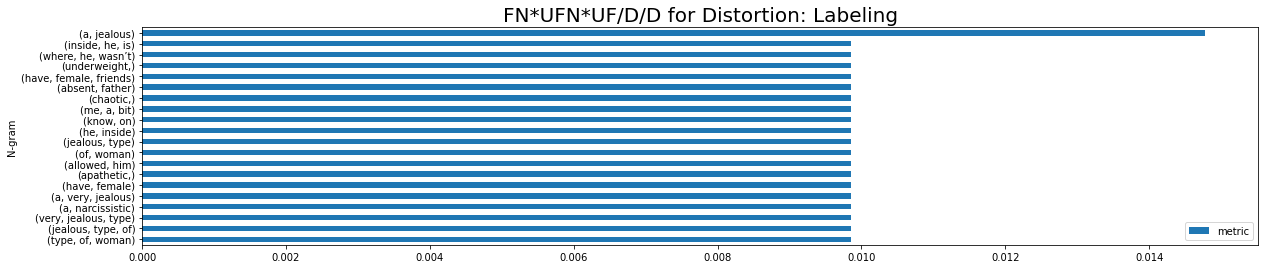

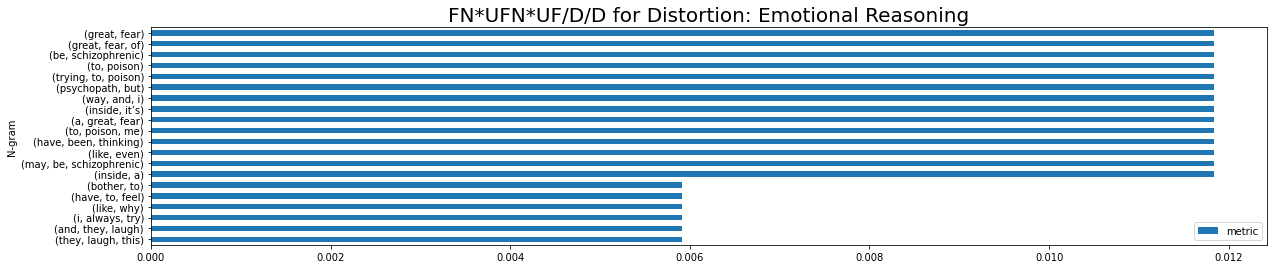

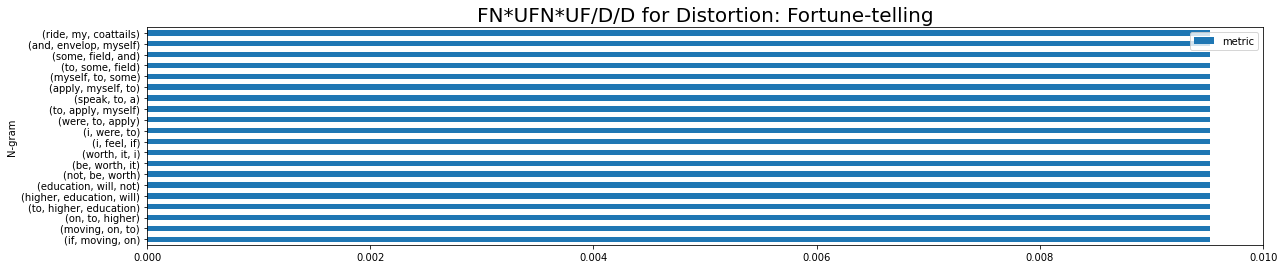

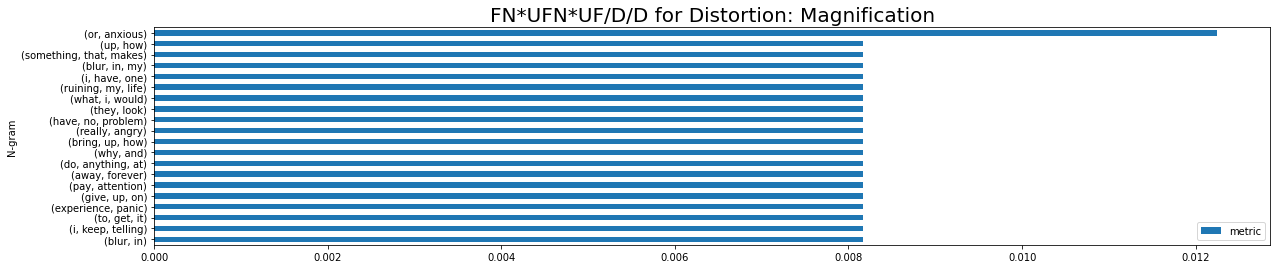

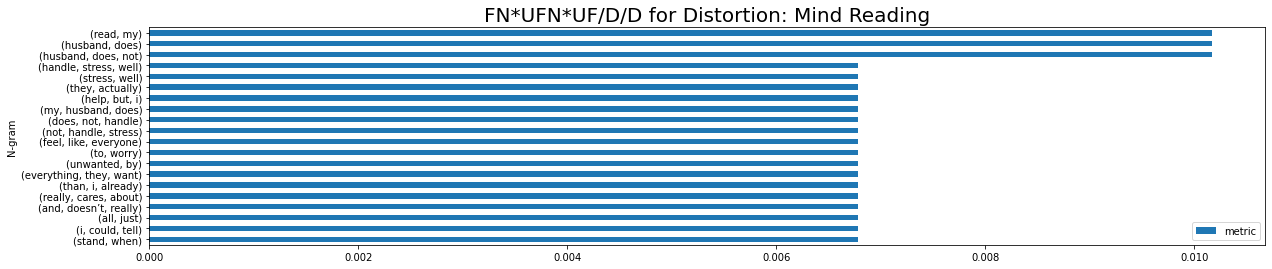

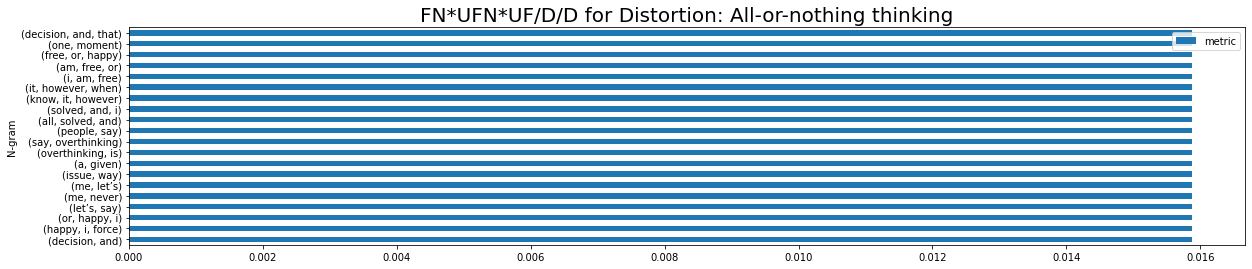

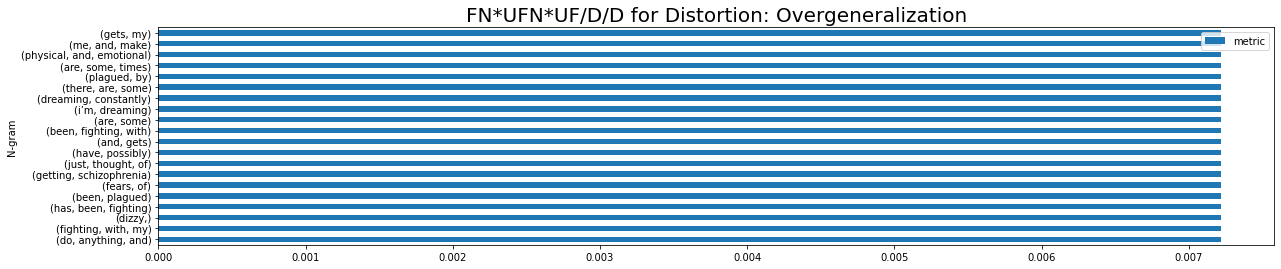

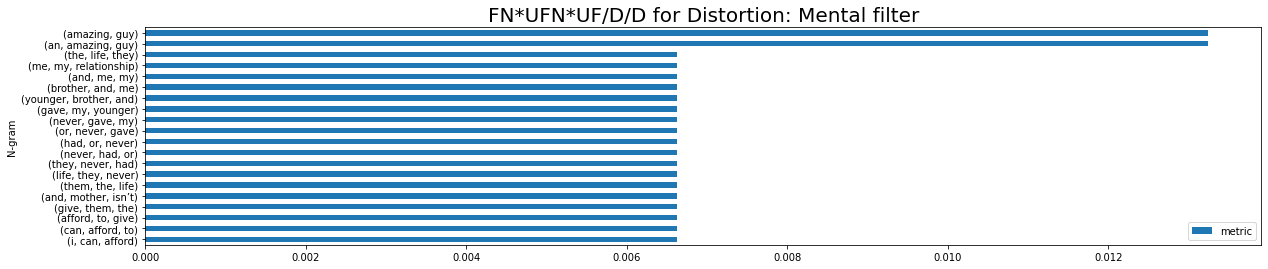

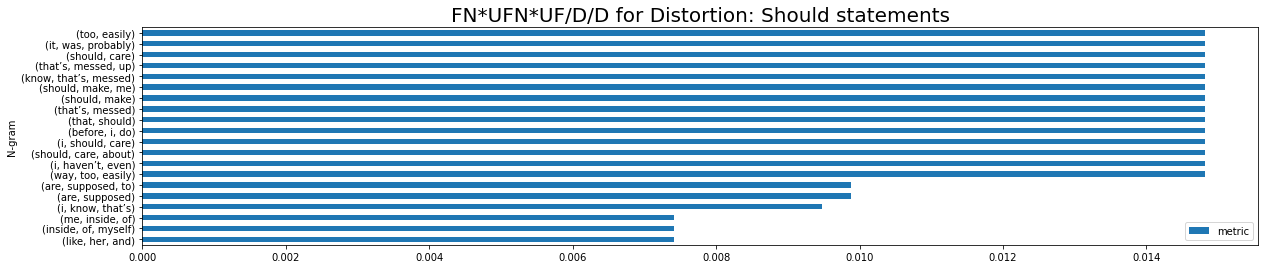

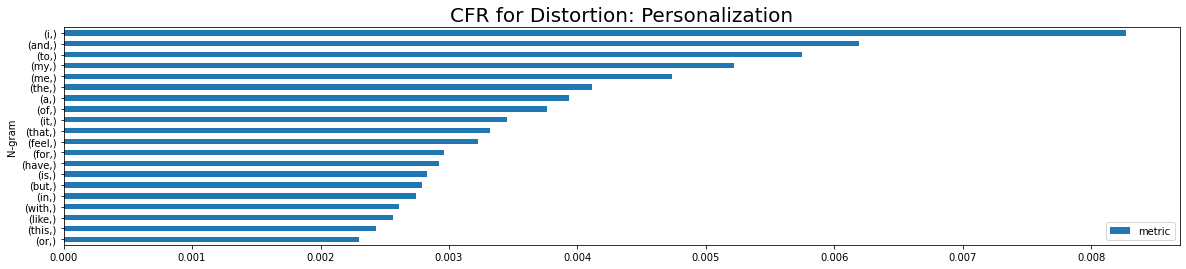

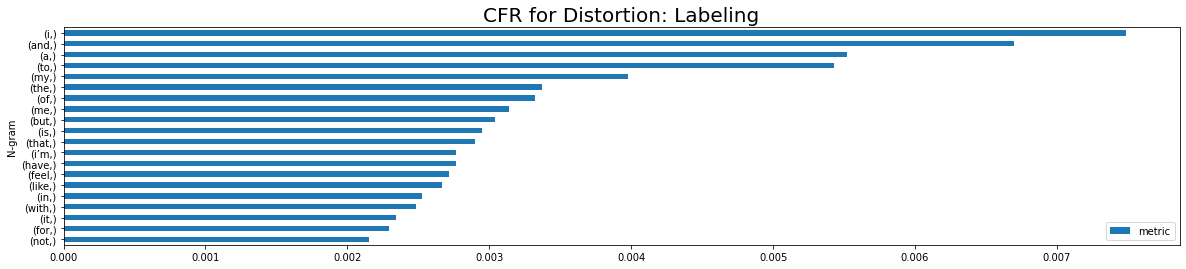

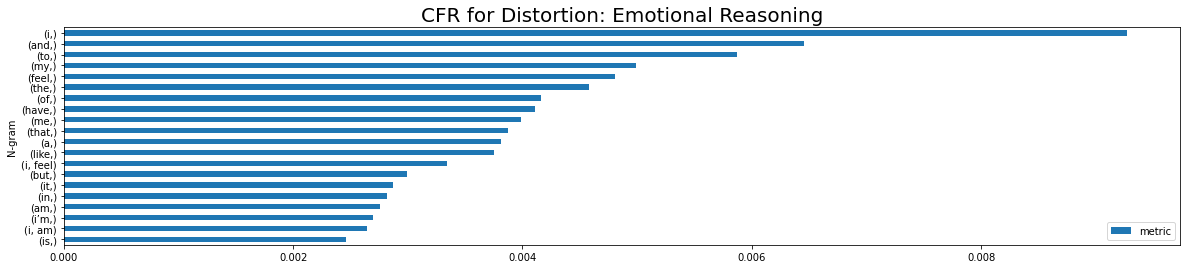

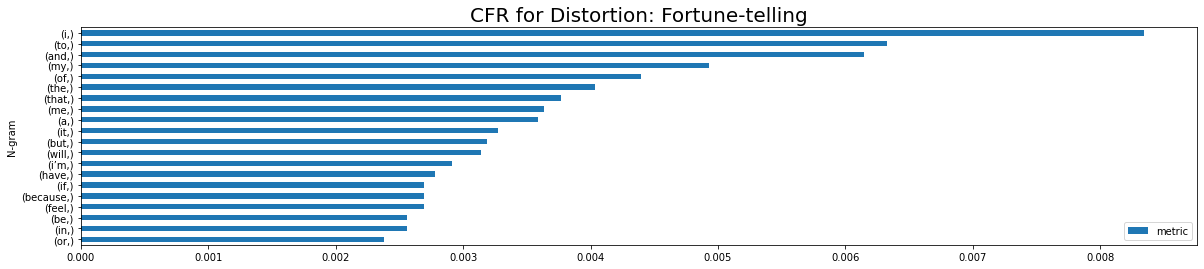

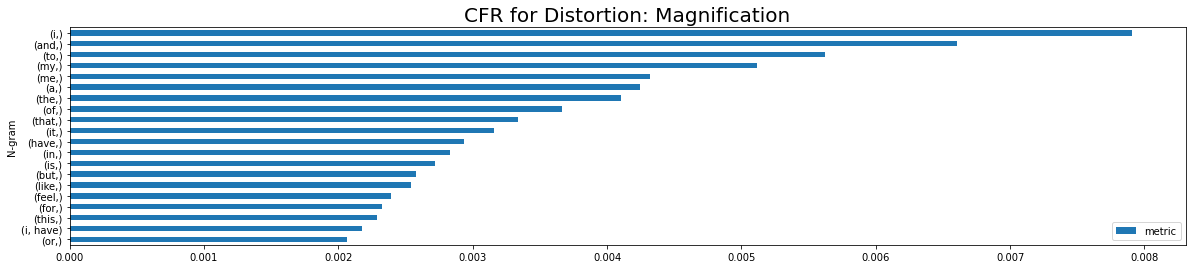

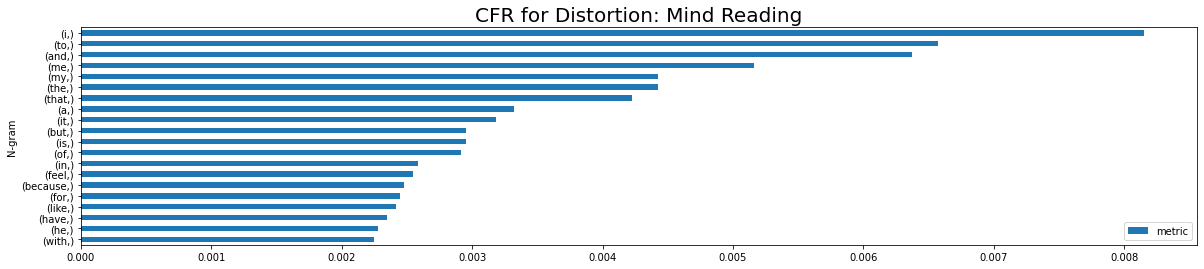

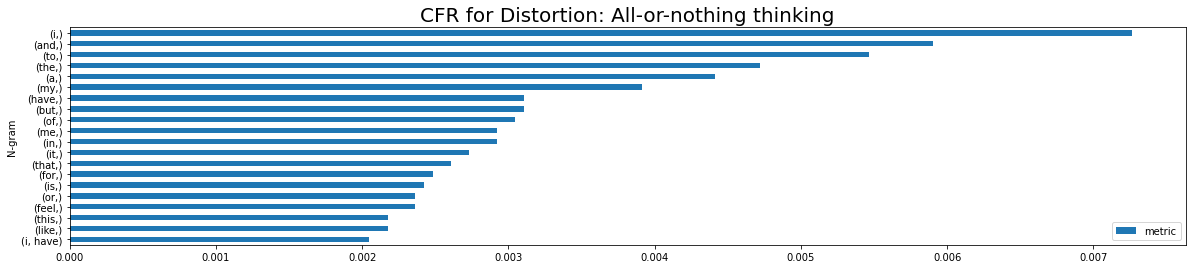

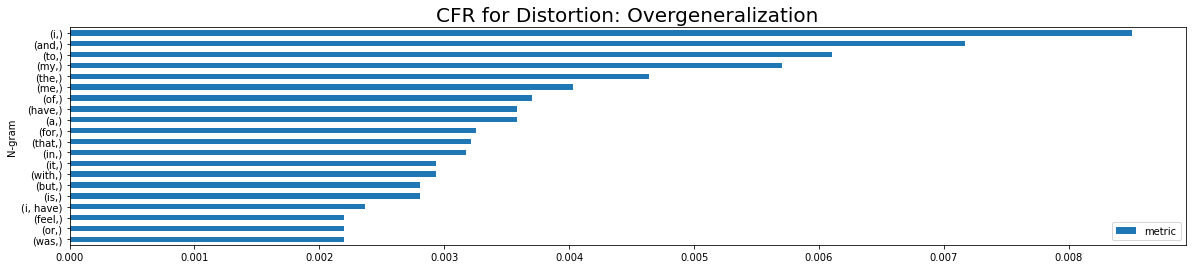

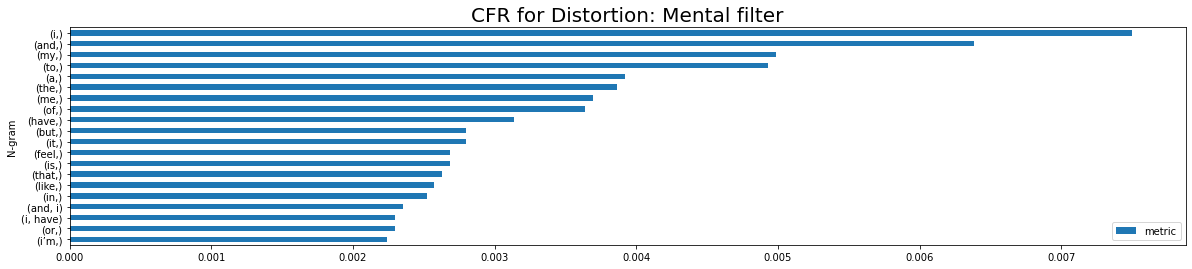

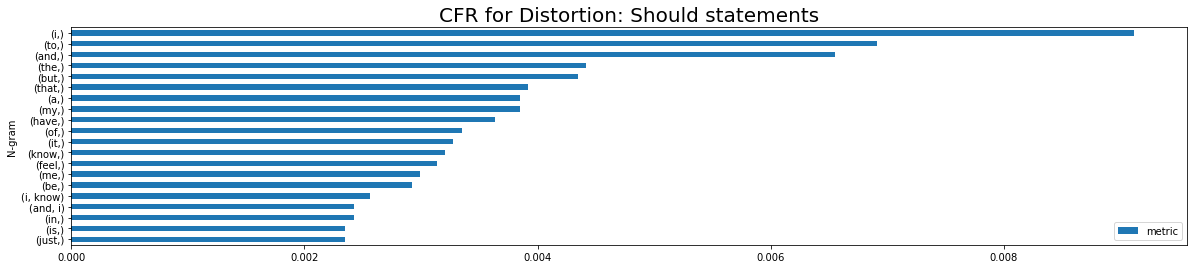

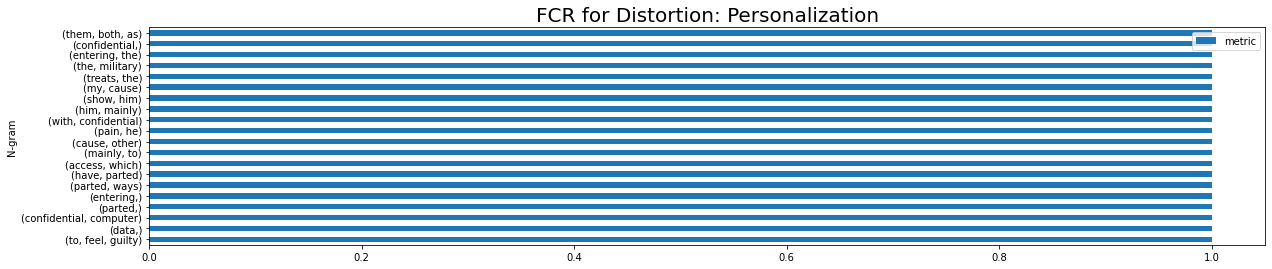

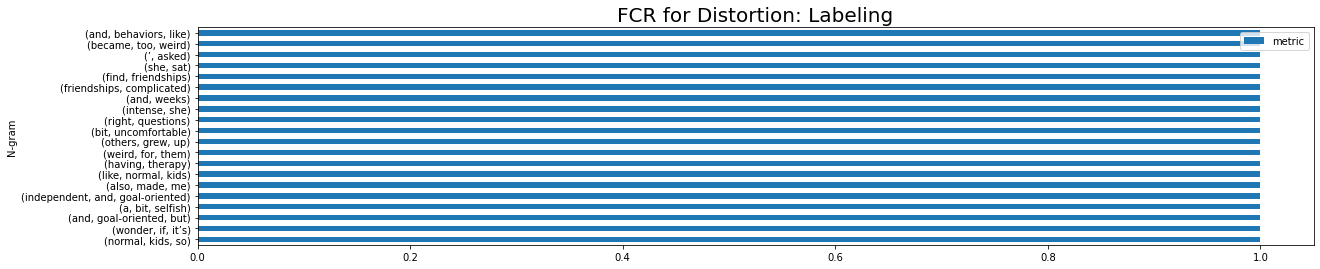

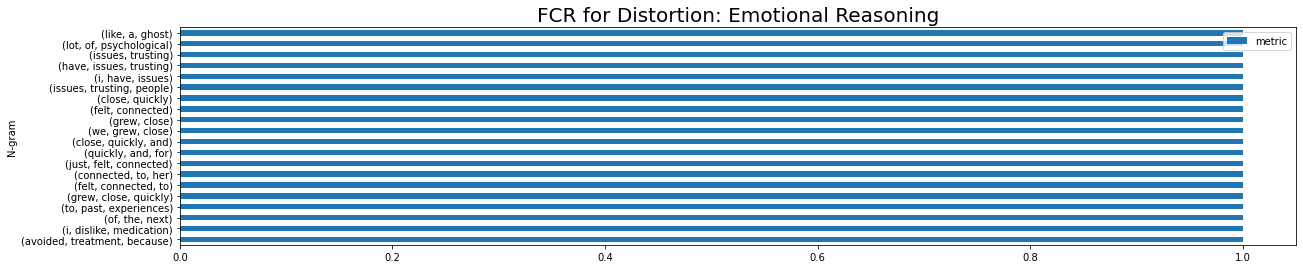

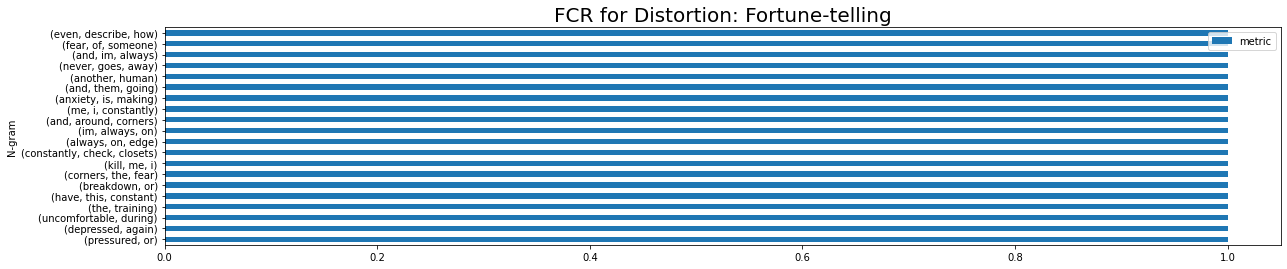

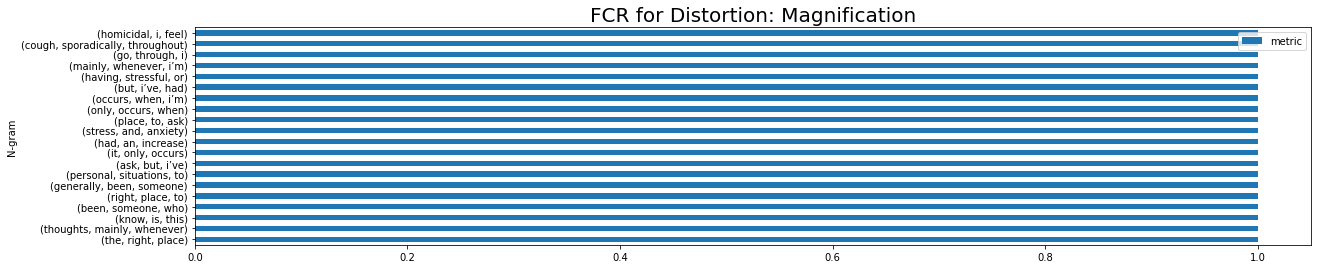

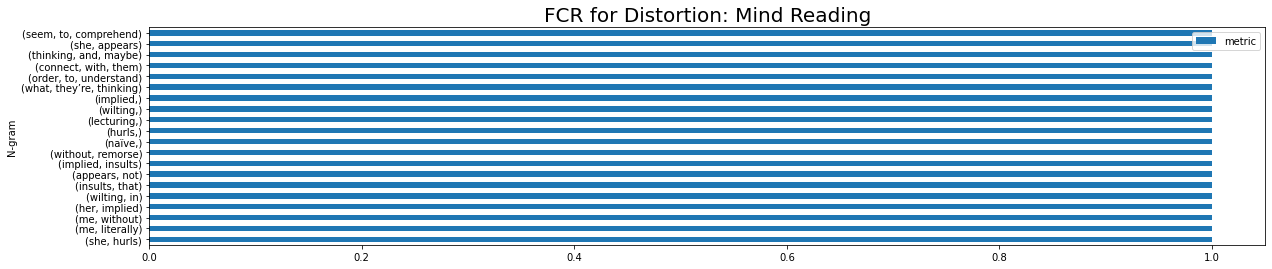

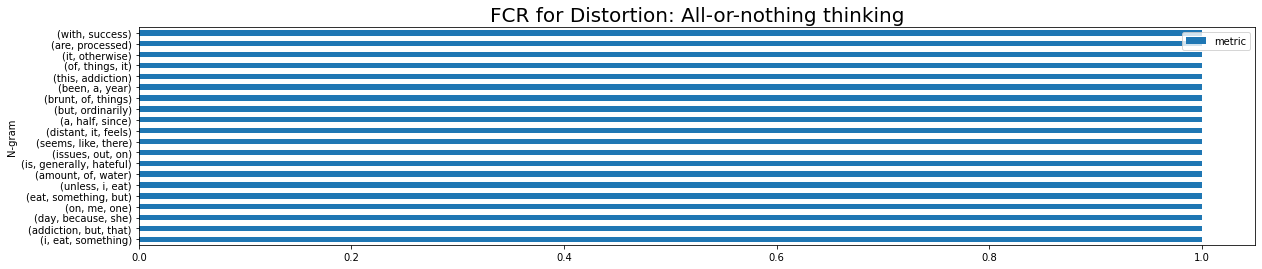

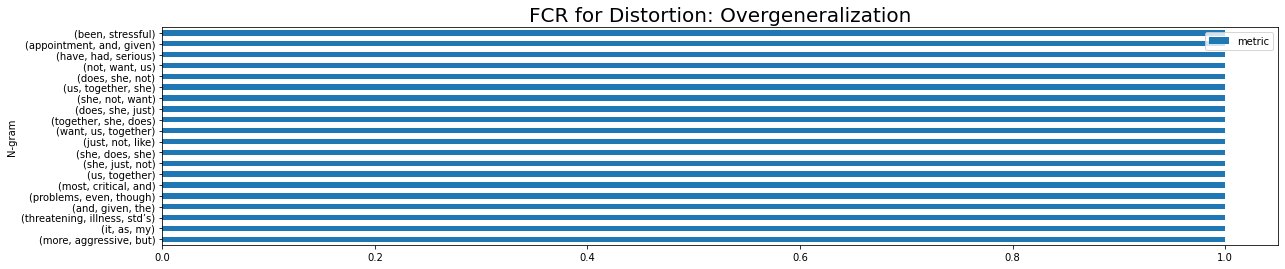

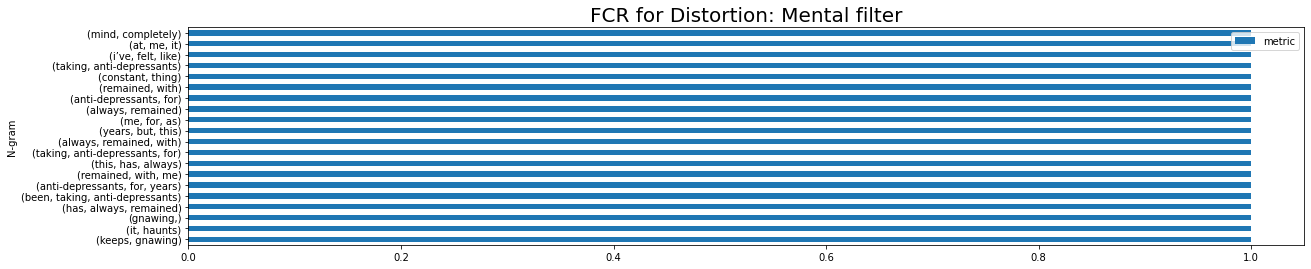

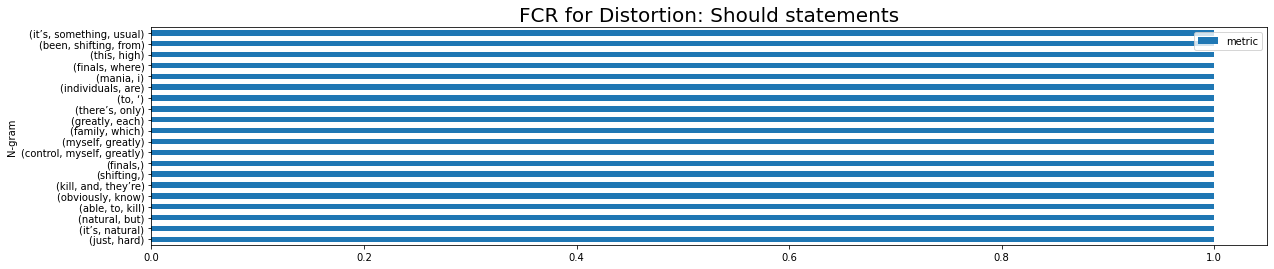

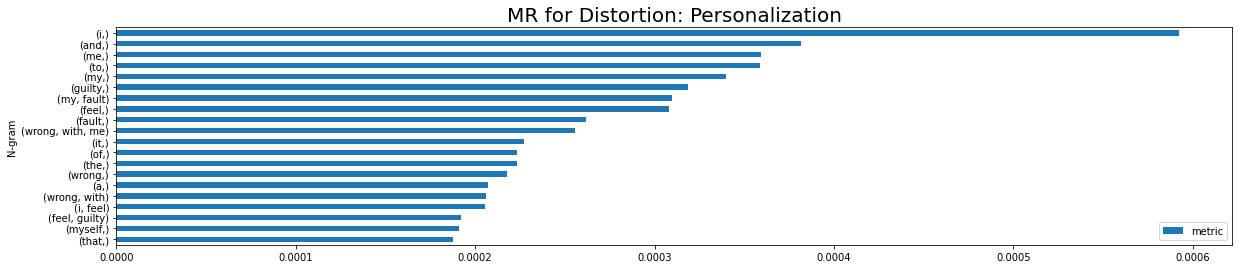

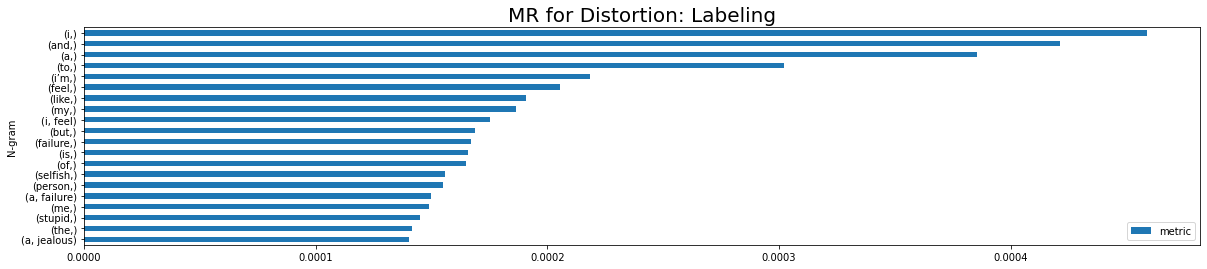

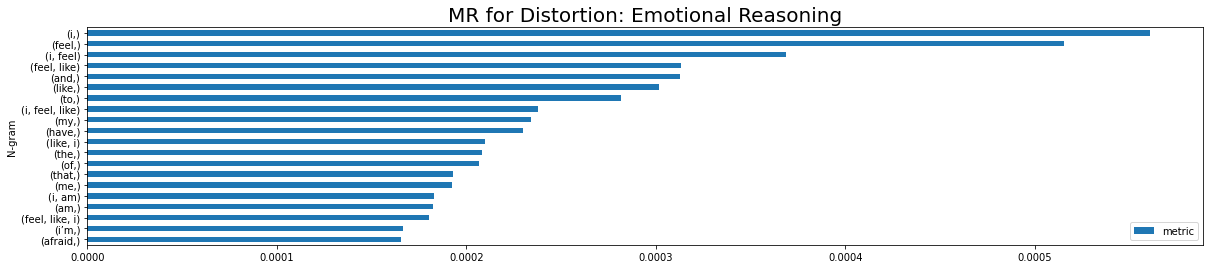

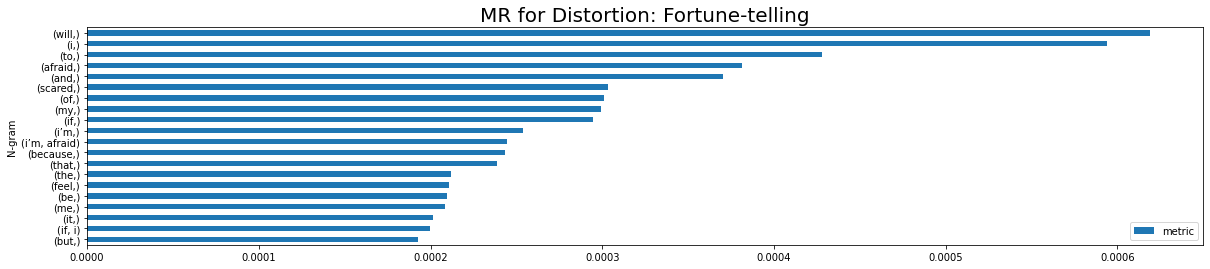

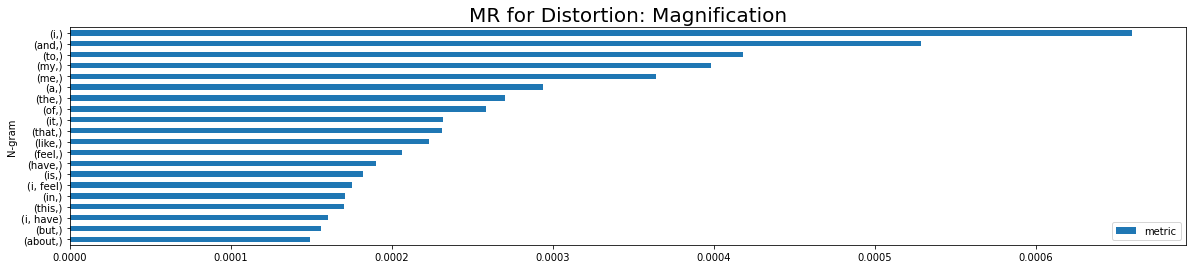

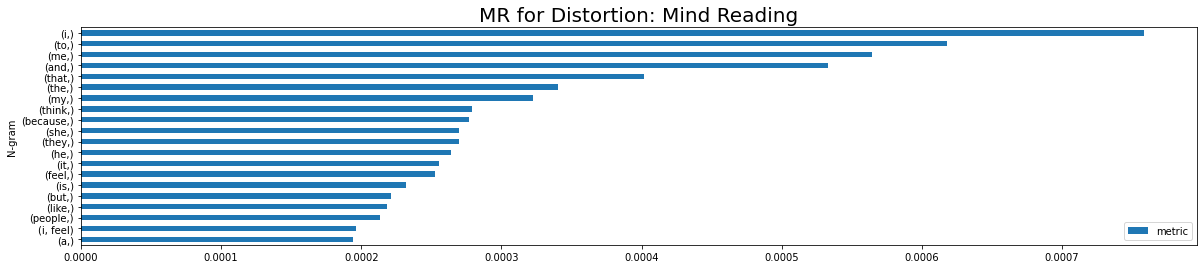

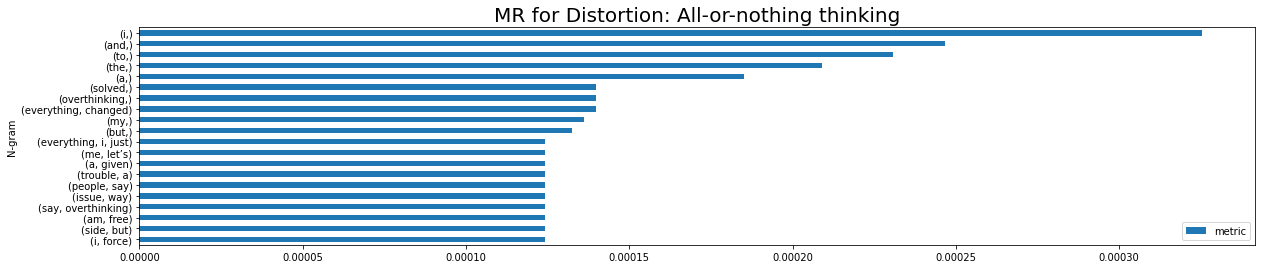

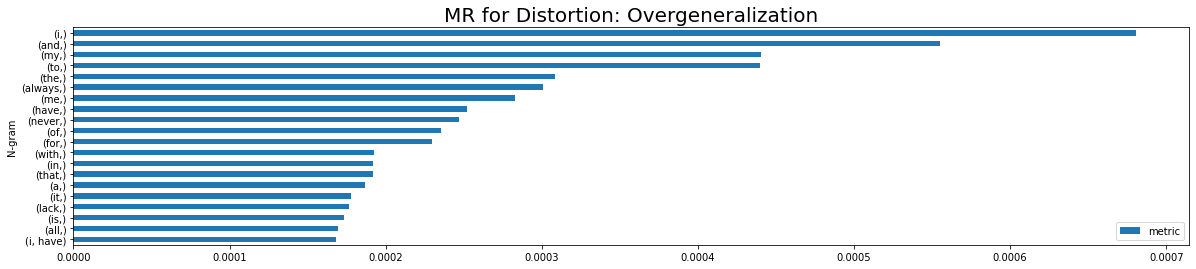

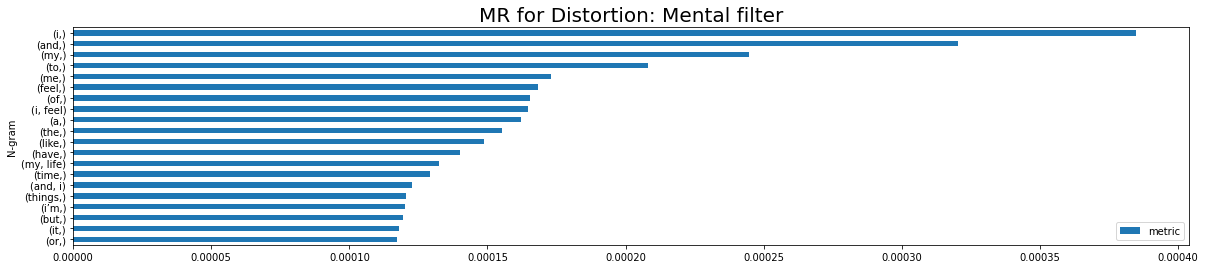

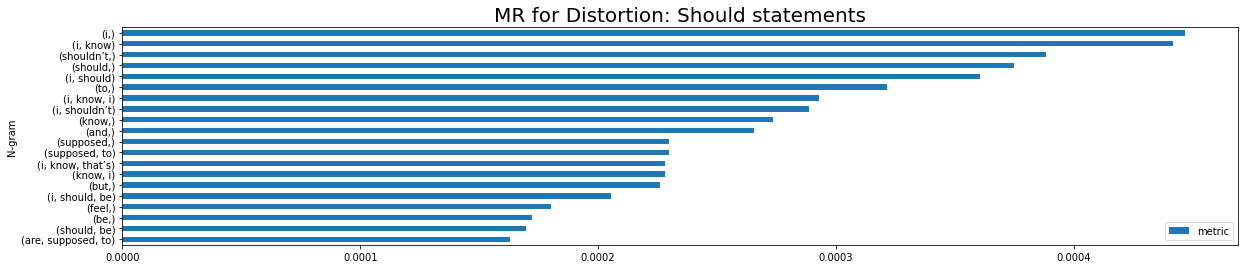

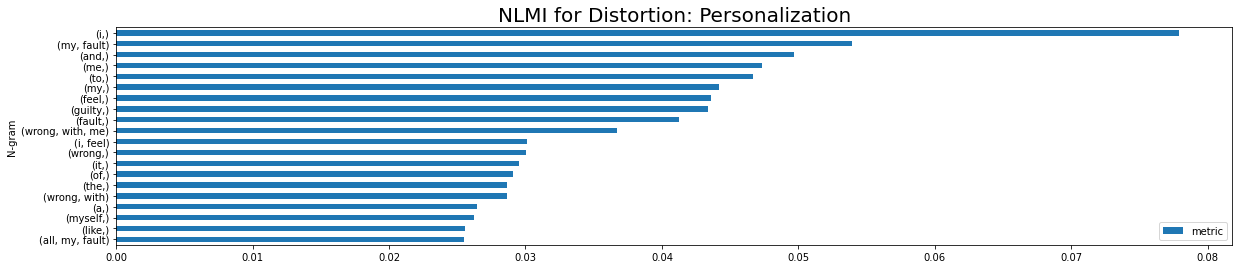

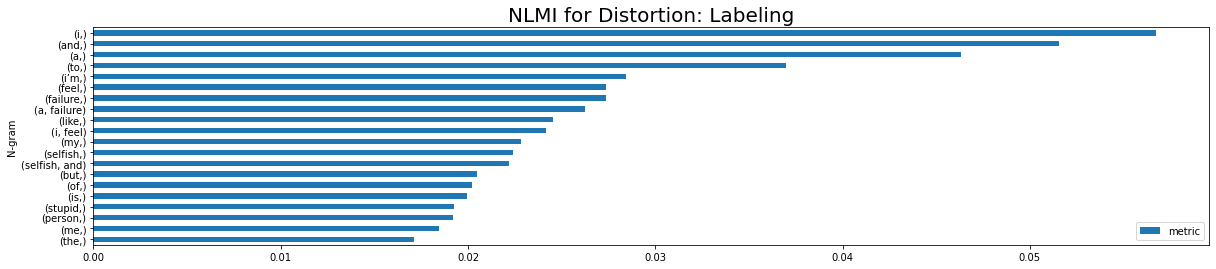

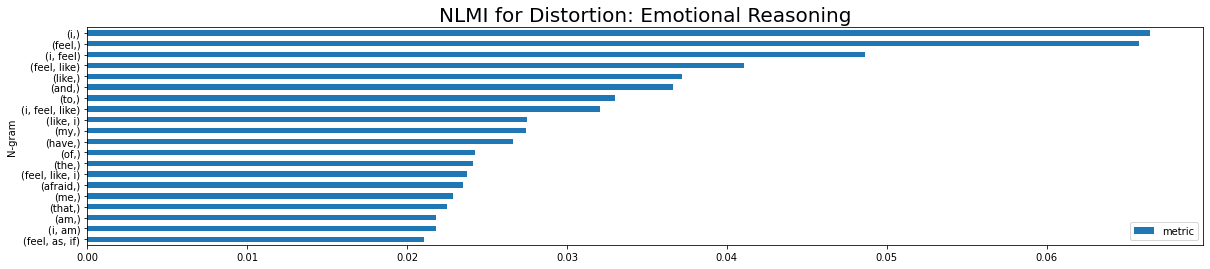

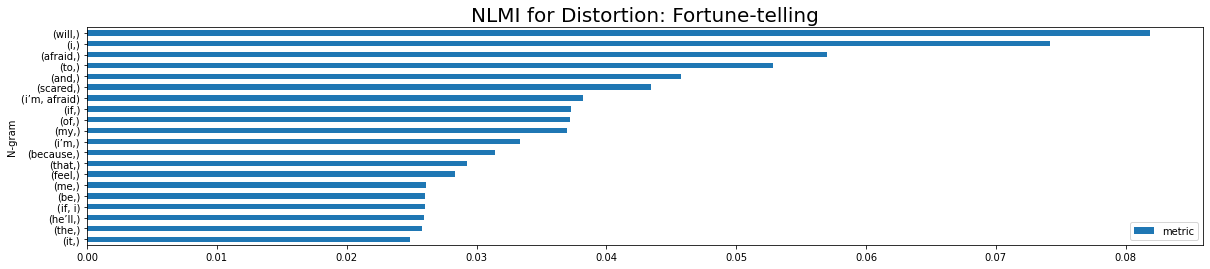

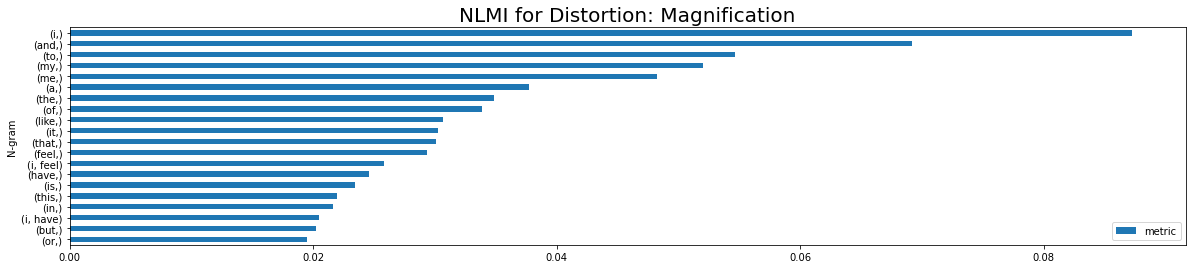

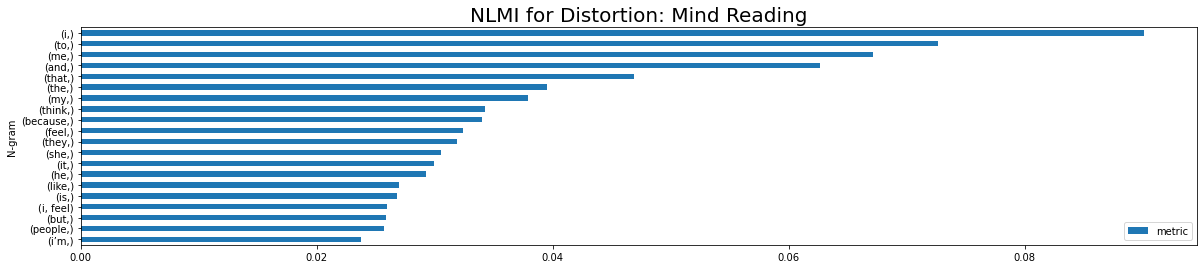

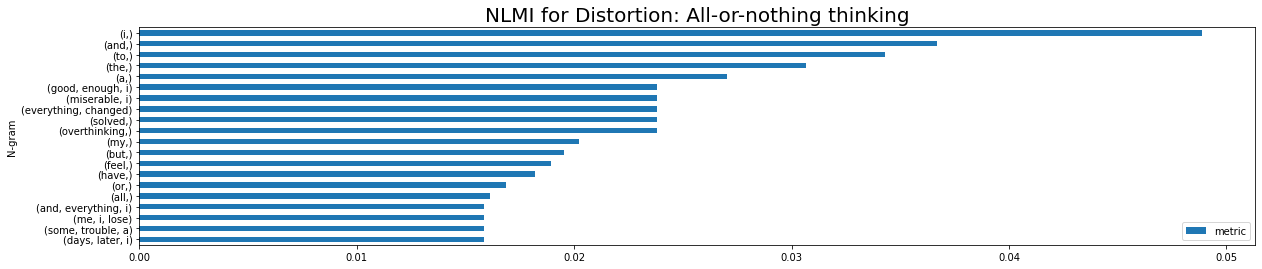

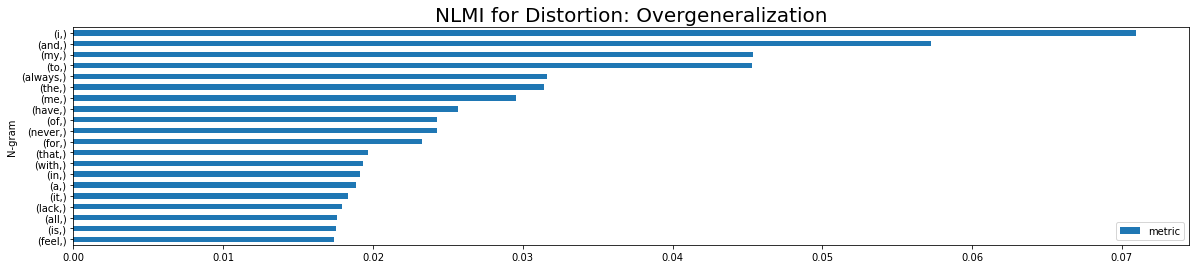

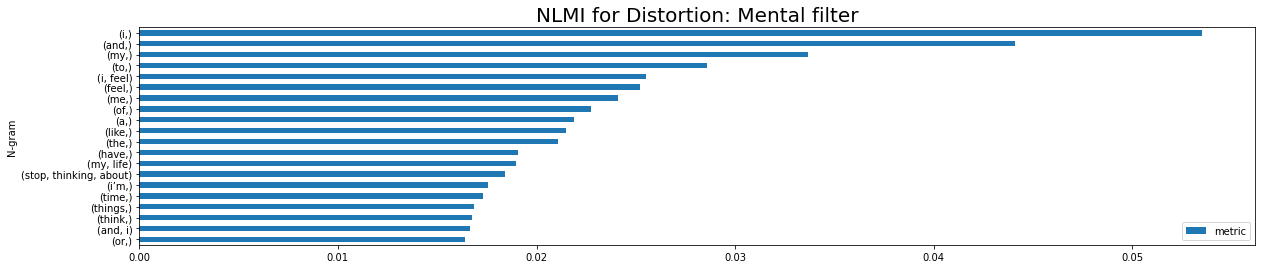

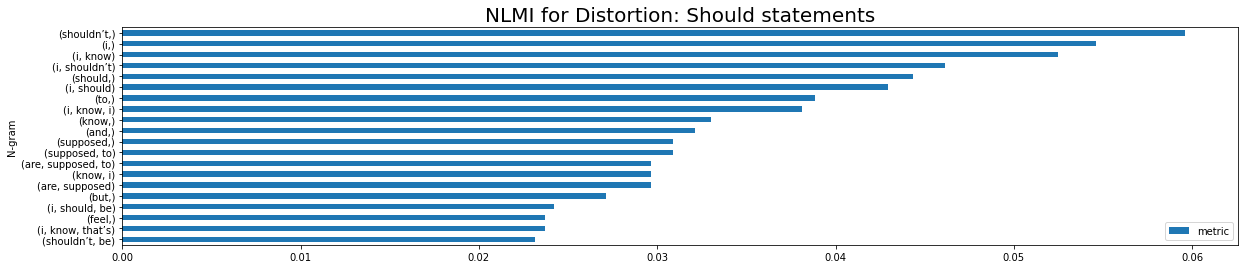

In [45]:
for selection_metric in selection_metrics:
    plot_metric(selection_metric[0],selection_metric[1],head = 20)

## Check for Duplicates

In [55]:
file_babacan = 'Cognitive_distortions.csv' # https://huggingface.co/halilbabacan/autotrain-cognitive_distortions-73482139269 (Experiment-2 (Synthetic + Existing Data))
file_shreevastava = 'Annotated_data.csv' # https://www.kaggle.com/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset

df_babacan = pd.read_csv(binary_dataset_file_path)
df_shreevastava = pd.read_csv(multiclass_dataset_file_path) 

texts_babacan = [l.lower() for l in list(df_babacan['Text'])]
texts_shreevastava = [(l1.lower() if type(l2)==float else l2.lower()) for l1,l2 in zip(list(df_shreevastava['Patient Question']),df_shreevastava['Distorted part'])]
texts_shreevastava_distorted_part = [str(l).lower() for l in list(df_shreevastava['Distorted part'])]
texts_shreevastava_patient_question = [l.lower() for l in list(df_shreevastava['Patient Question'])]

b_in_s = [t for t in texts_babacan if (t in texts_shreevastava_distorted_part or t in texts_shreevastava_patient_question)]
st_in_b = [t for t in texts_shreevastava_patient_question if t in texts_babacan]
sd_in_b = [t for t in texts_shreevastava_distorted_part if t in texts_babacan]
s_in_b = [t for t in texts_shreevastava if t in texts_babacan]

print(len(b_in_s))
print(len(st_in_b))
print(len(sd_in_b))
print(len(s_in_b))

49
3
46
48


In [56]:
df_shreevastava

Id_Number                                   Patient Question  \
0          4500  Hello, I have a beautiful,smart,outgoing and a...   
1          4501  Since I was about 16 years old I’ve had these ...   
2          4502   So I’ve been dating on and off this guy for a...   
3          4503  My parents got divorced in 2004. My mother has...   
4          4504  I don’t really know how to explain the situati...   
...         ...                                                ...   
2525       2562  I’m a 21 year old female. I spent most of my l...   
2526       2563  I am 21 female and have not had any friends fo...   
2527       2564  From the U.S.: My brother is 19 years old and ...   
2528       2565  From the U.S.: I am a 21 year old woman who ha...   
2529       2568  I recently moved out on my ex-roommate because...   

                                         Distorted part Dominant Distortion  \
0     The voice are always fimilar (someone she know...     Personalization   
1     I feel trapped inside my disgusting self and l...            Labeling   
2                                                   NaN       No Distortion   
3                                                   NaN       No Distortion   
4     I refused to go because I didn’t know if it wa...     Fortune-telling   
...                                                 ...                 ...   
2525                                                NaN       No Distortion   
2526  Now I am at university my peers around me all ...  Overgeneralization   
2527  He claims he’s severely depressed and has outb...       Mental filter   
2528                                                NaN       No Distortion   
2529                                                NaN       No Distortion   

     Secondary Distortion (Optional)  
0                                NaN  
1                Emotional Reasoning  
2                                NaN  
3                                NaN  
4                Emotional Reasoning  
...                              ...  
2525                             NaN  
2526                             NaN  
2527                    Mind Reading  
2528                             NaN  
2529                             NaN  

[2530 rows x 5 columns]

In [58]:
for t in texts_shreevastava[:10]:
    print(t)
    print()

the voice are always fimilar (someone she knows) im very concerned about this and hope it has nothing to do with my pregnancy while on active duty.

i feel trapped inside my disgusting self and like i’m willing to do anything to escape it.i’m just afraid sometimes that since i’m not really thinking during these times that i might do something to myself–especially since i think during these times that i don’t deserve to get help or that i’m not worth disturbing people by calling them.

 so i’ve been dating on and off this guy for almost 3 years. he is 3 years younger than me. during our relationship we had always had issues. first he wouldn’t call me, he would prefer to go out with his friends than me, he wouldn’t even remember the day of our anniversary, or things like that we kind of tried to work all that out but i’ve always felt that he really doesn’t love and care about me, even though he says he loves me. also he has lied to me during this time, first once he went to a party and w

In [121]:
from pygents.text import get_grams
from pygents.util import cosine_similarity, dictcount

def get_char_grams(items,n=2):
    grams = []
    for i in range(len(items) - (n-1)):
        gram = None
        for j in range(n):
            gram = items[i+j] if gram is None else gram + items[i+j]
        grams.append(gram)
    return grams

def get_char_grams_dicts(items,n=2):
    grams = get_char_grams(items,n)
    d = {}
    for g in grams:
        dictcount(d,g)
    return d

def texts_char_grams_counts(texts,n=2):
    grams = {}
    for t in texts:
        grams[t] = get_char_grams_dicts(t,2)
    return grams

print(get_char_grams_dicts("Hello world, hello"))
print(texts_char_grams_counts(["ping","pong"]))

{'He': 1, 'el': 2, 'll': 2, 'lo': 2, 'o ': 1, ' w': 1, 'wo': 1, 'or': 1, 'rl': 1, 'ld': 1, 'd,': 1, ', ': 1, ' h': 1, 'he': 1}
{'ping': {'pi': 1, 'in': 1, 'ng': 1}, 'pong': {'po': 1, 'on': 1, 'ng': 1}}


In [157]:
def get_item_grams(items,n=2):
    grams = []
    for i in range(len(items) - (n-1)):
        gram = []
        for j in range(n):
            gram.append(items[i+j])
        grams.append(tuple(gram))
    return grams

def get_char_item_dicts(items,n=2):
    grams = get_item_grams(items,n)
    d = {}
    for g in grams:
        dictcount(d,g)
    return d

def texts_item_grams_counts(texts,n=2,clean_punct=False):
    grams = {}
    for text in texts:
        tokens = tokenize_re(text)
        if clean_punct:
            tokens = [t for t in tokens if not (t in punct or t.isnumeric())]
        grams[text] = get_item_grams_dicts(tokens,2)
    return grams

print(get_item_grams_dicts(tokenize_re("Hello world, hello world")))
print(texts_item_grams_counts(["play ping pong!","sing ding dong..."]))
print(texts_item_grams_counts(["play ping pong!","sing ding dong..."],clean_punct=True))

{('hello', 'world'): 2, ('world', ','): 1, (',', 'hello'): 1}
{'play ping pong!': {('play', 'ping'): 1, ('ping', 'pong'): 1, ('pong', '!'): 1}, 'sing ding dong...': {('sing', 'ding'): 1, ('ding', 'dong'): 1, ('dong', '.'): 1, ('.', '.'): 2}}
{'play ping pong!': {('play', 'ping'): 1, ('ping', 'pong'): 1}, 'sing ding dong...': {('sing', 'ding'): 1, ('ding', 'dong'): 1}}


### Match based on char-bigrams

In [187]:
print(len(texts_shreevastava))
dicts_shreevastava = texts_char_grams_counts(texts_shreevastava)
dicts_babacan = texts_char_grams_counts(texts_babacan)


2530


In [188]:
counts = []
for s in dicts_shreevastava:
    s_dic = dicts_shreevastava[s]
    for b in dicts_babacan:
        b_dic = dicts_babacan[b]
        sim = cosine_similarity(s_dic,b_dic)
        if sim >= 0.90:
            counts.append((s,b,sim))
            break
print(len(counts))     

2520


In [189]:
count = 0
for cp in counts:
    if cp[2] < 0.91:
        print(round(cp[2],3))
        print('shreevastava:',cp[0])
        print('babakan:',cp[1])
        count += 1
print(len(counts),count) 

0.9
shreevastava: i feel like he has split personalities. many times he doesn’t remember tasks he completed days ago. we are at a stressful time in our relationship which includes the 6 month old baby. we used to be best friends and still today sometimes we enjoy time shared with the baby, but i see more and more he has no idea of what i’m referring to because he asks, “huh?” all the time. there has been lingering problems. i really don’t understand any of this and i’m falling deeply into depression myself that along with the baby weight i can’t shed. if i ask him for the truth he will simply look me in the face and tell another lie. {i can’t bear it, seriously.} 
babakan: okay before i start i’m 20yrs old living with my mother and father and 4 other siblings as far back as i can remember he constantly abused me mentally and physically to the point i’m traumatized and scared all over my body espically my face i don’t want to turn to the police because he is only like that with me alone

### Match based on word-bigrams including punctuation

In [181]:
print(len(texts_shreevastava))
words_shreevastava = texts_item_grams_counts(texts_shreevastava)
words_babacan = texts_item_grams_counts(texts_babacan)


2530


In [182]:
words_counts = []
for s in words_shreevastava:
    s_dic = words_shreevastava[s]
    for b in words_babacan:
        b_dic = words_babacan[b]
        sim = cosine_similarity(s_dic,b_dic)
        if sim >= 0.50:
            words_counts.append((s,b,sim))
            break
print(len(words_counts)) 

2522


In [183]:
count = 0
for cp in words_counts:
    if cp[2] < 0.75:
        print(round(cp[2],3))
        print('shreevastava:',cp[0])
        print('babakan:',cp[1])
        count += 1
print(len(words_counts),count) 

0.65
shreevastava: i thought that he displayed traits of honor, loyalty, integrity, honesty, and kind-heartedness, as well as characteristics of a hard worker, and an overall well-rounded individual.
babakan: i thought that he displayed traits of honor loyalty integrity honesty and kind-heartedness as well as characteristics of a hard worker and an overall well-rounded individual
0.69
shreevastava: then, i decided to become vegetarian and anorexic. to tell you the truth, i wasn’t a complete vegan at first. i was “98% vege”, meaning that i ate hotdogs/hamburgers/chicken nuggets/bacon/top ramen soup. in seventh grade, i became full-fledged vege, and continued to have problems. in eighth grade, i turned my life around, and was the food nazi: no food additives, no meat, healthy as you can be.
babakan: then i decided to become vegetarian and anorexic to tell you the truth i wasn’t a complete vegan at first i was “98% vege” meaning that i ate hotdogs/hamburgers/chicken nuggets/bacon/top rame

### Match based on word-bigrams excluding punctuation

In [184]:
print(len(texts_shreevastava))
words_shreevastava = texts_item_grams_counts(texts_shreevastava,clean_punct=True)
words_babacan = texts_item_grams_counts(texts_babacan,clean_punct=True)


2530


In [185]:
words_counts = []
for s in words_shreevastava:
    s_dic = words_shreevastava[s]
    for b in words_babacan:
        b_dic = words_babacan[b]
        sim = cosine_similarity(s_dic,b_dic)
        if sim >= 0.50:
            words_counts.append((s,b,sim))
            break
print(len(words_counts))


2523


In [186]:
count = 0
for cp in words_counts:
    if cp[2] < 0.75:
        print(round(cp[2],3))
        print('shreevastava:',cp[0])
        print('babakan:',cp[1])
        count += 1
print(len(counts),count) 


0.62
shreevastava: i was given attention in a different way, but rejected any emotionally connection because i saw emotions as negative because my brother/parents were arguing because of my brothers intense emotions.
babakan: i grew up in a upper middle class family i was given most things i wanted and all the essential things a child would need i have a brother who is 25 he has borderline personality disorder he acted out as a child/teenager was constantly arguing with my parents and soaked up much of my parents attention i was given attention in a different way but rejected any emotionally connection because i saw emotions as negative because my brother/parents were arguing because of my brothers intense emotions
0.74
shreevastava: i’m 63 year old male. i was abused physically and emotionally from a very young age by my father. he often whipped me with a thin pigskin belt as hard as he could while he screamed at me. when i cried he would whip me until i stopped crying. i remember the